# DESI PV Y3 Group/Cluster TFR Calibration

Using the list of groups defined by Tully in [*Galaxy Groups: a 2MASS Catalog*](https://iopscience.iop.org/article/10.1088/0004-6256/149/5/171), AJ 149:171, 2015, identify DESI observations with measurements suitable for calibrating the Tully-Fisher relation. 

Version: **15 April 2025**

**Note:** This requires using a subclassed version of `hyperfit`.

In [8]:
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = False
from matplotlib import cm, colors
from matplotlib.patches import Ellipse
import matplotlib as mpl

# We have more than 10 clusters, so we need to change from the default color map so that they are all plotted with different colors
from cycler import cycler
tfcolor = [(0.10588235294117647, 0.6196078431372549, 0.4666666666666667), 
(0.8509803921568627, 0.37254901960784315, 0.00784313725490196), 
(0.4588235294117647, 0.4392156862745098, 0.7019607843137254), 
(0.9058823529411765, 0.1607843137254902, 0.5411764705882353), 
(0.4, 0.6509803921568628, 0.11764705882352941), 
(0.,         0.10980392, 0.94509804),
(0.6509803921568628, 0.4627450980392157, 0.11372549019607843), 
(0.,         0.89019608, 0.55490196),
(0.99037293, 0.44055363, 0.20318339),
(6.20005e-01, 1.83840e-01, 4.97524e-01),
(1.46200e-03, 4.66000e-04, 1.38660e-02),
(0.4, 0.4, 0.4),
(0.,         0.21960784, 0.89019608),
(0.99607843, 0.74901961, 0.35294118),
(0.,         0.33333333, 0.83333333),
(9.29490e-02, 5.99040e-02, 2.39164e-01),
(0.99394079, 0.61894656, 0.26383699),
(8.04752e-01, 2.49911e-01, 4.42102e-01),
(0.,         0.66666667, 0.66666667),
(0.85396386, 0.07717032, 0.11933872),
(9.44006e-01, 3.77643e-01, 3.65136e-01),
(0.,         0.78039216, 0.60980392),
(9.92196e-01, 5.87502e-01, 4.06299e-01),
(0.50196078, 0., 0.14901961),
(0.,         0.55686275, 0.72156863),
(0.71209535, 0., 0.14901961),
(0.99703191, 0.87004998, 0.50279123),
(2.65447e-01, 6.02370e-02, 4.61840e-01),
(0.9019607843137255, 0.6705882352941176, 0.00784313725490196), 
(0.95555556, 0.2379085, 0.14640523),
(4.45163e-01, 1.22724e-01, 5.06901e-01),
(9.96369e-01, 7.91167e-01, 5.53499e-01),
(0.,         0.44313725, 0.77843137)]

plt.rcParams['axes.prop_cycle'] = cycler('color', tfcolor)

from astropy.table import Table, vstack, join
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astropy.visualization.wcsaxes import SphericalCircle
from astropy import units as u
from astropy import constants as c

from scipy.spatial.distance import cdist, euclidean

import os

from corner import corner

import pickle

import ligo.skymap.plot

from tqdm import tqdm

from matplotlib.projections import get_projection_names

from desiutil.plots import init_sky

# Custom functions / classes
import sys
sys.path.insert(1, '/global/homes/m/mjkeller/DESI_SGA/TF')
from help_functions import adjust_lightness
from line_fits import hyperfit_line_multi
from TF_photoCorrect import BASS_corr, MW_dust, k_corr, internal_dust

In [9]:
dark2 = plt.get_cmap('Dark2').colors
magma = mpl.colormaps['magma']
magmamap = magma(np.linspace(0,1,10))
ylorrd = mpl.colormaps['YlOrRd']
warmmap = ylorrd(np.linspace(0,1,10))
print(warmmap)

[[1.         1.         0.8        1.        ]
 [1.         0.93799308 0.64842753 1.        ]
 [0.99703191 0.87004998 0.50279123 1.        ]
 [0.99607843 0.74901961 0.35294118 1.        ]
 [0.99394079 0.61894656 0.26383699 1.        ]
 [0.99037293 0.44055363 0.20318339 1.        ]
 [0.95555556 0.2379085  0.14640523 1.        ]
 [0.85396386 0.07717032 0.11933872 1.        ]
 [0.71209535 0.         0.14901961 1.        ]
 [0.50196078 0.         0.14901961 1.        ]]


In [10]:
# Base values for later conversions (all in units in km/s).
c_kms = c.c.to_value('km/s')
h = 1.
H0 = 100*h
q0 = 0.2

# Access SGA Iron Data

The following selections have already been applied:
* `DELTACHI2 > 25` & `ZWARN = 0` for the centers
* $10 < V < 1000$ km/s and $\Delta V / V_\text{min}$ for the observations at $0.4R_{26}$
* Visual inspection

In [11]:
sgapath = '/global/cfs/cdirs/desi/science/td/pv/tfgalaxies/Y3'
# sgapath = '.'
# sgafits = os.path.join(sgapath, 'SGA-2020_iron_Vrot.fits')
# sgafits = os.path.join(sgapath, 'SGA-2020_iron_Vrot_VI.fits')
sgafits = os.path.join(sgapath, 'SGA-2020_jura_Vrot_VI.fits')

sgatab = Table.read(sgafits)
print(len(sgatab), 'total SGA galaxies')
sgatab[:5]

35682 total SGA galaxies


<Table length=5>
SGA_ID  SGA_GALAXY ...      R26_kpc            R26_kpc_err     
                   ...        kpc                  kpc         
int64    bytes16   ...      float64              float64       
------ ----------- ... ------------------ ---------------------
    20 SGA-2020 20 ... 25.526842684933225 0.0019003803738090622
    32 SGA-2020 32 ... 45.361963270903466  0.016110728584642294
    38 SGA-2020 38 ... 23.108068231780635 0.0011214619105580901
    53 SGA-2020 53 ... 26.202174084154187  0.004942635594012967
    55 SGA-2020 55 ... 14.522328312540912  0.003779849352107925

# Load Morphological Classification using the SSL

As an alternative to morphological classification of the galaxies, we also produced a classification based on the SSL sorter (using a nearest-neighbor query; Largett et al., in prep.). The classification ignored the Hubble sub-types and grouped the galaxies into four main categories:
1. Spiral
2. Elliptical
3. Lenticular
4. Irregular

Let's also load this table and add it to the SGA table.

In [12]:
# ai_morphpath = '/global/cfs/cdirs/desi/science/td/pv'
# ai_morphpath = '.'
# ai_morphpath = '/global/cfs/cdirs/desi/science/td/pv/SGA2020'
# ai_morphcsv = os.path.join(ai_morphpath, 'sga10278_morphologies_model_analysis.csv')
# ai_morphcsv = os.path.join(ai_morphpath, 'TFY1_Classification.csv')

ai_morphcsv = '/global/homes/m/mjkeller/DESI_SGA/TF/Y3/SGAY3TFMorphologies.csv'

ai_morphtab = Table.read(ai_morphcsv)
ai_morphtab[:5]

<Table length=5>
 SGA_ID  Predicted_Type_spiral ... Predicted_Type_lenticular Predicted_Type
float64           str6         ...           str10               str10     
-------- --------------------- ... ------------------------- --------------
218203.0                 Other ...                     Other      Irregular
218205.0                 Other ...                     Other      Irregular
218239.0                 Other ...                     Other      Irregular
218275.0                 Other ...                     Other      Irregular
218304.0                Spiral ...                     Other         Spiral

In [13]:
sum(ai_morphtab['Predicted_Type_spiral'] == 'Spiral') + sum(ai_morphtab['Predicted_Type_elliptical'] == 'Elliptical') + sum(ai_morphtab['Predicted_Type_lenticular'] == 'Lenticular') + sum(ai_morphtab['Predicted_Type_irregular'] == 'Irregular')

33995

Cool, so Julia gave us a table with only those objects with certain classifications from all three binary classifiers.  Therefore, if `Spiral_Pred` = 'Spiral', then this is a spiral galaxy.

In [14]:
'''
# Create an overall record of the SSL prediction
ai_morphtab['Predicted_Type'] = 'Undecided'

for i in range(len(ai_morphtab)):
    
    classes = ai_morphtab['Predicted_Type_spiral', 'Predicted_Type_elliptical', 'Predicted_Type_lenticular', 'Predicted_Type_irregular'][i]
    
    ai_morphtab['Predicted_Type'][i] = next(j for j in classes if j != 'Other')
'''

"\n# Create an overall record of the SSL prediction\nai_morphtab['Predicted_Type'] = 'Undecided'\n\nfor i in range(len(ai_morphtab)):\n    \n    classes = ai_morphtab['Predicted_Type_spiral', 'Predicted_Type_elliptical', 'Predicted_Type_lenticular', 'Predicted_Type_irregular'][i]\n    \n    ai_morphtab['Predicted_Type'][i] = next(j for j in classes if j != 'Other')\n"

# Combine ML morphtypes with SGA catalog

In [15]:
'''
#- Match SGA_ID in the two tables and return index into ai_morphtab
idx = np.where(ai_morphtab['SGA_ID'][:, None] == sgatab['SGA_ID'][None, :])[1]

#- Create a new column in the SGA table
sgatab['MORPHTYPE_AI'] = ai_morphtab['Predicted_Type'][idx]
''';

sgatab = join(sgatab, ai_morphtab['SGA_ID', 'Predicted_Type'], keys='SGA_ID', join_type='left')

# Rename Predicted_Type to MORPHTYPE_AI
sgatab['Predicted_Type'].name = 'MORPHTYPE_AI'

# Apply Cuts Suitable for Calibrating the TFR

Requirements:
* $10~\mathrm{km/s} < V_\mathrm{rot} < 1000~\mathrm{km/s}$ at $0.4R_{26}$
* $\Delta V/V_\mathrm{min} \leq 5$
* Passed visual inspection
* $i > 45^\circ$
* Spiral-type morphology

The first three items have already been applied.

In [16]:
#- Inclination cut
cosi2 = (sgatab['BA']**2 - q0**2) / (1 - q0**2)
i_min = 45. * u.degree
cosi2_max = np.cos(i_min)**2
is_good_incl = cosi2 < cosi2_max


#- Morphology cut: spiral, not S0
is_good_morph = np.zeros_like(is_good_incl, dtype=bool)
for i in range(len(sgatab)):
    try:
        if (sgatab['MORPHTYPE'][i][0] == 'S' and sgatab['MORPHTYPE'][i][:2] != 'S0') or (sgatab['MORPHTYPE_AI'][i][0] == 'S'):
            is_good_morph[i] = True
    except IndexError as e:
        continue
        
#- Morphology cut: only ML
is_good_morph_ML = np.zeros_like(is_good_incl, dtype=bool)
for i in range(len(sgatab)):
    if sgatab['MORPHTYPE_AI'][i] == 'Spiral':
        is_good_morph_ML[i] = True

#- Combine selections:
# is_good_sga = is_good_incl & is_good_morph
is_good_sga = is_good_incl & is_good_morph_ML

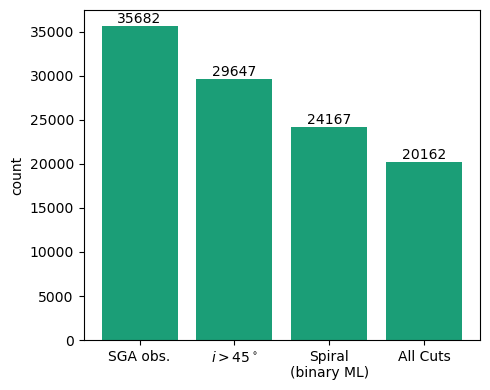

In [17]:
data = {
    'SGA obs.' : len(sgatab),
    # r'$10 < V_\mathrm{rot} < 1000$' : np.sum(is_good_velo),
    # r'$\Delta V/V_\mathrm{min}>5$' : np.sum(is_good_dv),
    r'$i > 45^\circ$' : np.sum(is_good_incl), 
    # 'Spiral' : np.sum(is_good_morph),
    'Spiral\n(binary ML)' : np.sum(is_good_morph_ML),
    'All Cuts' : np.sum(is_good_sga), 
    # 'All Cuts\n(binary ML)' : np.sum(is_good_sga_ML)
}
names = list(data.keys())
values = list(data.values())

fig, ax = plt.subplots(1, 1, figsize=(5,4), tight_layout=True)
bars = ax.bar(names, values)
ax.bar_label(bars, fmt='%d')
ax.set(ylabel='count');#, yscale='log', ylim=[1e3,1.2e4]);

# fig.savefig('../../Figures/Y3/TF_Y3_SGA_Vrot_cuts.png', dpi=150, facecolor='none');

# Photometric corrections

### Survey offsets

In [18]:
sys_corr, sys_corr_err = BASS_corr(sgatab['PHOTSYS'])

### Dust corrections

In [19]:
# Import E(B-V) dust map
ebv_directory = '/global/cfs/cdirs/desicollab/users/rongpu/dust/desi_ebv/public_data/maps/'
ebv_filename = 'desi_dust_gr_512.fits'
ebv_map = Table.read(ebv_directory + ebv_filename)

In [20]:
MWdust_corr, MWdust_corr_err = MW_dust(sgatab['RA'], sgatab['DEC'], ebv_map)

/global/homes/m/mjkeller/DESI_SGA/TF/TF_photoCorrect.py:90: UserWarning: Warning: converting a masked element to nan.
  EBV_err[i] = ebv_map['EBV_GR_ERR'][i_ebv]


In [21]:
# Flip NaN values to 0
MWdust_corr_err[np.isnan(MWdust_corr_err)] = 0

### $K$-corrections

In [22]:
# Apparently we have some galaxies with negative redshifts
zg0 = sgatab['Z_DESI'] >= 0

In [23]:
kcorr_zg0 = k_corr(sgatab['Z_DESI'][zg0], 
                   [sgatab['G_MAG_SB26'][zg0], sgatab['R_MAG_SB26'][zg0], sgatab['Z_MAG_SB26'][zg0]], 
                   [sgatab['G_MAG_SB26_ERR'][zg0], sgatab['R_MAG_SB26_ERR'][zg0], sgatab['Z_MAG_SB26_ERR'][zg0]], 
                   z_corr=0.1) # K-correcting to same redshift as FastSpecFit (which is what Caitlin's using for the FP)

In [24]:
kcorr = np.zeros([len(sgatab), 3])
kcorr[zg0] = kcorr_zg0

### Internal dust extinction correction

This is based off of a linear fit to ($b/a$, $m_r$), removing any correlation between $b/a$ and $m_r$. Note that this still uses the Y1 dust correction!

In [25]:
temp_infile = open('/global/homes/m/mjkeller/DESI_SGA/TF/Y3/jura_internalDust_mcmc.pickle', 'rb')
dust_mcmc_samples,_ = pickle.load(temp_infile)
temp_infile.close()

In [26]:
internalDust_coeffs = np.median(dust_mcmc_samples, axis=1)

internalDust_coeffs_err = np.zeros(len(internalDust_coeffs))
internalDust_coeffs_err[0] = np.std(dust_mcmc_samples[0][(-1.5 < dust_mcmc_samples[0]) & (dust_mcmc_samples[0] < 0)])
internalDust_coeffs_err[1] = np.std(dust_mcmc_samples[1][(0 < dust_mcmc_samples[1]) & (dust_mcmc_samples[1] < 1)])

In [27]:
internalDust_corr, internalDust_corr_err = internal_dust(sgatab['BA'], 
                                                         internalDust_coeffs, 
                                                         internalDust_coeffs_err)

## Apply corrections

In [28]:
sgatab['R_MAG_SB26_CORR'] = sgatab['R_MAG_SB26'] - MWdust_corr[1] + sys_corr + kcorr[:,1] - internalDust_corr

In [29]:
sgatab['R_MAG_SB26_ERR_CORR'] = np.sqrt(sgatab['R_MAG_SB26_ERR']**2 + MWdust_corr_err[1]**2 + sys_corr_err**2 + internalDust_corr_err**2)

## Load SN Ia Calibrators for the TFR Zero Point

List of SNe Ia from UNION3 and Pantheon+ from Anthony Carr. Match these to the SGA iron observations that have passed all quality cuts.

In [30]:
# zeroptpath = '../cache/'
# zeroptpath = '.'
zeroptab = Table.read('/global/homes/m/mjkeller/DESI_SGA/TF/SGA-2020_jura_Vrot_0pt_calib.fits')

In [31]:
#- Extract the 0-point SNe Ia that match SGA IDs in the good catalog (passed all rotation curve cuts).
#  Merge the tables so we can use the zero point later.
idx = np.in1d(zeroptab['SGA_ID'], sgatab['SGA_ID'][is_good_sga])
# zeroptab[['SGA_ID', 'MU_PRIMARY', 'MU_SECONDARY', 'MU_ERR', 'MU_SOURCE']][idx]

zeroptab = join(sgatab, zeroptab[['SGA_ID', 'MU_PRIMARY', 'MU_SECONDARY', 'MU_ERR', 'MU_SOURCE']][idx], keys='SGA_ID')

#- Write catalog to file
zeroptab.write('SGA_distances_0pt_jura_z0p1.fits', overwrite=True)
zeroptab[:5]

<Table length=5>
 SGA_ID     SGA_GALAXY            GALAXY         ...  MU_ERR    MU_SOURCE  
                                                 ...                       
float64      bytes16             bytes29         ... float64     bytes22   
-------- --------------- ----------------------- ... -------- -------------
103123.0 SGA-2020 103123 SDSSJ074708.56+275429.4 ... 0.251383     SN2017ckx
108851.0 SGA-2020 108851                UGC10459 ... 0.399302 2009eu+2009fv
109750.0 SGA-2020 109750               PGC007299 ... 0.173532        2005hc
111934.0 SGA-2020 111934              PGC1881940 ...  0.21848        2010ai
111967.0 SGA-2020 111967  2MASXJ16235396+4040218 ... 0.399302 2009eu+2009fv

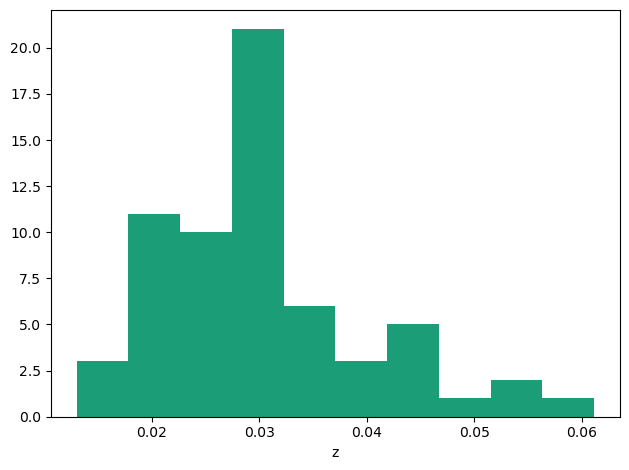

In [32]:
plt.figure(tight_layout=True)

plt.hist(zeroptab['Z_DESI'])

plt.xlabel('z');

In [33]:
# Only keep galaxies with a primary SN match
# zeroptab = zeroptab[~zeroptab['MU_PRIMARY'].mask]

In [34]:
np.unique(zeroptab['MU_SOURCE'], return_counts=True)

(<Column name='MU_SOURCE' dtype='bytes22' length=32>
        1999cc
        2000dg
        2001cj
        2001da
        2001ep
        2004bk
        2005hc
        2006az
        2006bt
        2006bw
        2006cq
        2007ba
           ...
 2013gy+2009kk
        2014ai
   ASASSN-15nr
   ASASSN-16ct
     AT2016bln
     AT2017cfc
       PS15aii
       PS16axi
       PS16ayd
       PS16bnz
        PS16fa
     SN2017ckx,
 array([ 1,  1,  1,  1,  1,  1,  1,  1,  2,  1,  1,  3,  3,  1,  1, 19,  1,
         4,  3,  1,  1,  1,  1,  1,  1,  2,  1,  2,  2,  1,  1,  1]))

### Plot the Zero Point Calibrators

Sky coordinates of the SNe with good DESI rotational velocities.

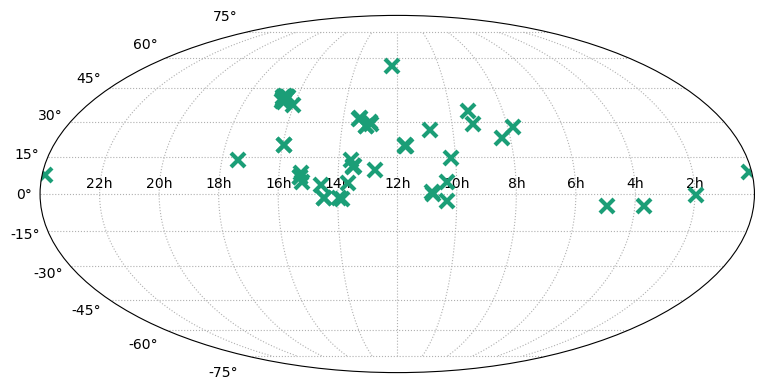

In [35]:
sne_coords = SkyCoord(ra=zeroptab['RA'], dec=zeroptab['DEC'], frame='icrs', unit='deg')

fig, ax = plt.subplots(figsize=(10,4), tight_layout=True, subplot_kw={'projection' : 'mollweide'})
_ra = np.radians(180*u.deg - sne_coords.ra)
_dec = np.radians(sne_coords.dec)
ax.plot(_ra, _dec, 'x', ms=10, mew=3)

ax.set(xticklabels=[f'{_}h' for _ in np.arange(2,24, 2)][::-1])
ax.grid(ls=':');

# fig.savefig('../../Figures/Y3/TF_Y3_SGA_Vrot_SNIa_calibrators.png', dpi=150);

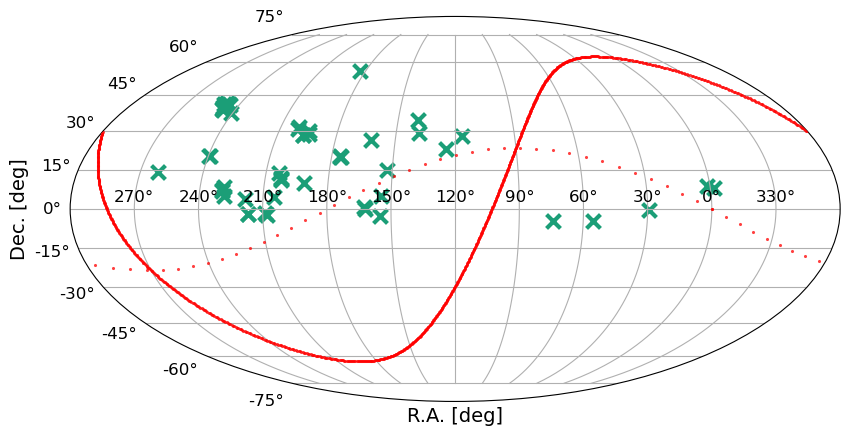

In [36]:
ax = init_sky()

ax.scatter(ax.projection_ra(sne_coords.ra.value), 
           ax.projection_dec(sne_coords.dec.value), 
           marker='x', 
           s=100,
           linewidth=3)

ax.xaxis.label.set_size(14)
ax.yaxis.label.set_size(14)

plt.tick_params(axis='both', which='major', labelsize=12)

# plt.savefig('../../Figures/Y3/jura_0pt_sky.png', dpi=150, facecolor='none');

### Compute the Absolute Magnitude of the 0-pt Calibrators based on the Distance

Compute the absolute magnitude
$$
M_r - 5\log{h} = m_r - \mu - 5\log{h},
$$
where $h$ is the reduced Hubble constant used to calibrate the distance modulus $\mu$.

Since our calibrators are from Pantheon+SH0ES, where distances are based on the distance ladder, there is no assumed value of $h$.

In [37]:
#- Clean up the distance modulus
use_primary = zeroptab['MU_SECONDARY'] < 0
mu = zeroptab['MU_SECONDARY']
mu[use_primary] = zeroptab['MU_PRIMARY'][use_primary]
# mu = zeroptab['MU_PRIMARY']

#- Compute the absolute magnitude
zeroptab['R_ABSMAG_SB26'] = zeroptab['R_MAG_SB26_CORR'] - mu
zeroptab['R_ABSMAG_SB26_err'] = np.sqrt(zeroptab['R_MAG_SB26_ERR_CORR']**2 + zeroptab['MU_ERR']**2)

In [38]:
# Save this table
zeroptab.write('SGA-2020_iron_Vrot_VI_0pt_calib_z0p1.fits', overwrite=True)

# Access Cluster Catalog

These clusters come from the group catalog used by Kourkchi et al. in [*CosmicFlows-4: The Calibration of Optical and Infrared Tully-Fisher Relations*](https://iopscience.iop.org/article/10.3847/1538-4357/ab901c), ApJ 896:3, 2020.

Cluster membership is defined as
1. $R_p < 1.5R_{2t}$ AND $v < V_c \pm 3\sigma_p$, OR
1. $1.5R_{2t} \leq R_p < 3R_{2t}$ AND $v < V_c \pm 2\sigma_p$

where $R_p$ is the projected distance from the center of the cluster, $R_{2t}$ is the projected cluster second turnaround radius, $\sigma_p$ is the projected velocity dispersion of the cluster, and $V_c$ is the average heliocentric radial velocity of the cluster.

In [39]:
clusters = Table.read('../Tully15-Table3.fits')
clusters[:5]

<Table length=5>
f_Nest  Nest   Nmb    PGC1   SGLON   ...  sigV    R2t    sigP     Mlum      CF  
                              deg    ... km / s   Mpc   km / s    Msun          
int16  int32  int16  int32  float64  ... int16  float64 int16   float64  float64
------ ------ ----- ------- -------- ... ------ ------- ------ --------- -------
     1 100001   136   44715  89.6226 ...    886   2.129   1045 1.710e+15    1.65
     1 100002   197   41220 103.0008 ...    670   1.440    707 5.290e+14    1.00
     1 100003   113   43296 156.2336 ...    822   1.520    746 6.230e+14    1.12
     1 100004    81   58265  71.5103 ...    740   2.153   1057 1.770e+15    2.26
     1 100005    61   36487  92.0255 ...    707   1.560    766 6.730e+14    1.58

# Find Cluster Membership

Identify SGA galaxies in the list of galaxy groups from Tully (2015).

Loop through the data and keep only clusters where DESI has at least 20 galaxies with TF measurements passing all quality cuts.

In [40]:
#- Sky coordinates of SGA galaxies that passed quality selection
sgatab_sel = sgatab[is_good_sga]
print(len(sgatab_sel))

sga_coords = SkyCoord(sgatab_sel['RA'], sgatab_sel['DEC'], unit='deg')
z_sga_desi = sgatab_sel['Z_DESI']

20162


In [41]:
sga_clusters = {}
m_dwarf_clusters = {}
n_cluster_min = 20

# for cluster in tqdm(clusters[['Nest', 'SGLON', 'SGLAT', 'R2t', 'sigP', 'DM']]):
for i in tqdm(range(len(clusters))):
    nest_id = clusters['Nest'][i]
    
    #- Sky coordinates of cluster
    cls_coord = SkyCoord(clusters['SGLON'][i], 
                         clusters['SGLAT'][i], 
                         unit='deg', 
                         frame='supergalactic')

    #- Cluster turnaround radius, velocity dispersion, and distance modulus
    R2t = clusters['R2t'][i]
    sigP = clusters['sigP'][i]
    mu = clusters['DM'][i]

    #- Convert distance moduli to velocities [in km/s]
    dist = 10 * 10**(0.2*mu)
    velo = 100 * (dist*1e-6) # Tully used H0 = 100 km/s/Mpc, which is why we are using 100 here and not H0 

    #- Apply cuts on angular separation
    sep = cls_coord.separation(sga_coords)
    R2t_angle_1p5 = np.arctan(1.5*R2t / (velo/H0)) * u.radian
    R2t_angle_3 = np.arctan(3*R2t / (velo/H0)) * u.radian

    #- Apply cluster cuts.
    in_cluster_1 = (sep < R2t_angle_1p5) & (z_sga_desi*c_kms > velo - 3*sigP) & (z_sga_desi*c_kms < velo + 3*sigP)
    in_cluster_2 = (sep >= R2t_angle_1p5) & (sep < R2t_angle_3) & (z_sga_desi*c_kms > velo - 2*sigP) & (z_sga_desi*c_kms < velo + 2*sigP)
    in_cluster = in_cluster_1 | in_cluster_2

    if np.any(in_cluster) and np.sum(in_cluster) >= n_cluster_min:
        if nest_id in sga_clusters:
            warnings.warn(f'Cluster ID {nest_id} already encountered.', RuntimeWarning)
        sga_clusters[nest_id] = list(sgatab_sel['SGA_ID'][in_cluster])
        m_dwarf_clusters[nest_id] = -17 + mu

100%|██████████| 25474/25474 [09:04<00:00, 46.83it/s]


In [42]:
for i, (cluster_id, sga_ids) in enumerate(sga_clusters.items()):
    print(f'{i+1:2d} {cluster_id:7d} {len(sga_ids):3d} galaxies')

 1  100001  20 galaxies
 2  100002  34 galaxies
 3  100004  61 galaxies
 4  100007 108 galaxies
 5  100016  24 galaxies
 6  100041  24 galaxies
 7  100046  21 galaxies
 8  100067  30 galaxies
 9  100077  53 galaxies
10  100125  21 galaxies
11  100132  20 galaxies
12  100221  20 galaxies
13  100282  67 galaxies
14  100526  33 galaxies
15  100527  25 galaxies
16  100952  26 galaxies
17  100991  20 galaxies
18  101400  26 galaxies
19  101591  22 galaxies
20  101788  24 galaxies
21  101823  41 galaxies
22  103172  21 galaxies
23  103175  37 galaxies
24  103182  29 galaxies
25  103203  20 galaxies
26  103206  20 galaxies
27  103229  23 galaxies
28  103584  25 galaxies
29  200043  29 galaxies
30  200284  30 galaxies
31  200382  29 galaxies
32  200386  44 galaxies
33  200573  22 galaxies


## Sanity Checks: Plot Cluster Positions and Galaxy Coordinates

[ True  True False ... False False False]


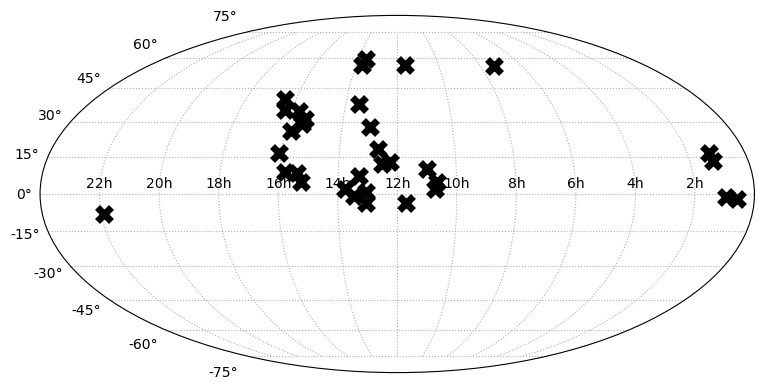

In [43]:
nest_ids = np.asarray(list(sga_clusters.keys()))
idx = np.in1d(clusters['Nest'], nest_ids)
print(idx)
cluster_lon = clusters['SGLON'][idx]
cluster_lat = clusters['SGLAT'][idx]
cluster_coords = SkyCoord(cluster_lon, cluster_lat, unit='deg', frame='supergalactic')

fig, ax = plt.subplots(figsize=(10,4), tight_layout=True, subplot_kw={'projection' : 'mollweide'})
for coord in cluster_coords:
    _ra = np.radians(180*u.deg - coord.transform_to('icrs').ra)
    _dec = np.radians(coord.transform_to('icrs').dec)
    ax.plot(_ra, _dec, 'kx', ms=10, mew=5)

ax.set(xticklabels=[f'{_}h' for _ in np.arange(2,24, 2)][::-1])
ax.grid(ls=':');
# fig.savefig('../../Figures/Y1/TF_Y1_SGA_Vrot_clusters_20241203.png', dpi=150);

In [44]:
def geometric_median(X, eps=1e-6):
    """Compute the weighted geometric median of a set of points using Weiszfeld's algorithm.

    From https://github.com/scoutant/l1-median. Weiszfeld's algorithm may fail to converge
    if a guess is located on top of one of the initial points. If that occurs, move the guess.
    
    A summary of other algorithms is provided in
    https://www.cs.cmu.edu/~./glmiller/Publications/Papers/CLMPS16.pdf.

    Parameters
    ----------
    X : ndarray
        list of sample points (n-D), given as a 2D array
    eps : float
        Tolerance for convergence to the median.

    Returns
    -------
    y : ndarray
        First n-D estimate of the median satisfying the tolerance.
    """
    #- See with the geometric mean
    y = np.mean(X,0)
    while True:
        #- Compute Euclidean distances. Move away to avoid any null distances.
        while np.any(cdist(X,[y])==0):
            y +=0.1*np.ones(len(y))
            
        #- Weights that are the inverse of the distances from current estimate to the observations
        W = 1/cdist(X,[y]) # element-wise
        
        #- Update is the weighted average of the observations
        y1 = np.sum(W*X,0)/np.sum(W) # sum along axis 0
        if euclidean(y,y1) < eps:
            return y1
        y = y1

def cluster_median_coords(galaxy_coords):
    """Compute the geometric median coordinate of the galaxies in a cluster.

    Parameters
    ----------
    galaxy_coords : ndarray
        List of SkyCoords for galaxies in a cluster or group.

    Returns
    -------
    gal_median : SkyCoord
        Coordinates of the geometric median.
    """
    #- Pack the clusters coordinates into an array of Cartesian coordinates
    galcoords = []
    for galaxy in galaxy_coords:
        galcoords.append(galaxy.represent_as('cartesian').get_xyz())
    galcoords = np.asarray(galcoords)

    #- Compute the geometric median.
    gm = geometric_median(galcoords)
    lonlat = SkyCoord(x=gm[0], y=gm[1], z=gm[2], representation_type='cartesian').transform_to('icrs').represent_as('unitspherical')
    gal_median = SkyCoord(ra=lonlat.lon.deg, dec=lonlat.lat.deg, unit='degree', frame='icrs')

    return gal_median

In [45]:
def plot_cluster_members(clusters, cluster_id, sgacat, sga_ids):
    """Generate a set of diagnostic plots for the members of a cluster.
    """
    colors = plt.get_cmap('Dark2').colors
    #- Get cluster sky coordinates
    idx = np.in1d(clusters['Nest'], cluster_id)
    cluster_lon = clusters['SGLON'][idx][0]
    cluster_lat = clusters['SGLAT'][idx][0]
    cluster_mu = clusters['DM'][idx][0]
    cluster_dist = 10 * 10**(0.2*cluster_mu) * 1e-6
    cluster_v = H0*cluster_dist
    cluster_sigma = clusters['sigP'][idx][0]
    cluster_R2t = clusters['R2t'][idx][0]
    cluster_R2t_1p5 = np.arctan(1.5*cluster_R2t / (cluster_v/H0)) * u.radian
    cluster_R2t_3 = np.arctan(3*cluster_R2t / (cluster_v/H0)) * u.radian
    cluster_R2t_4 = np.arctan(4*cluster_R2t / (cluster_v/H0)) * u.radian
    
    cluster_coord = SkyCoord(cluster_lon, cluster_lat, unit='deg', frame='supergalactic').transform_to('icrs')

    print(cluster_coord)
    print(f'{cluster_v} +/- {cluster_sigma} km/s')

    #- Get SGA galaxy coordinates and median of observations
    idx = np.in1d(sgacat['SGA_ID'], sga_ids)
    z_sga = sgacat['Z_DESI'][idx]
    z_sorted = np.sort(z_sga)
    ngal = len(z_sorted)
    z_sga_median = np.mean(z_sorted[ngal//2:ngal//2 + 2]) if (ngal % 2 == 0) else z_sorted[ngal//2]
    
    sga_coords = SkyCoord(ra=sgacat['RA'][idx], dec=sgacat['DEC'][idx], unit='deg', frame='icrs')
    sga_coords_median = cluster_median_coords(sga_coords)

    #- Plot the angular coordinates and redshifts
    fig = plt.figure(figsize=(12,8), tight_layout=True)
    ax = plt.subplot(231, projection='astro degrees zoom', center=cluster_coord, radius=cluster_R2t_4)
    ax.grid()

    ax.plot(sga_coords.ra.deg, sga_coords.dec.deg, 'o', transform=ax.get_transform('world'), alpha=0.5, label=f'{cluster_id}')
    ax.plot(sga_coords_median.ra.deg, sga_coords_median.dec.deg, 'D', color = colors[1], transform=ax.get_transform('world'), ms=5, mew=5)
    ax.plot(cluster_coord.ra.deg, cluster_coord.dec.deg, 'kx', transform=ax.get_transform('world'), ms=10, mew=5)

    inner = SphericalCircle(cluster_coord, cluster_R2t_1p5, transform=ax.get_transform('world'), edgecolor=colors[7], linestyle='dotted', facecolor='none')
    ax.add_patch(inner)

    outer = SphericalCircle(cluster_coord, cluster_R2t_3, transform=ax.get_transform('world'), edgecolor=colors[7], linestyle='solid', facecolor='none')
    ax.add_patch(outer)
    
    ax.set(xlabel=r'$\alpha$ [deg]', ylabel=r'$\delta$ [deg]')

    #- Plot the Dec vs redshift and velocity limits
    ax = plt.subplot(232)
    ax.plot(z_sga, sga_coords.dec.deg, 'o', alpha=0.5, label=f'{cluster_id}')
    ax.plot(z_sga_median, sga_coords_median.dec.deg, 'D', color = colors[1], ms=5, mew=5)
    ax.plot(cluster_v/c_kms, cluster_coord.dec.deg, 'kx', ms=10, mew=5)

    decmin = np.min(sga_coords.dec.deg) - 0.5
    decmax = np.max(sga_coords.dec.deg) + 0.5

    ax.vlines(np.asarray([cluster_v-3*cluster_sigma,
                          cluster_v+3*cluster_sigma,
                          cluster_v-2*cluster_sigma,
                          cluster_v+2*cluster_sigma])/c_kms,
              decmin, decmax,
              colors=colors[7],
              linestyles=['solid', 'solid', 'dotted', 'dotted'])

    ax.set(xlabel='redshift',
           ylabel=r'$\delta$ [deg]',
           ylim=(decmin, decmax))

    #- Plot the RA vs redshift and velocity limits
    ax = plt.subplot(233)
    ax.plot(sga_coords.ra.deg, z_sga, 'o', alpha=0.5, label=f'{cluster_id}')
    ax.plot(sga_coords_median.ra.deg, z_sga_median, 'D', color = colors[1], ms=5, mew=5)
    ax.plot(cluster_coord.ra.deg, cluster_v/c_kms, 'kx', ms=10, mew=5)

    ramin = np.min(sga_coords.ra.deg) - 0.5
    ramax = np.max(sga_coords.ra.deg) + 0.5

    ax.hlines(np.asarray([cluster_v-3*cluster_sigma,
                          cluster_v+3*cluster_sigma,
                          cluster_v-2*cluster_sigma,
                          cluster_v+2*cluster_sigma])/c_kms,
              ramin, ramax,
              colors=colors[7],
              linestyles=['solid', 'solid', 'dotted', 'dotted'])

    ax.set(ylabel='redshift',
           xlabel=r'$\alpha$ [deg]',
           xlim=(ramax, ramin))

    #- Histograms of RA, Dec, and redshift:
    delta_angle = 0.75
    
    ax = plt.subplot(234)
    ax.hist(sga_coords.ra.deg, bins=np.arange(ramin, ramax+delta_angle, delta_angle))
    ax.vlines(sga_coords_median.ra.deg, 0, 50, colors=colors[1], linestyles='dotted')
    ax.vlines(cluster_coord.ra.deg, 0, 50, colors='k', linestyles='dotted')
    ax.set(xlabel=r'$\alpha$ [deg]',
           xlim=(ramax+delta_angle, ramin-delta_angle),
           ylabel='count',
           ylim=(0,10))

    ax = plt.subplot(235)
    ax.hist(sga_coords.dec.deg, bins=np.arange(decmin, decmax+delta_angle, delta_angle))
    ax.vlines(sga_coords_median.dec.deg, 0, 50, colors=colors[1], linestyles='dotted')
    ax.vlines(cluster_coord.dec.deg, 0, 50, colors='k', linestyles='dotted')
    ax.set(xlabel=r'$\delta$ [deg]',
           xlim=(decmax+delta_angle, decmin-delta_angle),
           ylabel='count',
           ylim=(0,10))

    dz = 0.0025
    zmin = np.min(np.round(z_sga, 2)) - 4*dz
    zmax = np.max(np.round(z_sga, 2)) + 4*dz

    ax = plt.subplot(236)
    ax.hist(z_sga, bins=np.arange(zmin, zmax + dz, dz))
    ax.vlines(z_sga_median, 0, 50, colors=colors[1], linestyles='dotted')
    ax.vlines(cluster_v/c_kms, 0, 50, colors='k', linestyles='dotted')
    ax.set(xlabel='redshift',
           xlim=(zmin, zmax),
           ylabel='count',
           ylim=(0,10))

    fig.suptitle(f'TF Jura Observations of Tully Group {cluster_id}')

    return fig

<SkyCoord (ICRS): (ra, dec) in deg
    (194.75582168, 27.93269246)>
7345.138681571143 +/- 1045 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (187.76381061, 12.28264393)>
1492.7944095789974 +/- 707 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (246.98584602, 40.22479396)>
9418.895965228417 +/- 1057 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (241.05808519, 16.95441739)>
11587.773561551261 +/- 1385 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (110.17218675, 55.6898024)>
12022.64434617413 +/- 1037 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (244.29362068, 35.02777805)>
9418.895965228417 +/- 627 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (230.75880839, 8.56052159)>
10914.403364487573 +/- 714 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (228.80657754, 4.74840124)>
11587.773561551261 +/- 954 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (174.18925473, 56.12464342)>
18281.002161427445 +/- 1914 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (164.82189669, 10.09092567)>
11066.237839776675 +/- 744 km/s
<S

/tmp/ipykernel_1256567/805910609.py:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(12,8), tight_layout=True)


<SkyCoord (ICRS): (ra, dec) in deg
    (230.99936671, 31.21107645)>
23550.492838960086 +/- 1707 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (206.10730715, 2.1097726)>
23120.647901755987 +/- 1693 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (236.07424061, 34.69623742)>
22803.420720004207 +/- 1458 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (195.74616921, -3.87530193)>
23550.492838960086 +/- 1529 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (201.84149945, -1.00863004)>
23768.402866248827 +/- 1465 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (202.33739481, 37.62288797)>
17782.794100389227 +/- 783 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (14.13239492, -1.08658284)>
13243.415351946644 +/- 1077 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (17.93151711, 13.53834251)>
16904.409316432666 +/- 1285 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (328.77363049, -8.05653143)>
20044.72027365159 +/- 2055 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (18.44359042, 16.98990087)>
19860.949173573757 +/- 2303 km

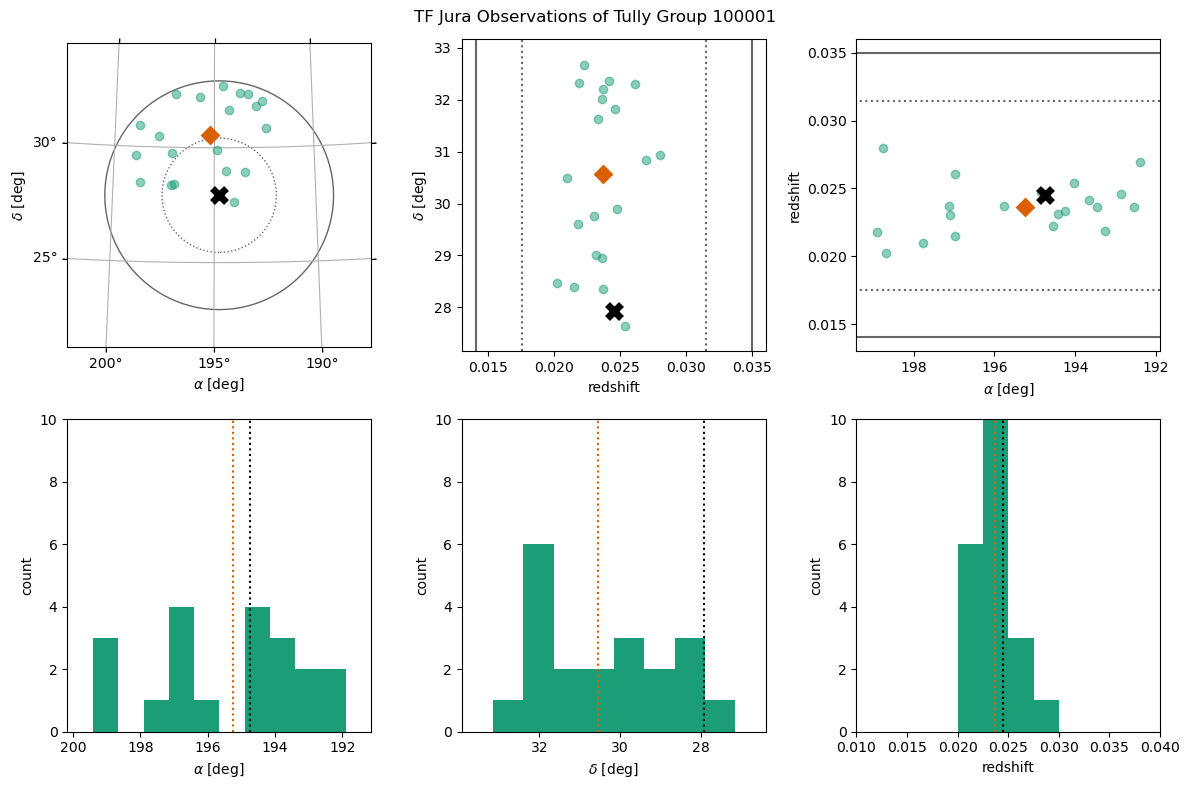

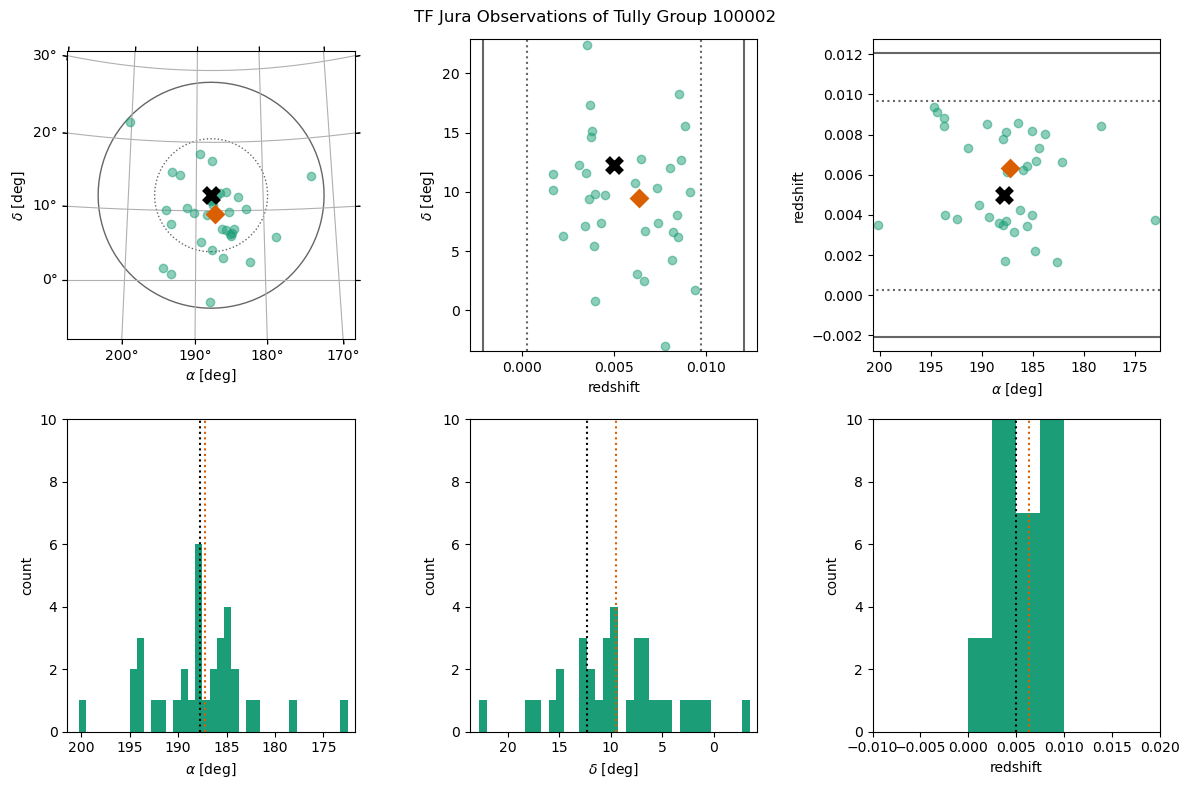

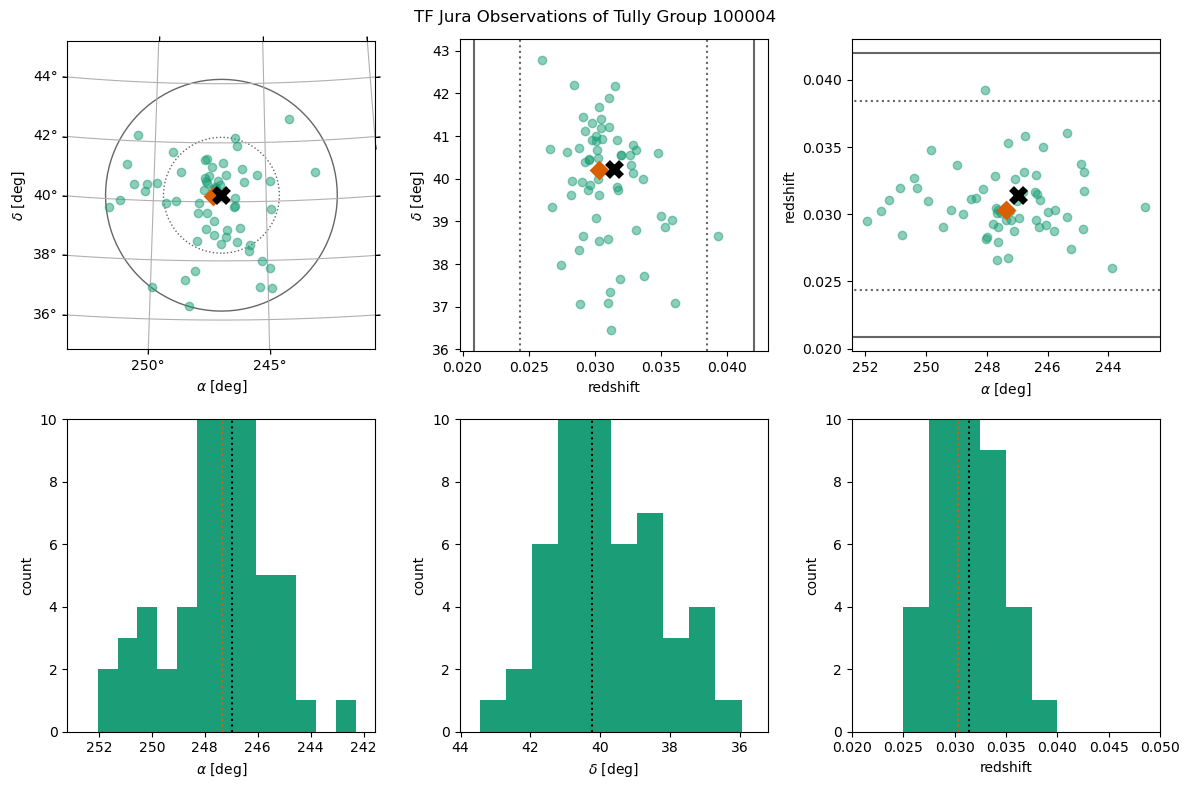

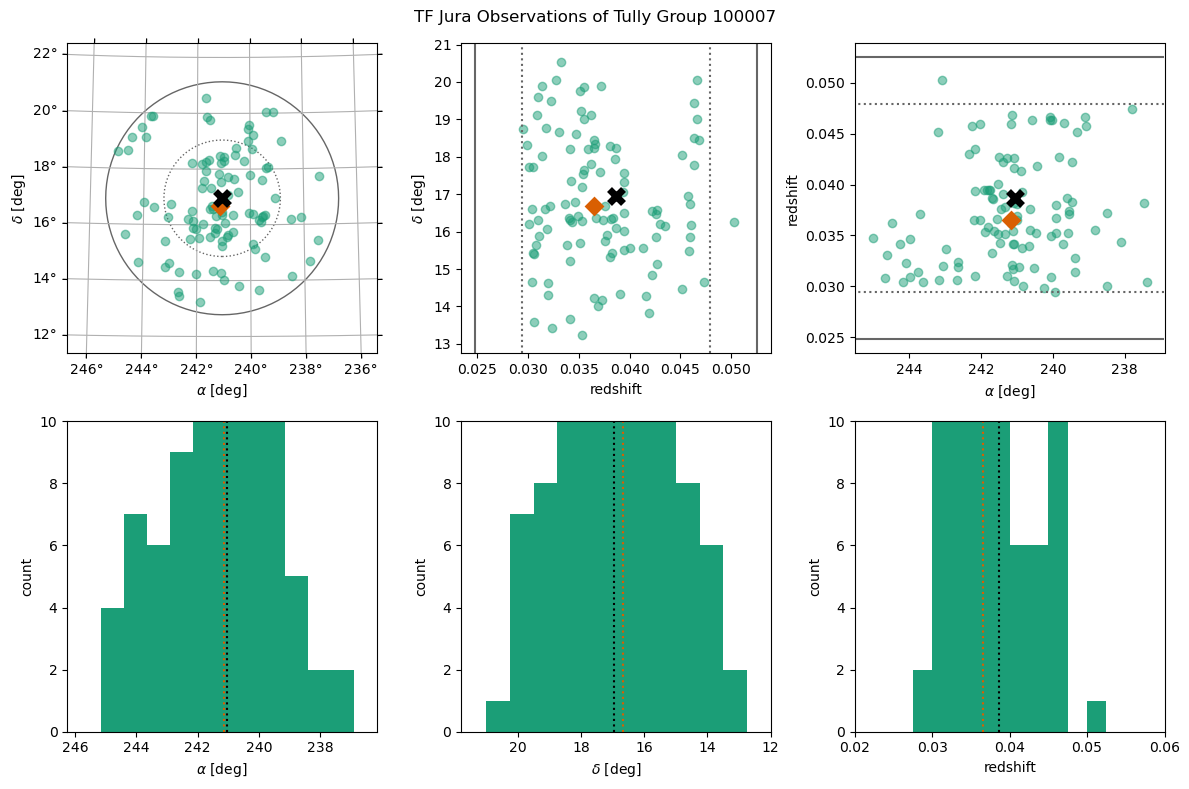

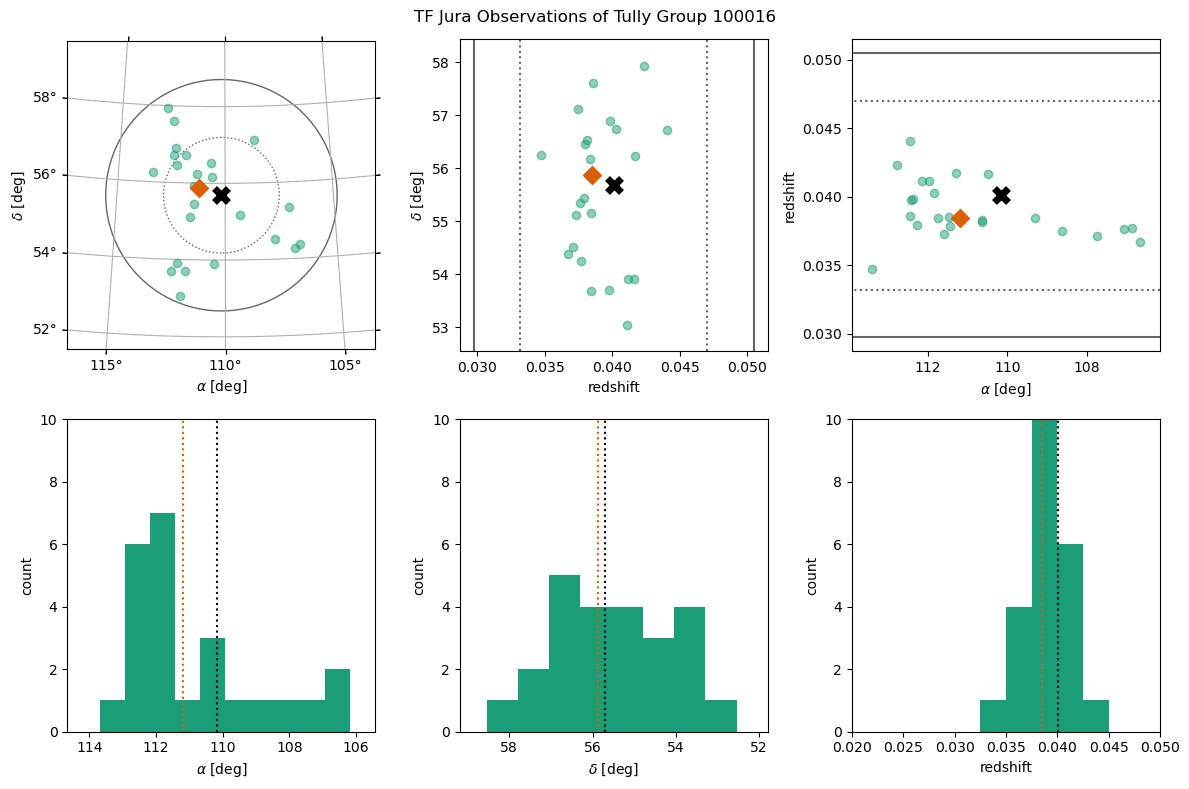

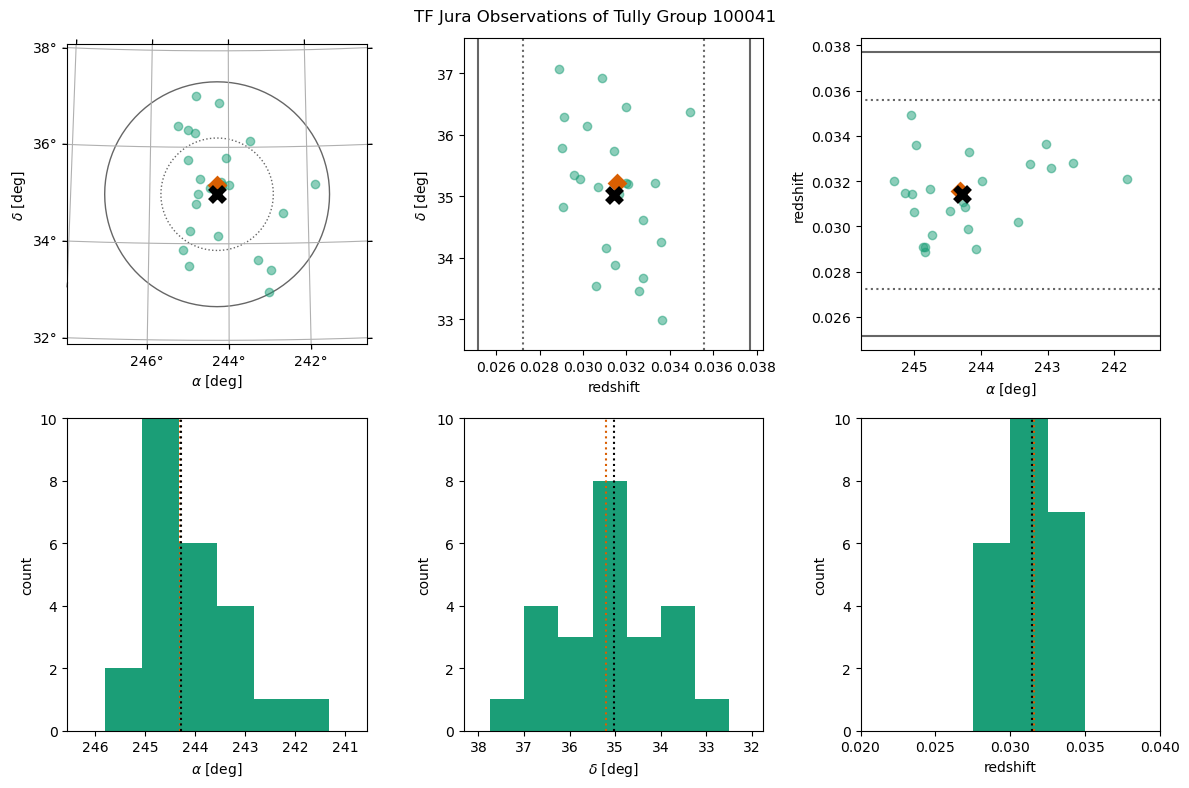

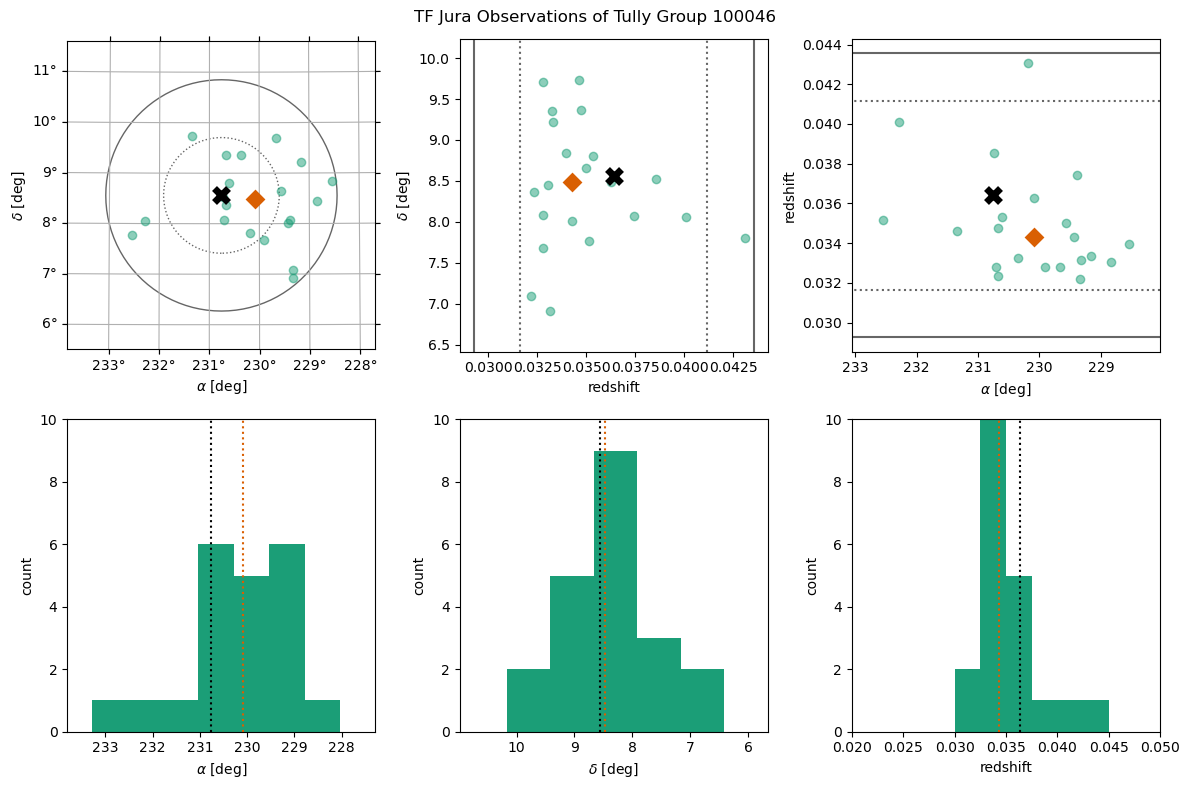

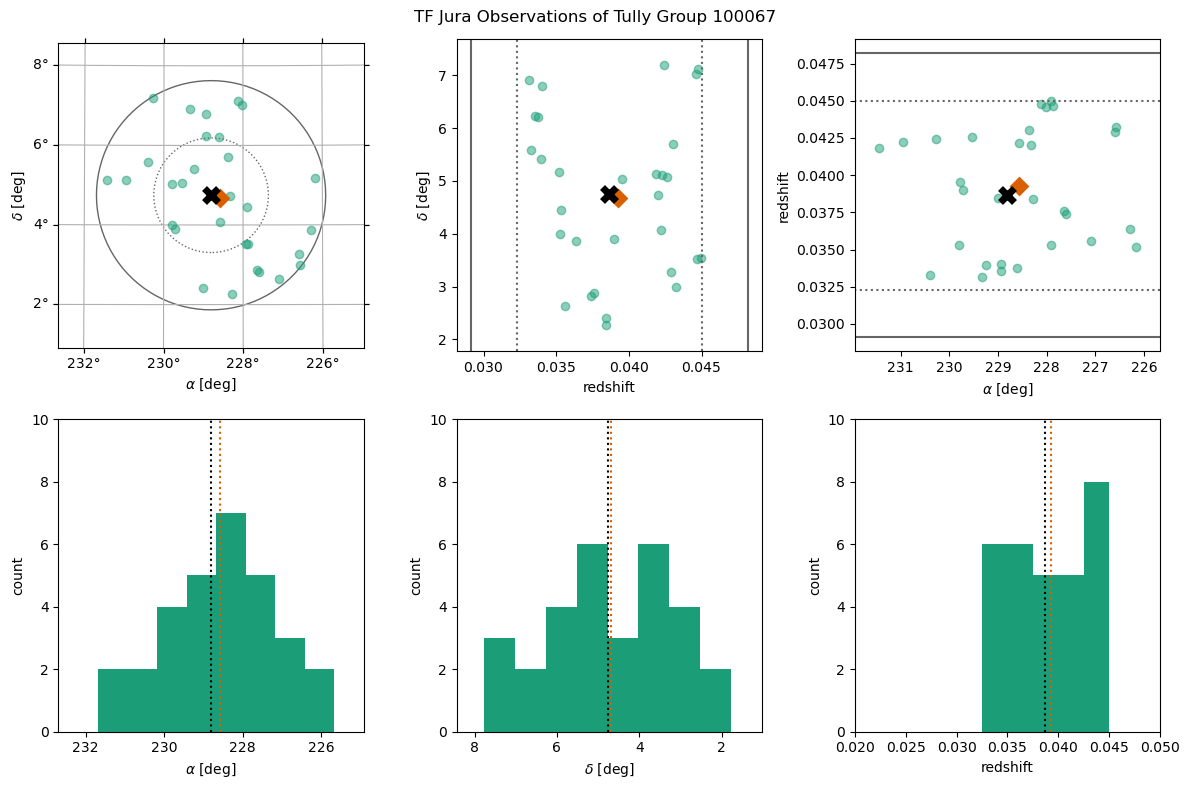

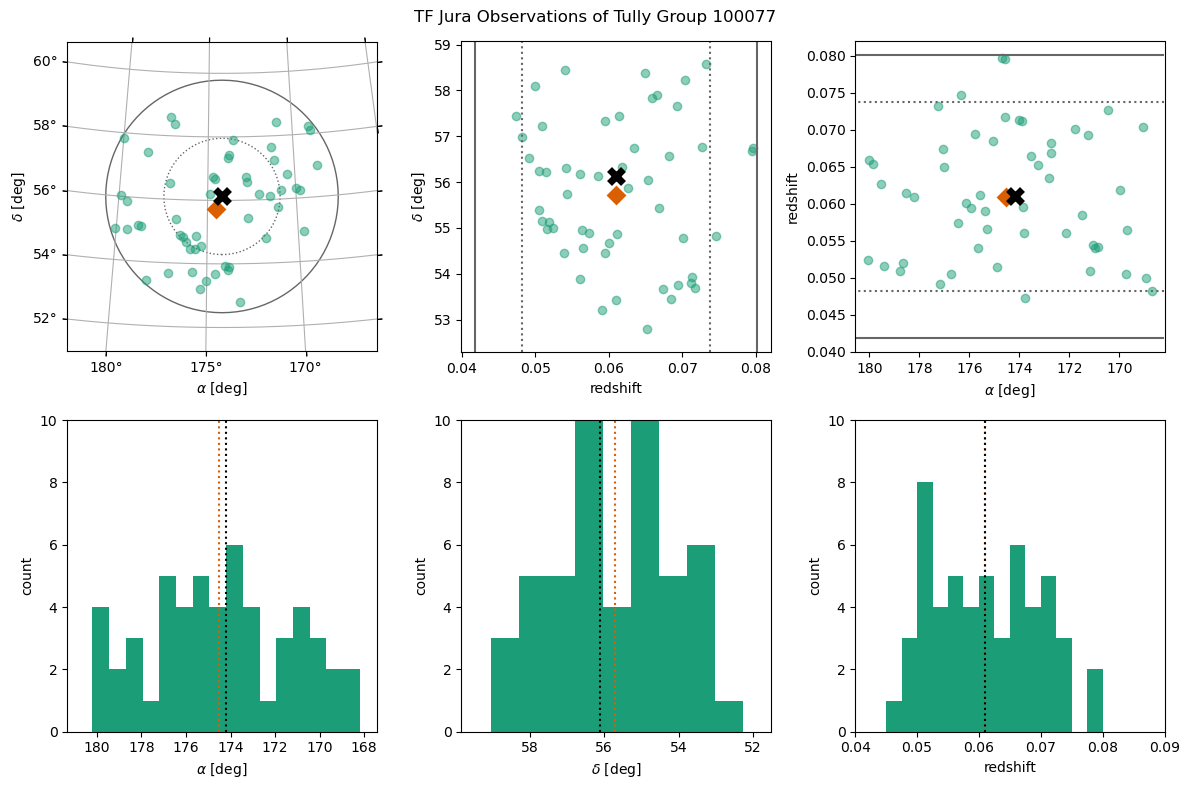

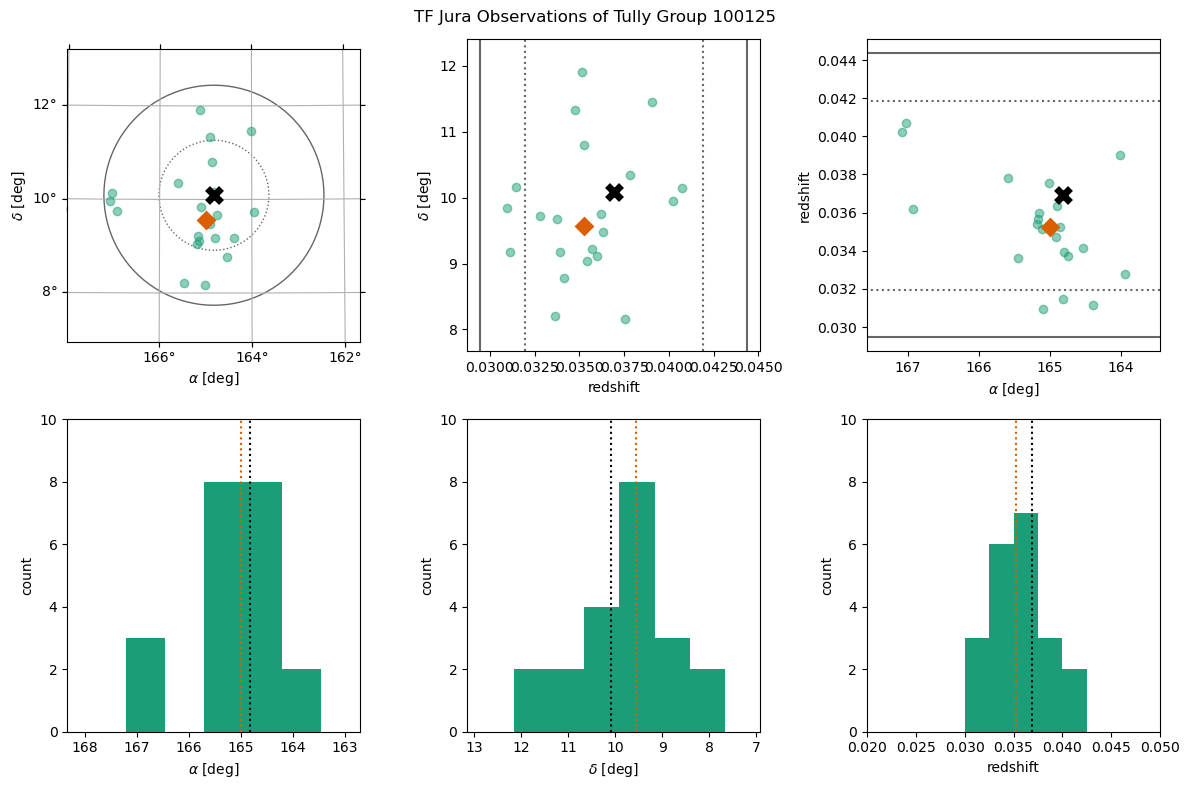

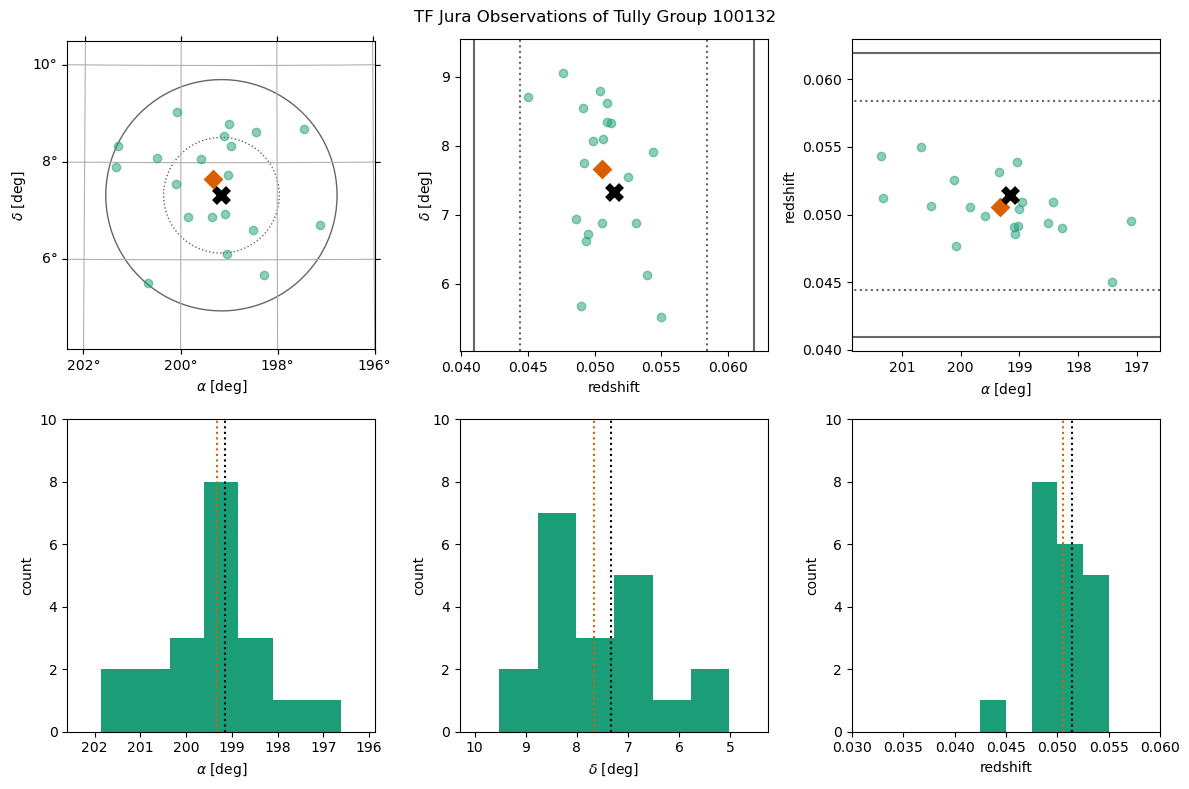

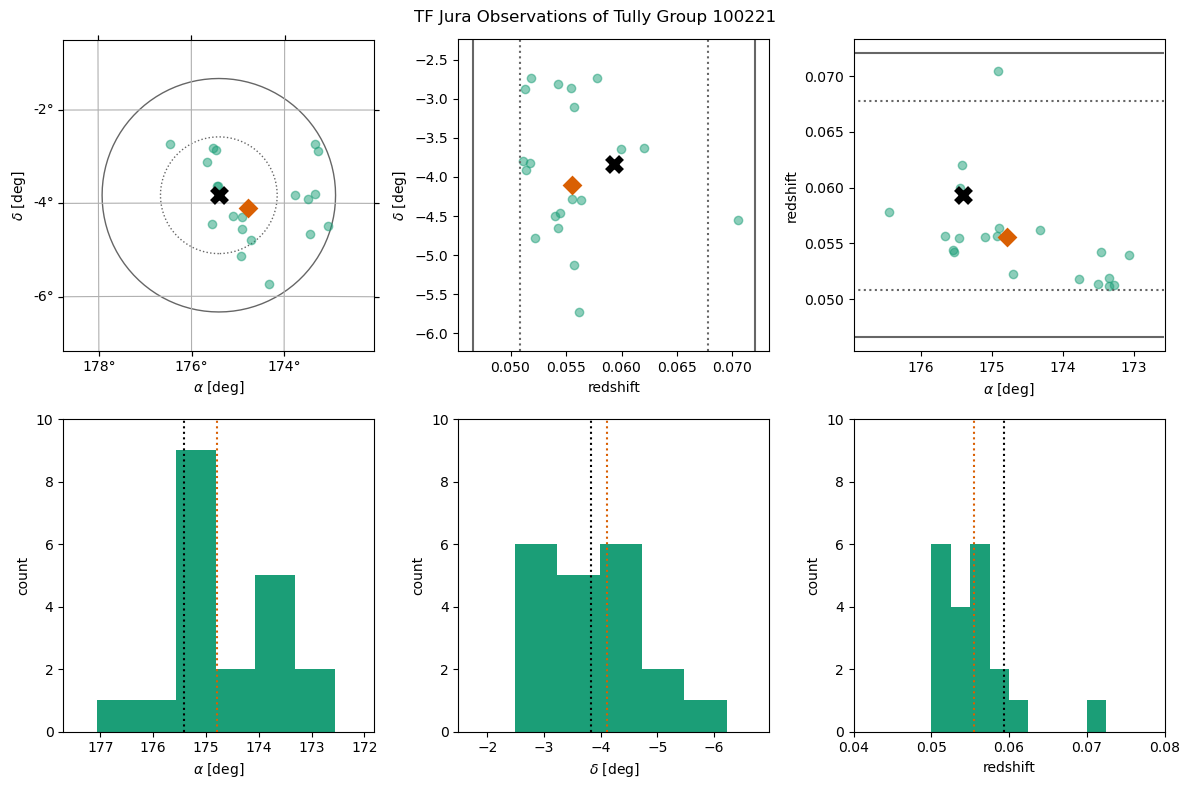

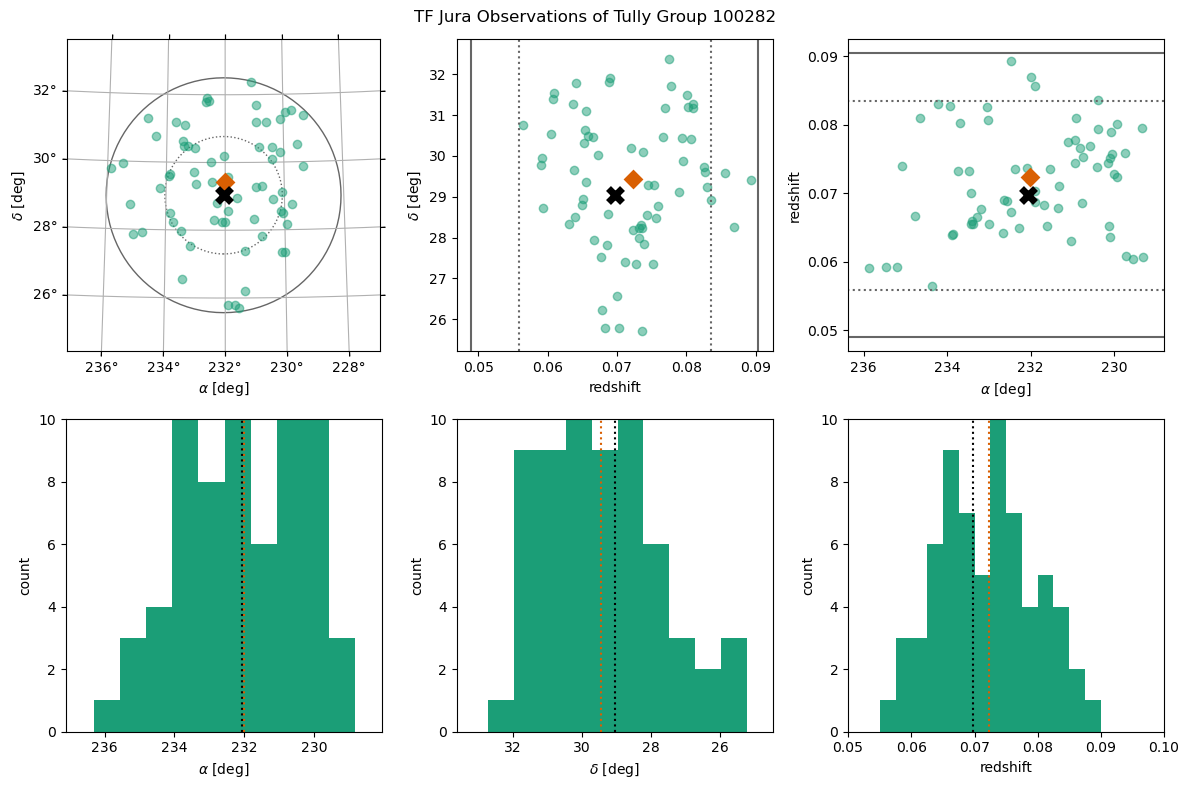

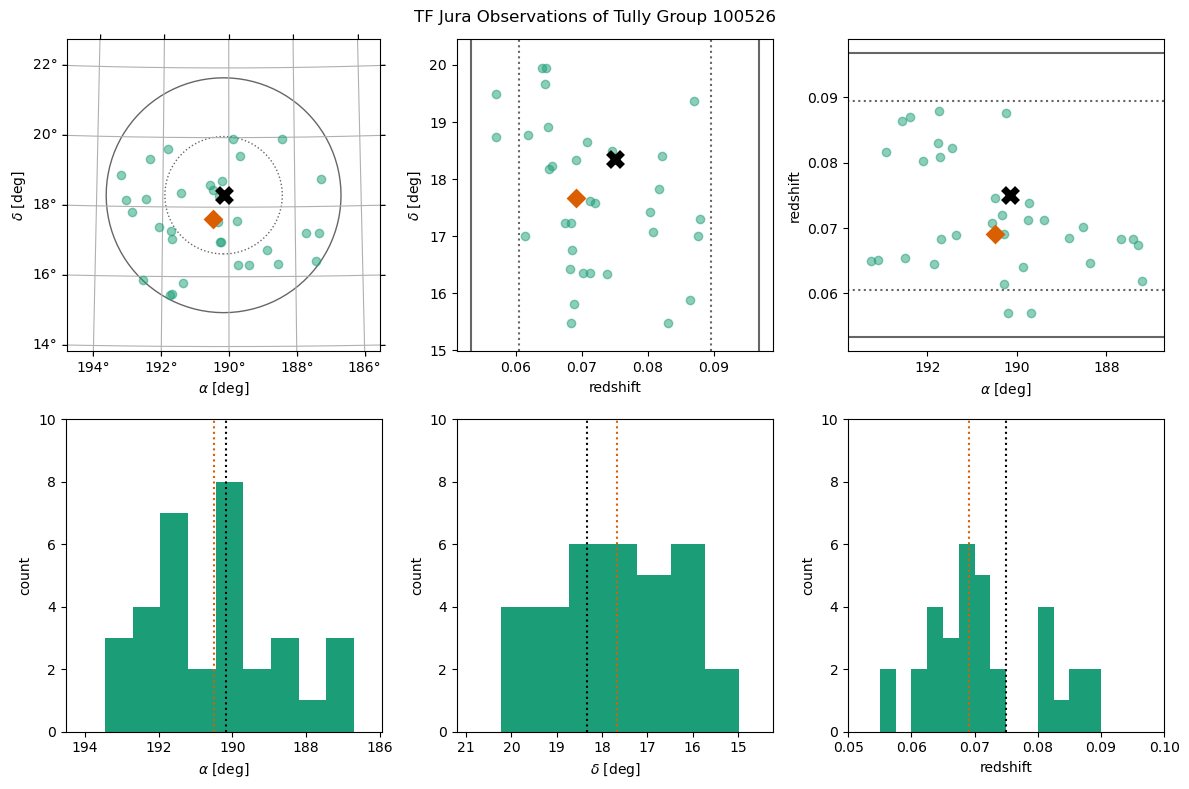

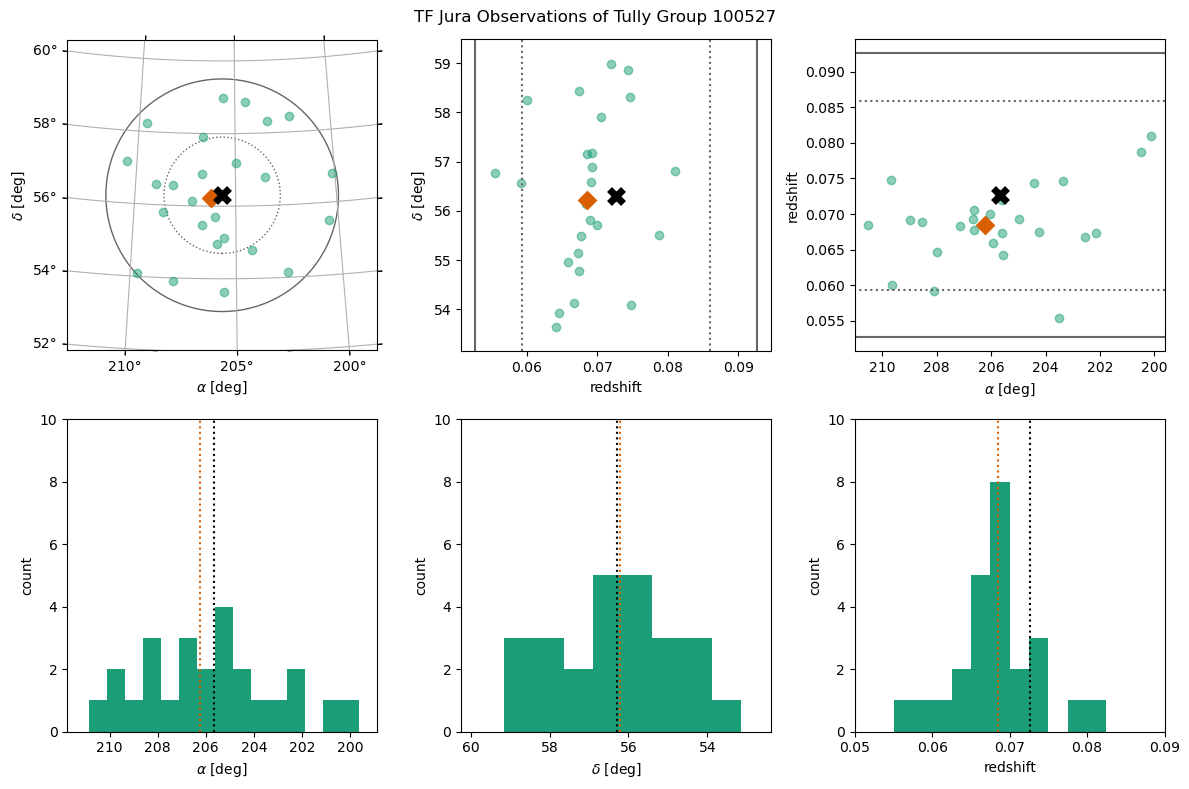

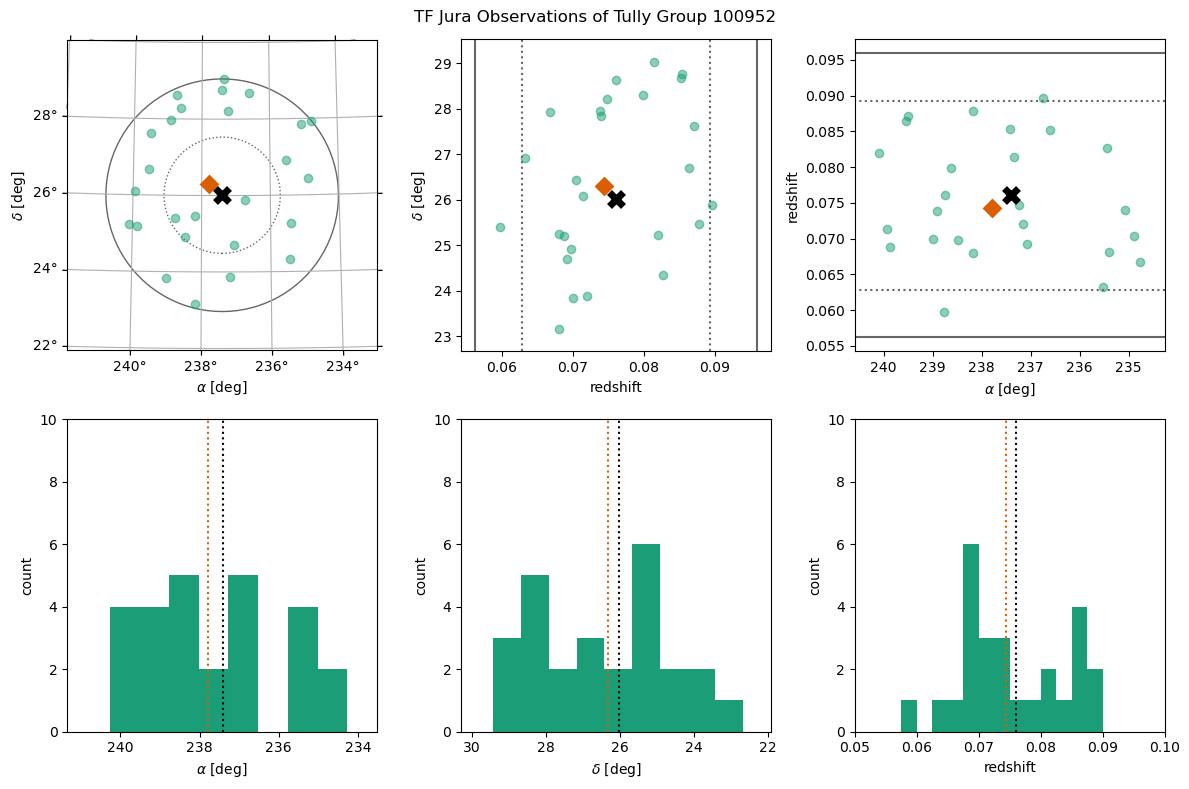

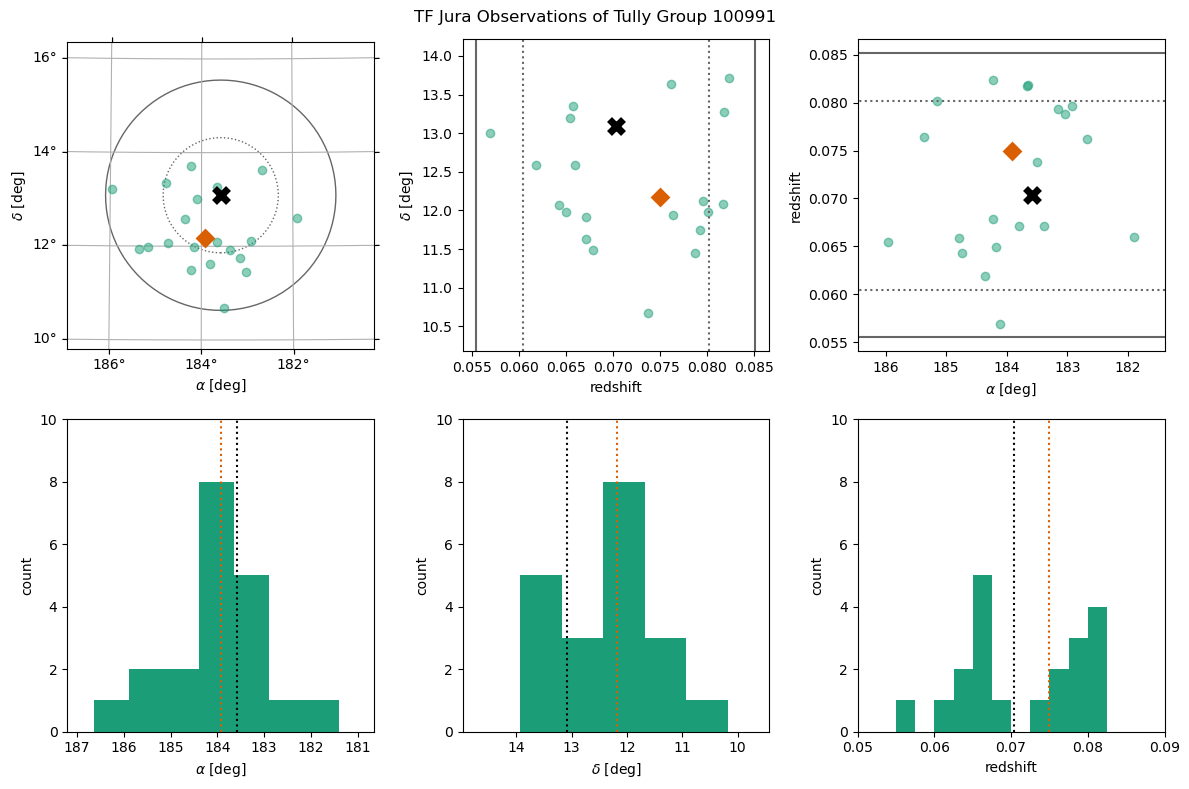

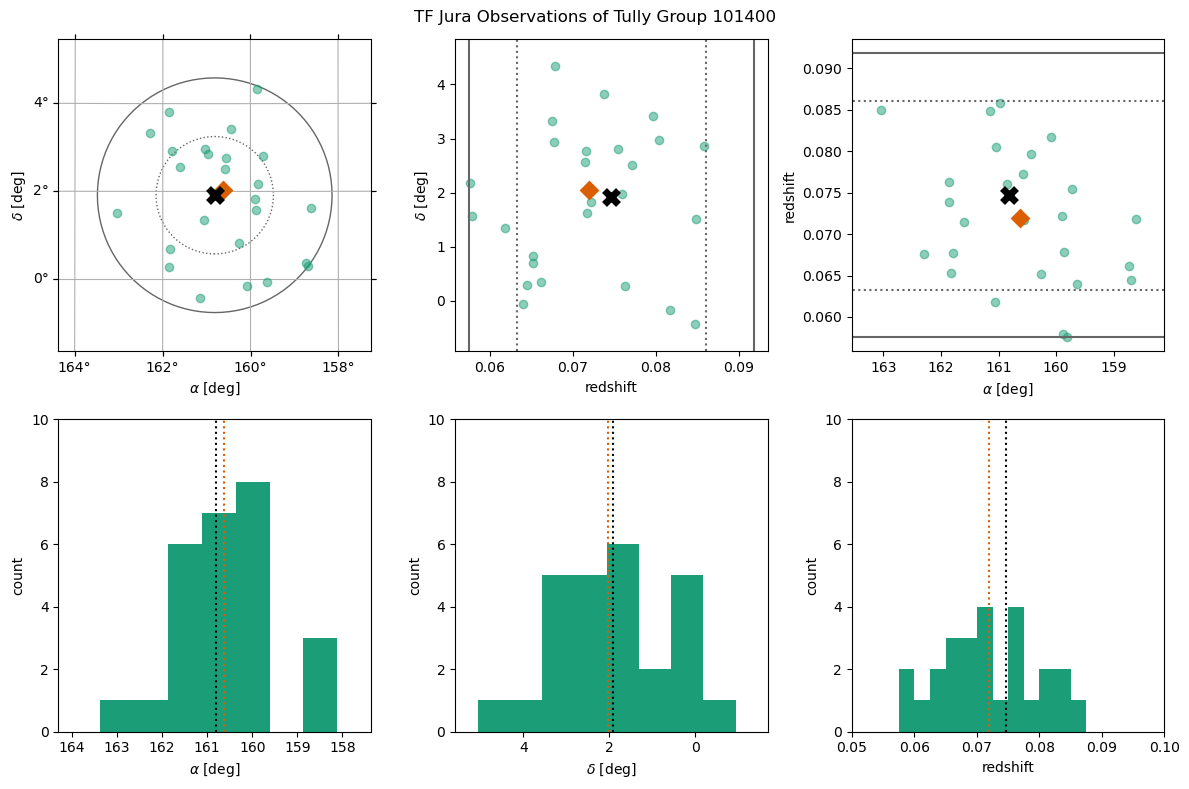

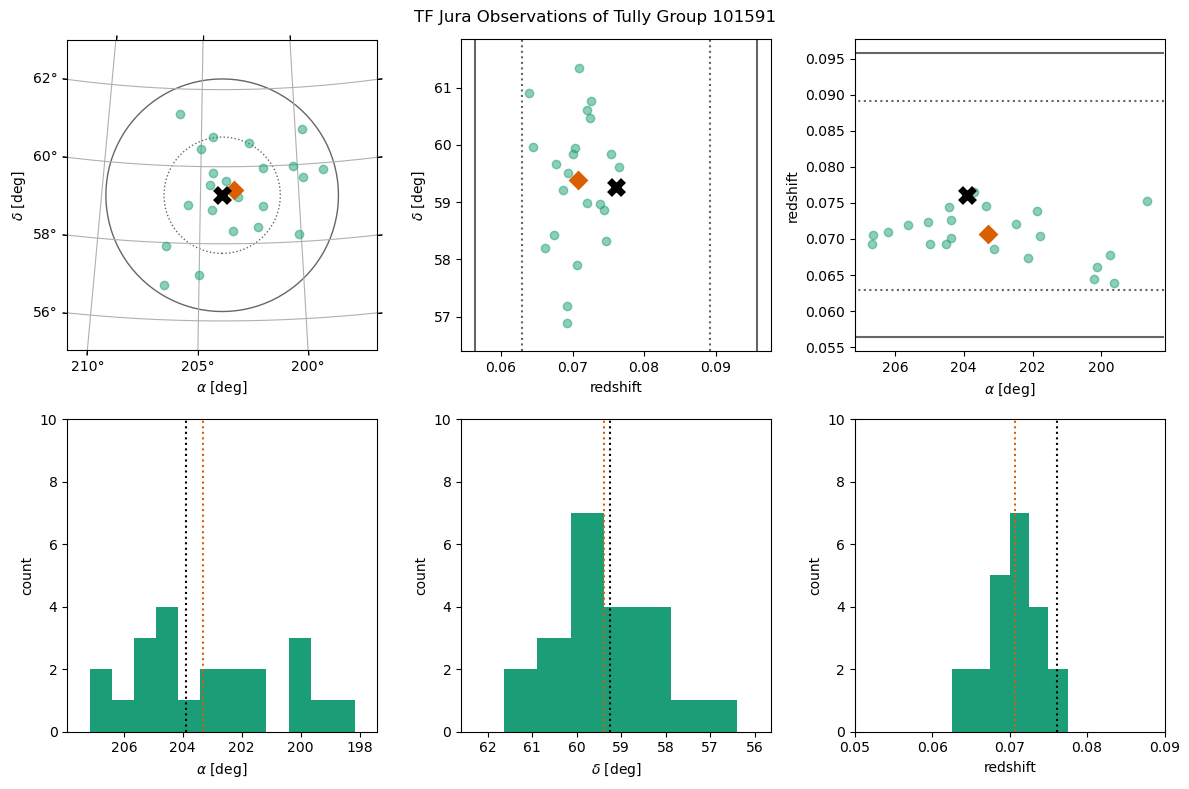

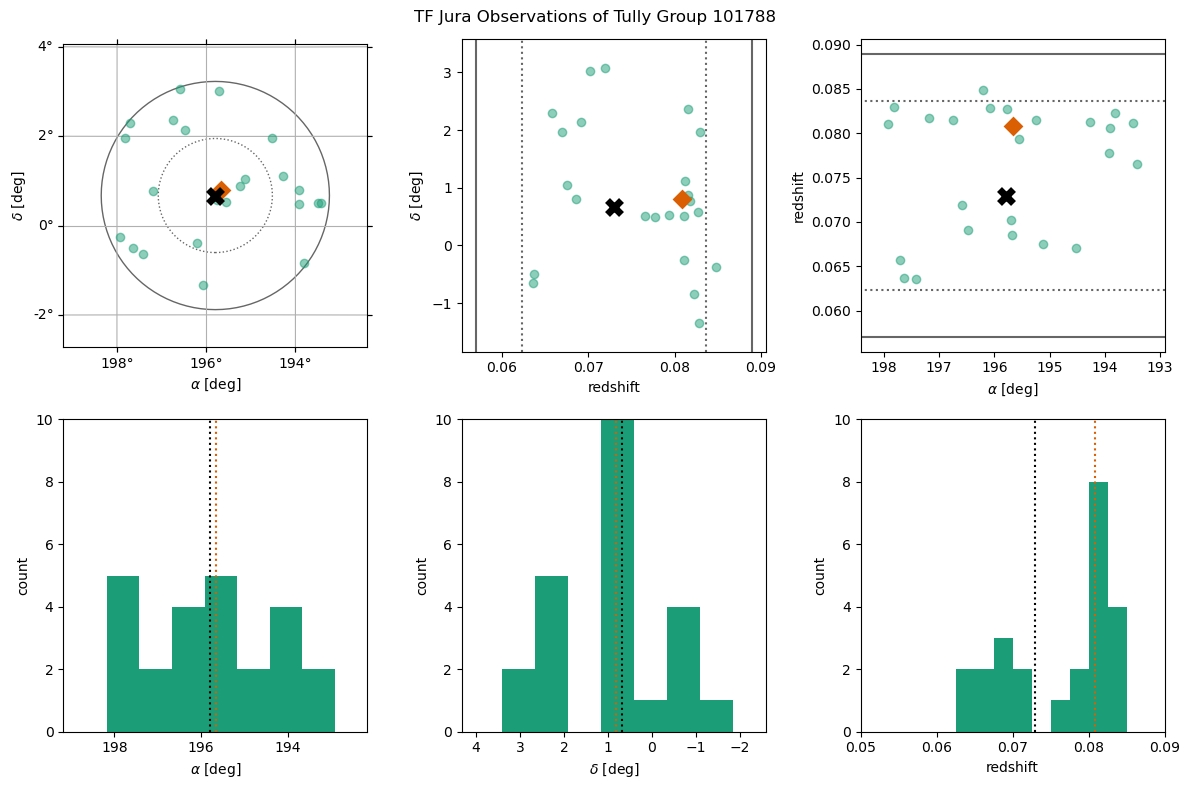

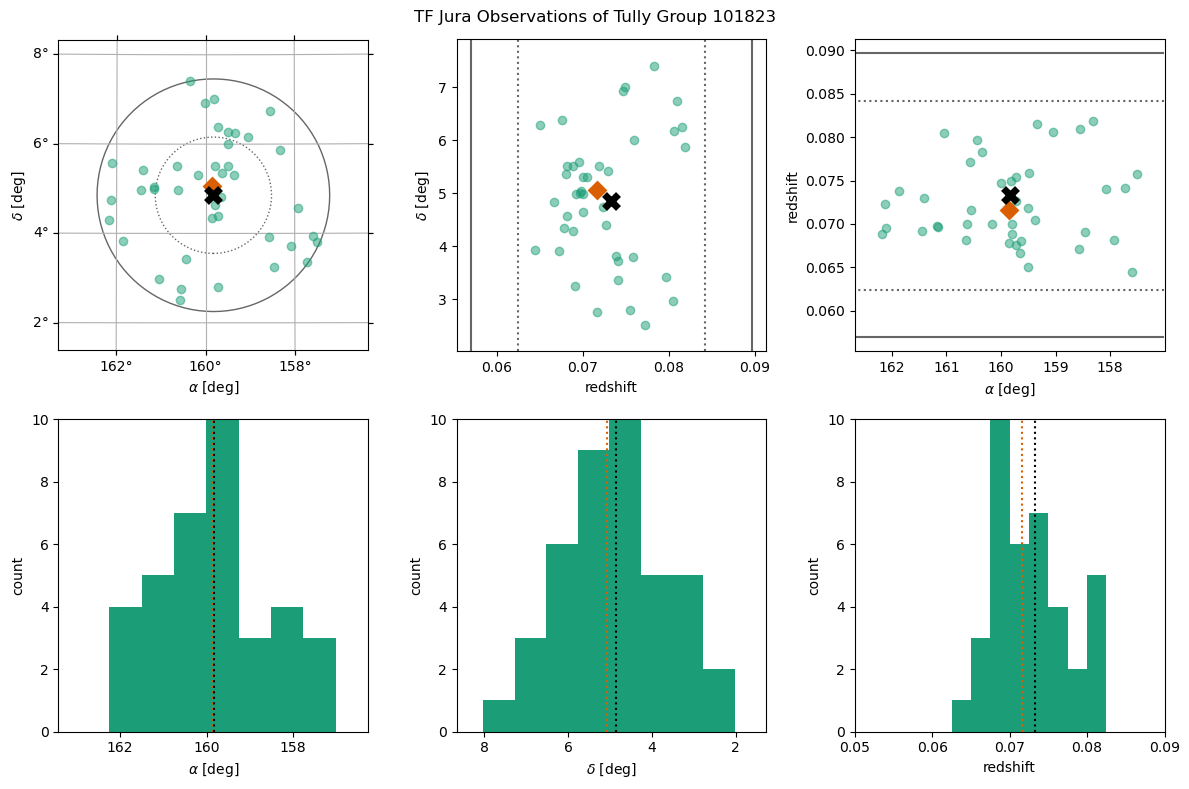

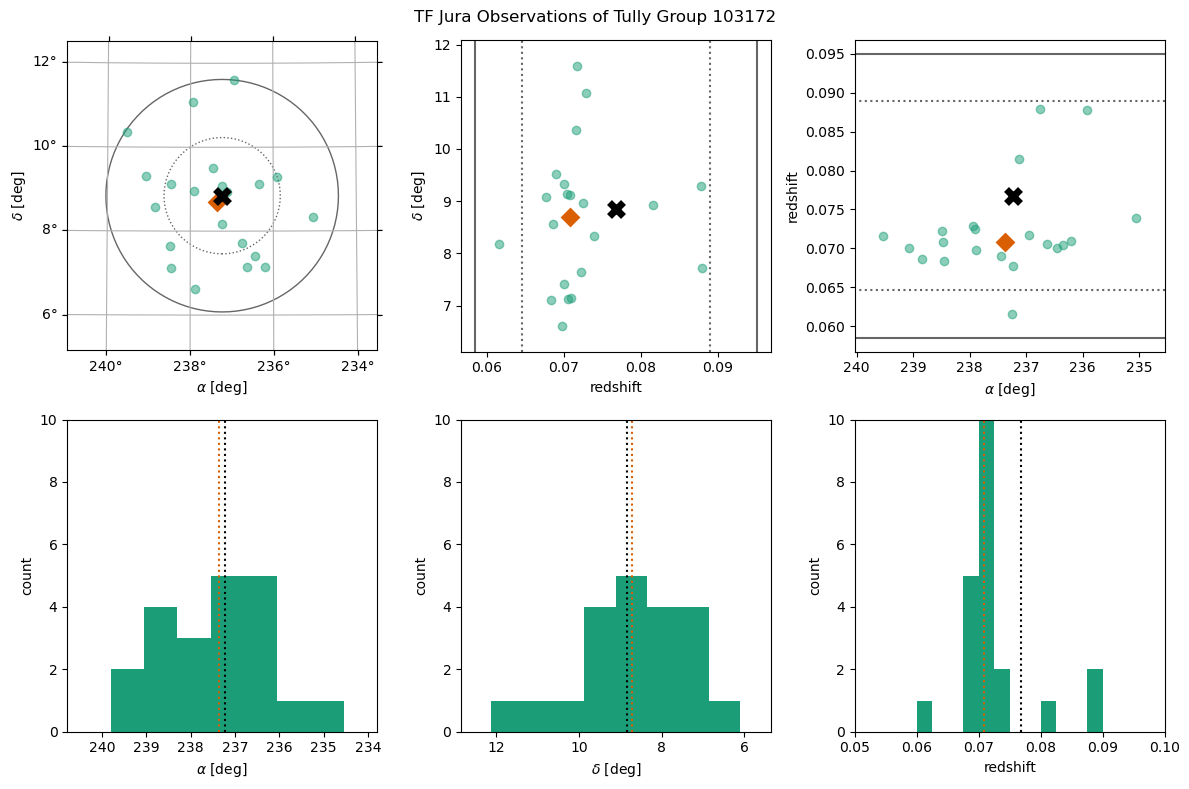

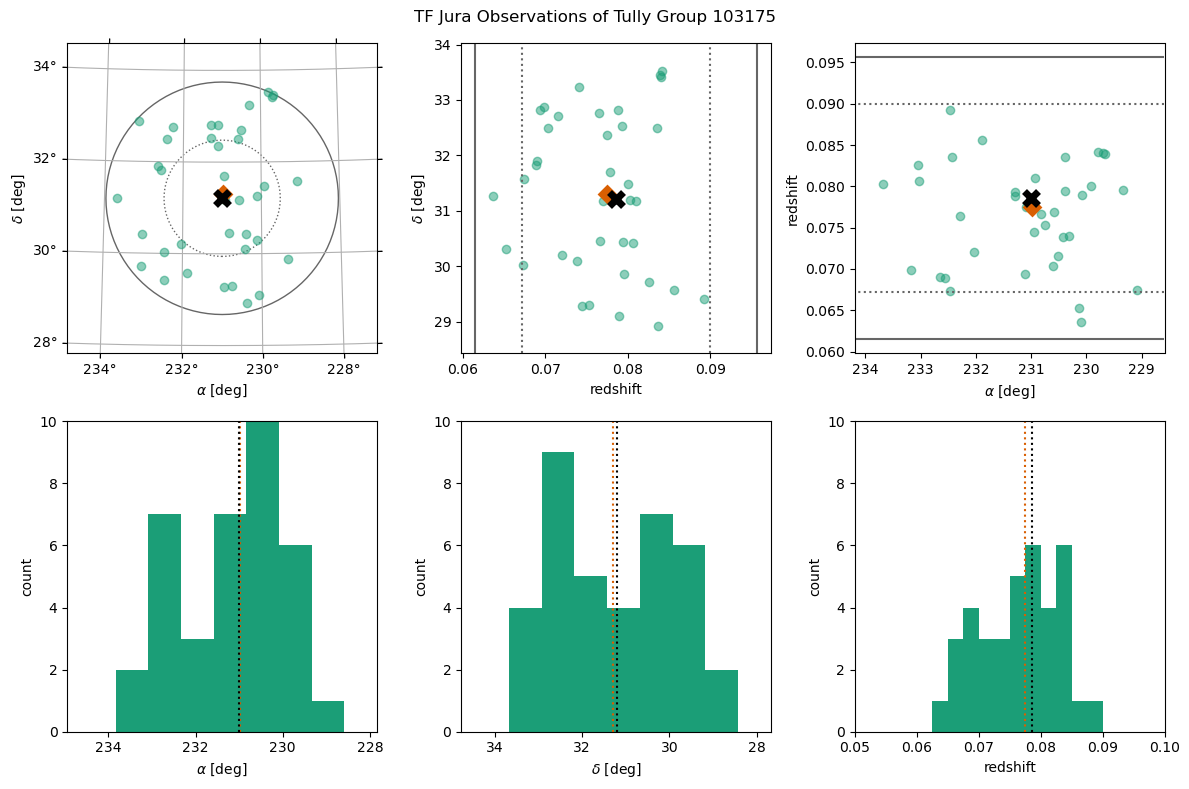

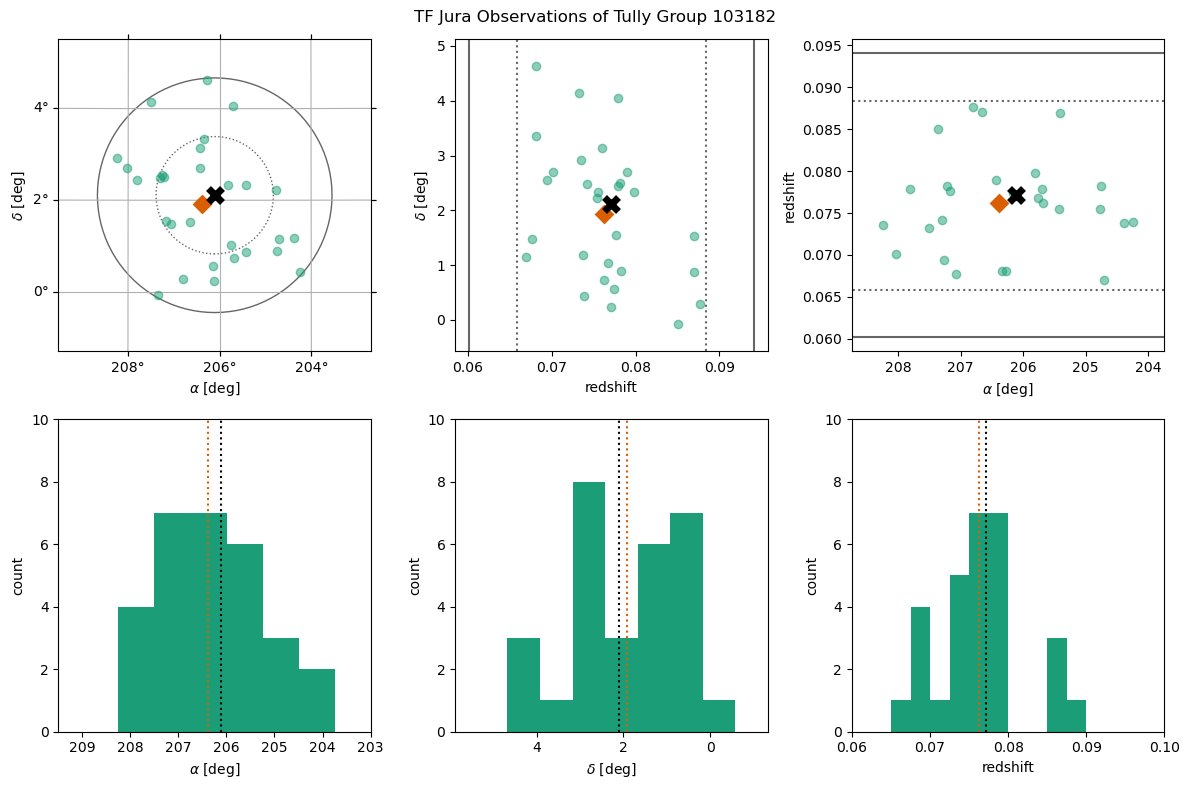

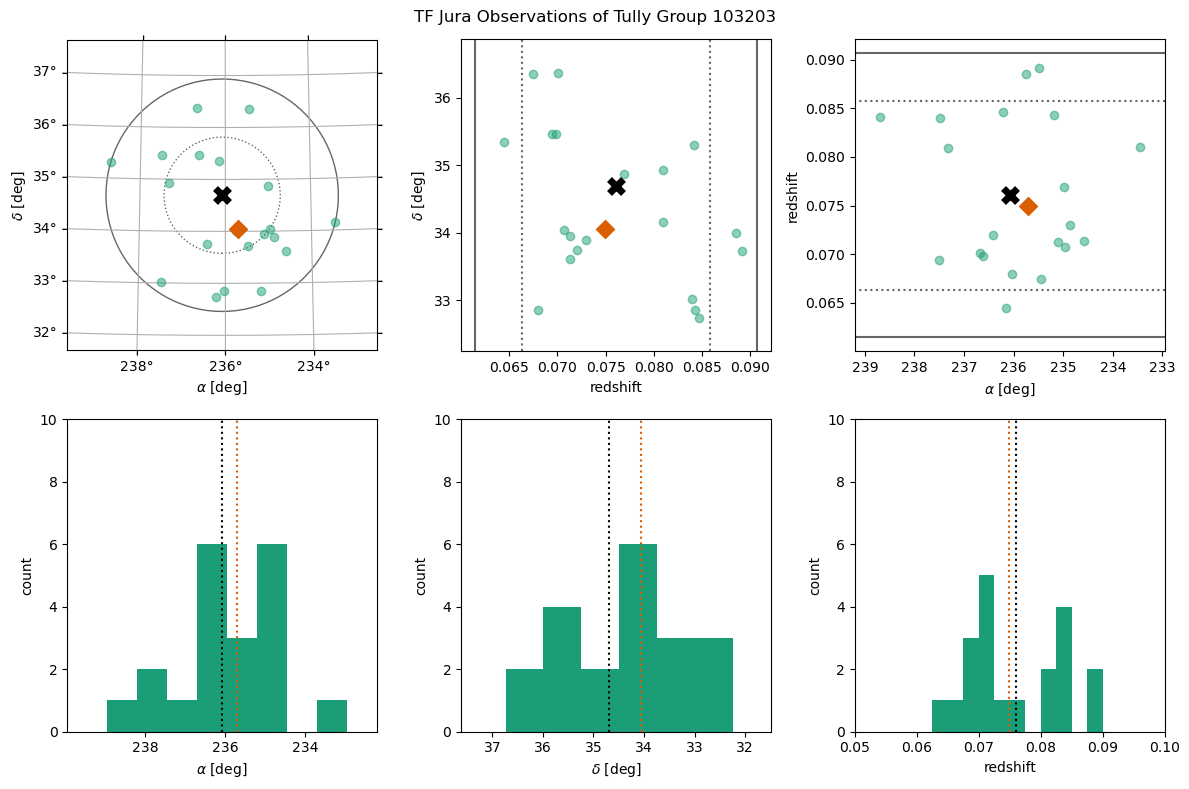

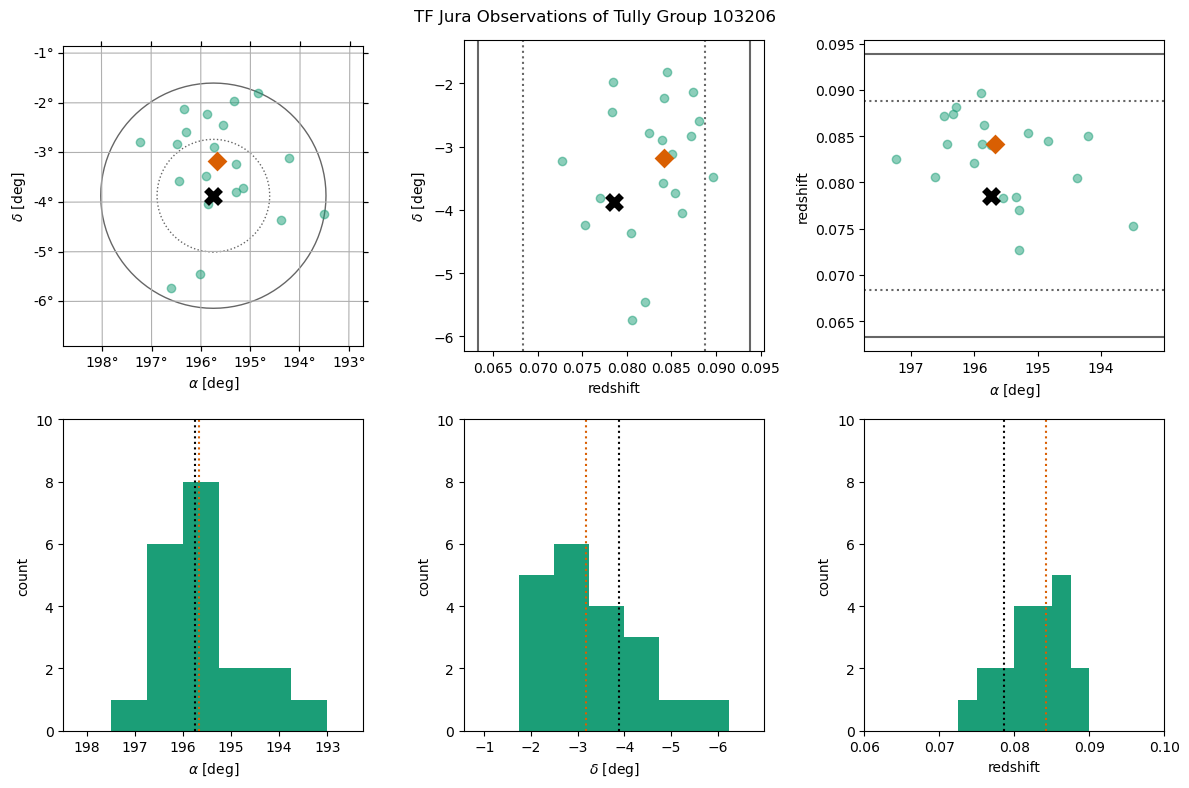

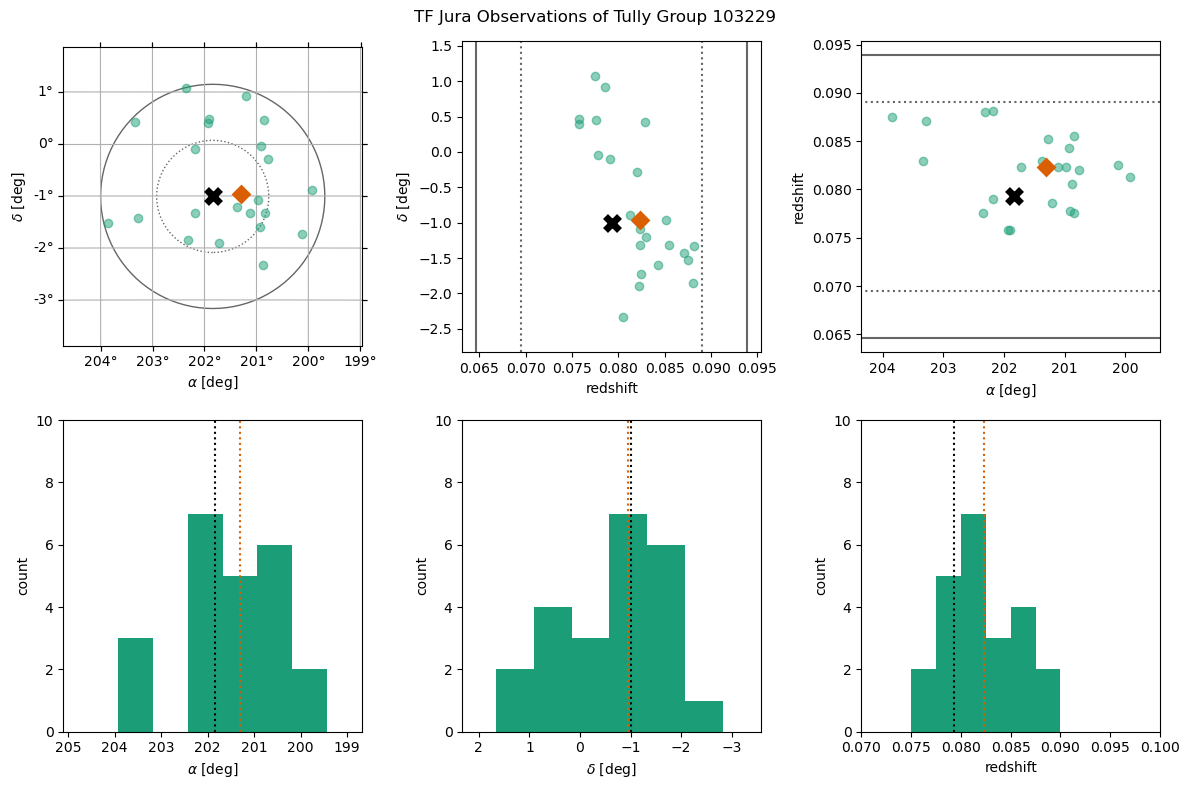

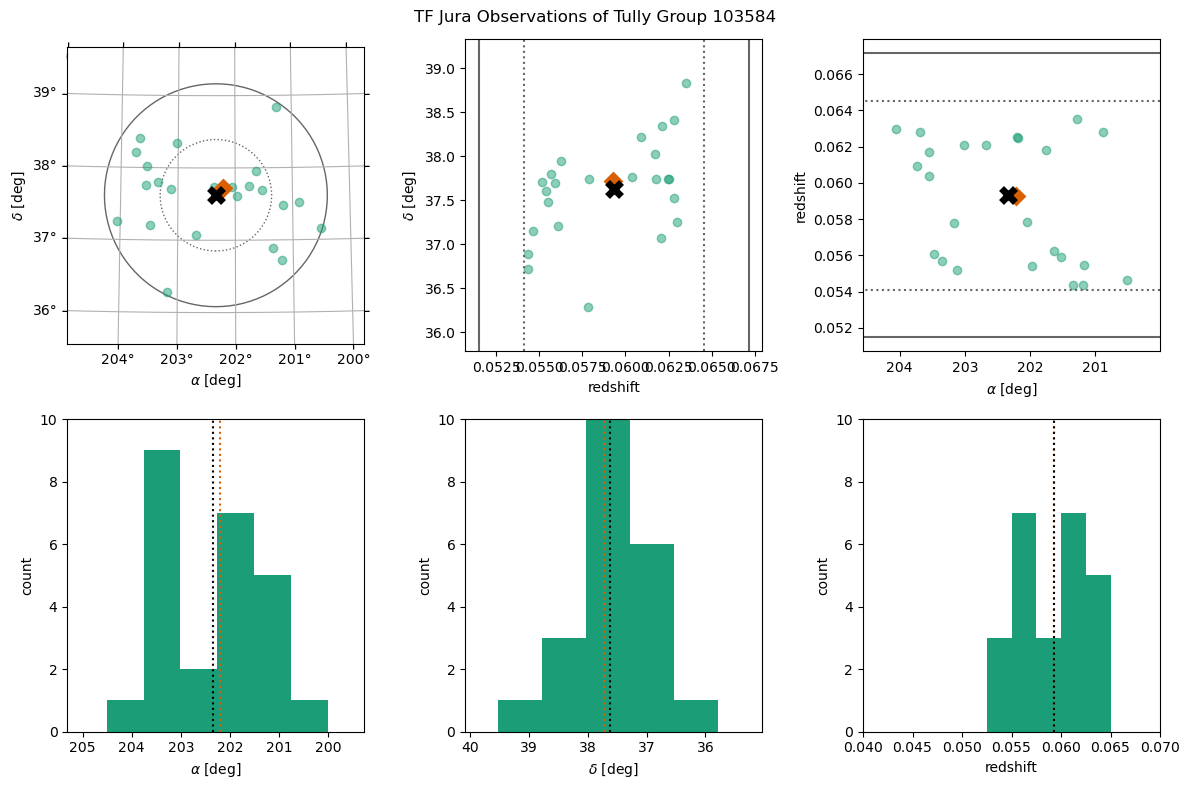

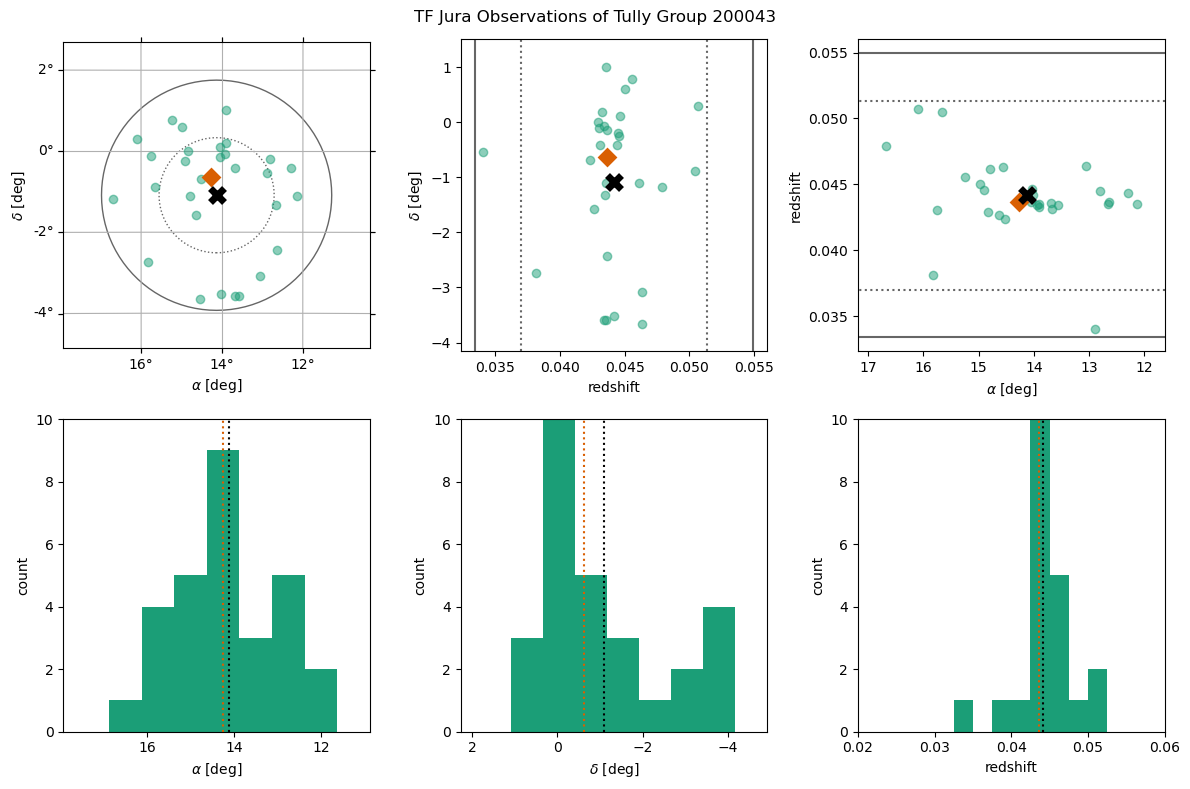

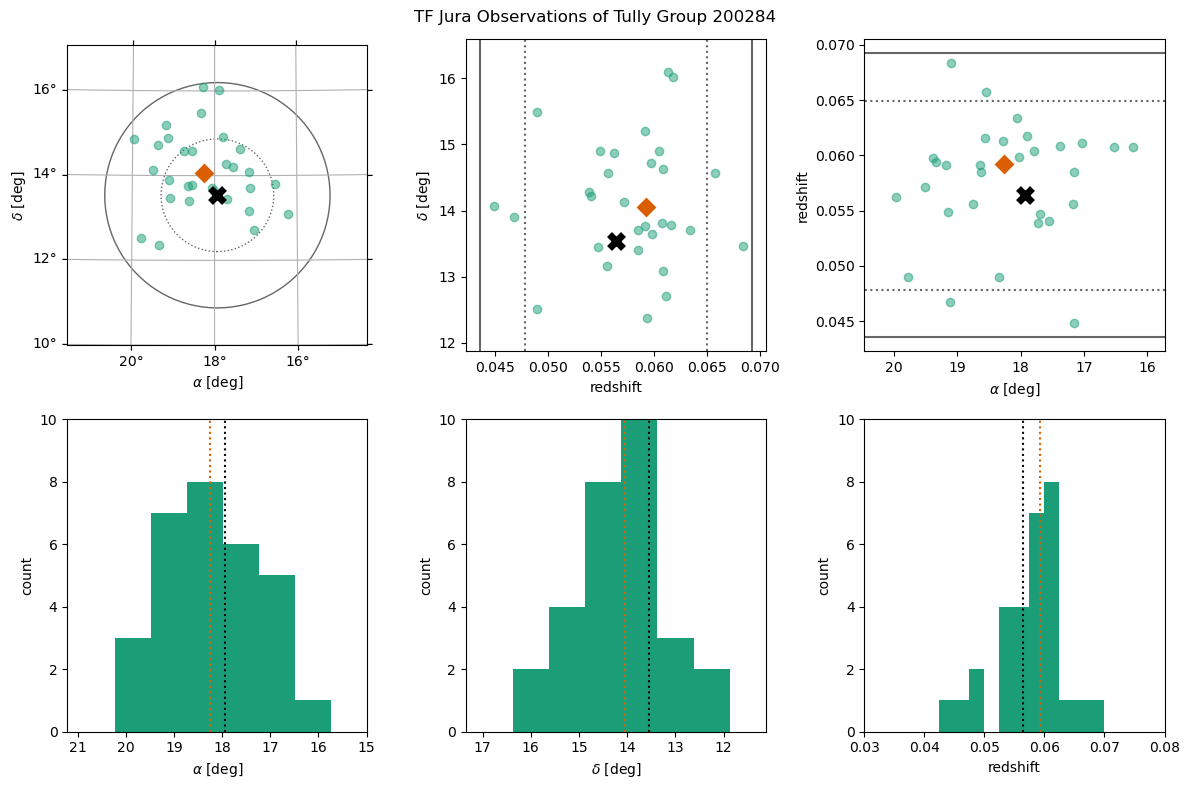

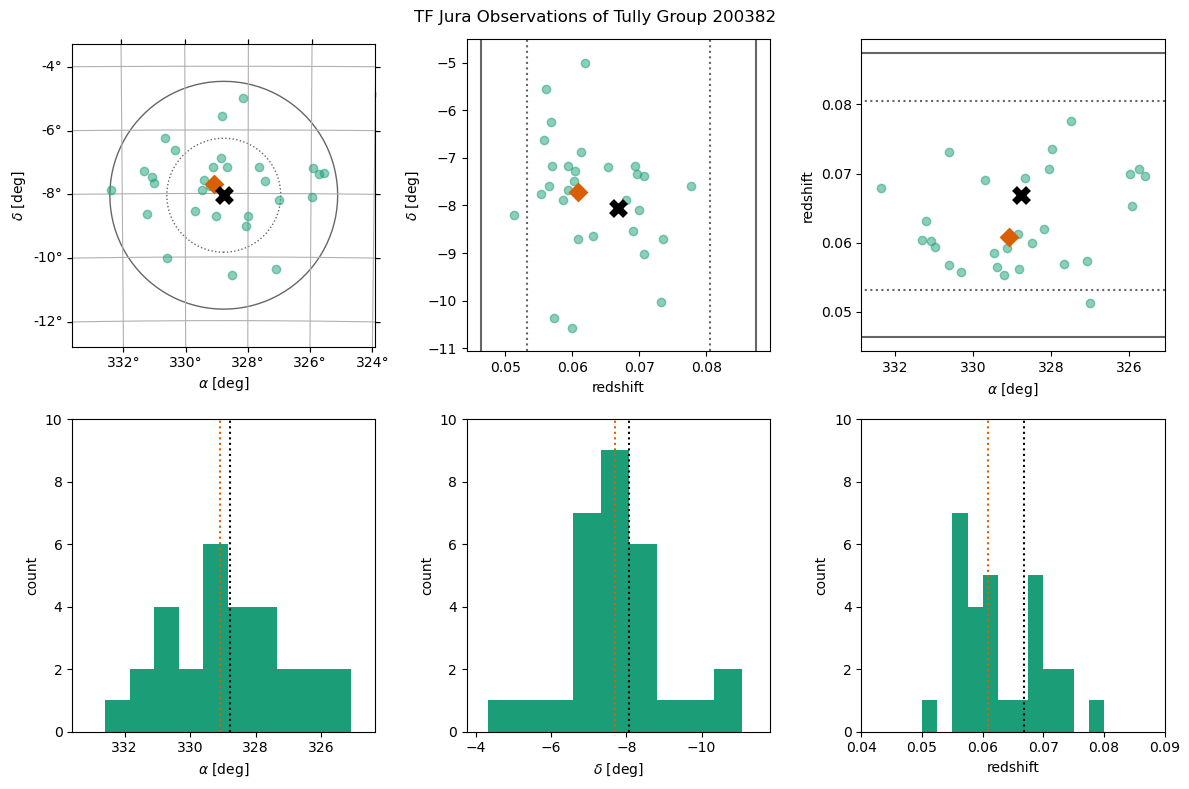

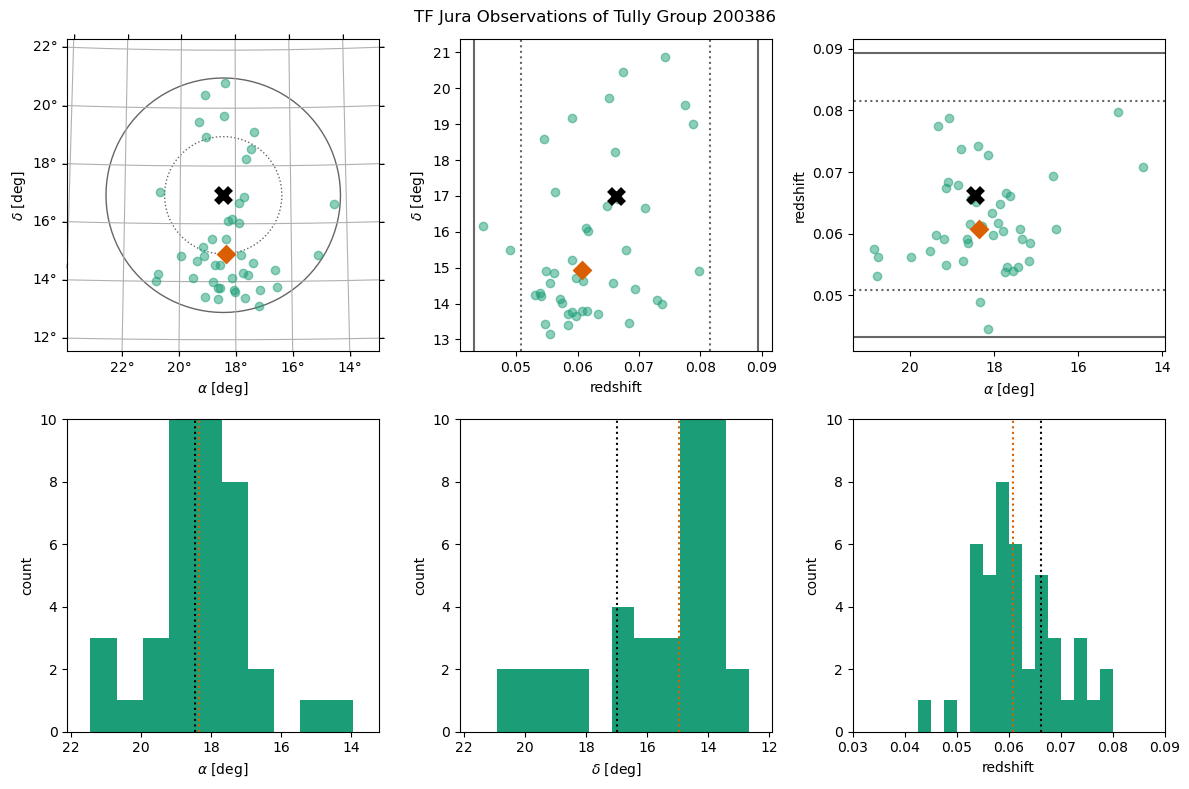

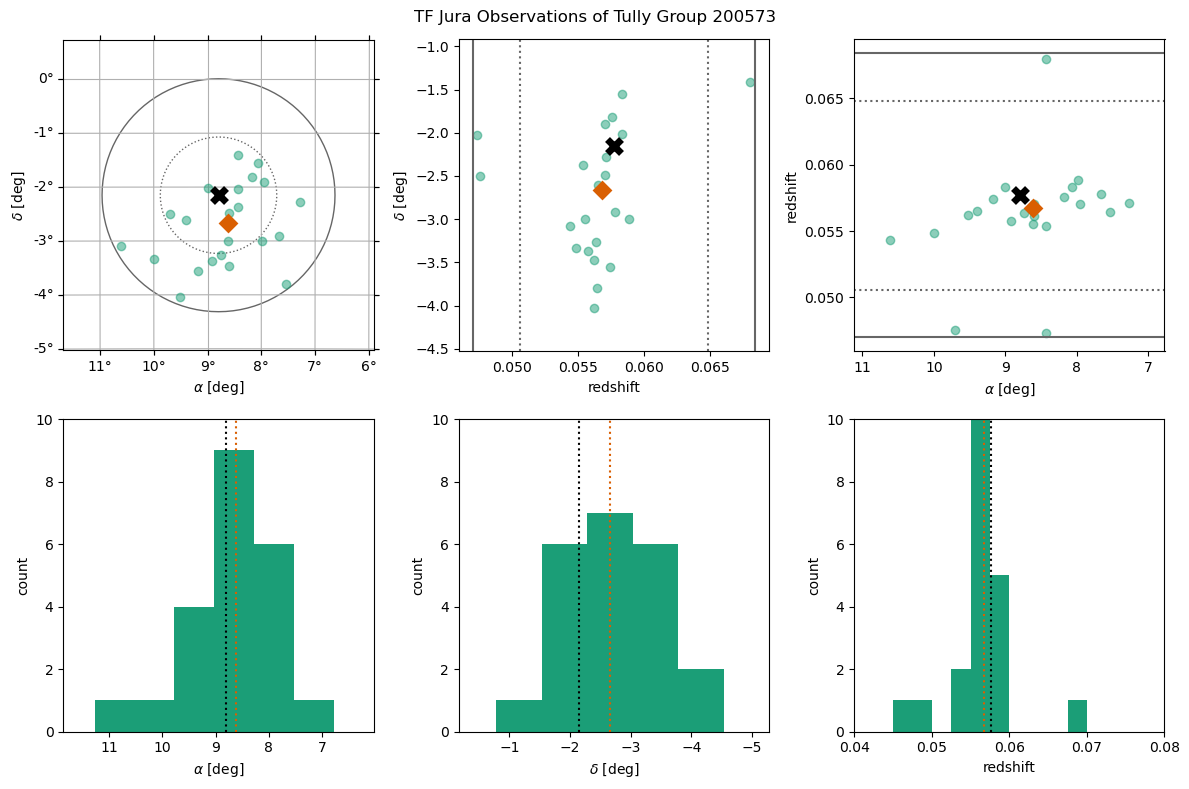

In [46]:
for cluster_id in sga_clusters.keys():
    fig = plot_cluster_members(clusters, cluster_id, sgatab_sel, sga_clusters[cluster_id])

# Apply Cluster Selection

Plot the clusters as a function of $\Delta\theta/\angle(R_{2t})$ versus $\Delta v/\sigma_P$. The quantities are:
* $\Delta\theta$: the angular separation between the median position of the DESI observations and the cluster center reported in Tully 2015.
* $\angle(R_{2t})$: the angular projection of the cluster second turnaround radius.
* $\Delta v = v_\text{cluster} - v_\text{SGA,median}$.
* $\sigma_P$: the velocity dispersion of the cluster, reported in Tully 2015.

A reasonable selection appears to be

1. $\Delta v/ \sigma_P < 1$
2. $\Delta\theta / R_{2t} < 1$

100001       253.938 km/s    1045.000 km/s       0.243       2.663 deg       1.660 deg       1.069
100002       408.128 km/s     707.000 km/s       0.577       2.831 deg       5.510 deg       0.343
100004       322.415 km/s    1057.000 km/s       0.305       0.286 deg       1.309 deg       0.146
100007       645.511 km/s    1385.000 km/s       0.466       0.296 deg       1.395 deg       0.142
100016       492.564 km/s    1037.000 km/s       0.475       0.606 deg       1.006 deg       0.402
100041        45.724 km/s     627.000 km/s       0.073       0.182 deg       0.777 deg       0.156
100046       633.781 km/s     714.000 km/s       0.888       0.670 deg       0.764 deg       0.585
100067       182.845 km/s     954.000 km/s       0.192       0.244 deg       0.961 deg       0.169
100077         7.414 km/s    1914.000 km/s       0.004       0.451 deg       1.222 deg       0.246
100125       493.298 km/s     744.000 km/s       0.663       0.553 deg       0.784 deg       0.470
100132    

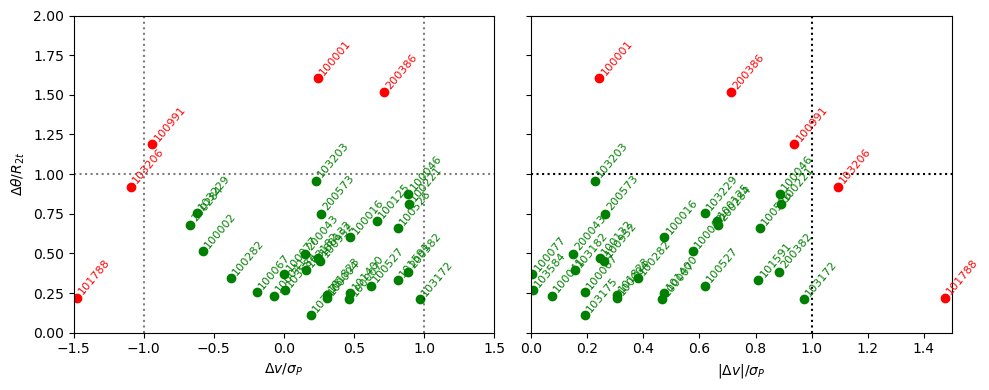

In [47]:
keep_cluster = []
dv_sigmaP = []
dtheta_R2t = []
cluster_ids = []

for cluster_id, sga_ids in sga_clusters.items():
    #- Get cluster sky coordinates
    idx = np.in1d(clusters['Nest'], cluster_id)
    cluster_lon = clusters['SGLON'][idx][0]
    cluster_lat = clusters['SGLAT'][idx][0]
    cluster_mu = clusters['DM'][idx][0]
    cluster_dist = 10 * 10**(0.2*cluster_mu) * 1e-6
    cluster_v = H0*cluster_dist
    cluster_sigma = clusters['sigP'][idx][0]
    cluster_R2t = clusters['R2t'][idx][0]
    cluster_R2t_angle = np.arctan(cluster_R2t / (cluster_v/H0)) * u.radian
    cluster_R2t_1p5 = np.arctan(1.5*cluster_R2t / (cluster_v/H0)) * u.radian
    cluster_R2t_3 = np.arctan(3*cluster_R2t / (cluster_v/H0)) * u.radian
    cluster_R2t_4 = np.arctan(4*cluster_R2t / (cluster_v/H0)) * u.radian
    
    cluster_coord = SkyCoord(cluster_lon, cluster_lat, unit='deg', frame='supergalactic').transform_to('icrs')
    
    #- Get SGA galaxy coordinates and median of observations
    idx = np.in1d(sgatab['SGA_ID'], sga_ids)
    z_sga = sgatab['Z_DESI'][idx]
    z_sorted = np.sort(z_sga)
    ngal = len(z_sorted)
    z_sga_median = np.mean(z_sorted[ngal//2:ngal//2 + 2]) if (ngal % 2 == 0) else z_sorted[ngal//2]
    
    sga_coords = SkyCoord(ra=sgatab['RA'][idx], dec=sgatab['DEC'][idx], unit='deg', frame='icrs')
    sga_coords_median = cluster_median_coords(sga_coords)

    #- Compute the angle and velocity ratios:
    delta_v = cluster_v - c_kms*z_sga_median
    _dv_sigP = delta_v / cluster_sigma
    dv_sigmaP.append(_dv_sigP)

    delta_theta = sga_coords_median.separation(cluster_coord).to('rad')
    _dth_R2t = delta_theta / cluster_R2t_angle
    dtheta_R2t.append(_dth_R2t)

    cluster_ids.append(cluster_id)

    #- Print results:
    print(f'{cluster_id:<8d}{np.abs(delta_v):12.3f} km/s{cluster_sigma:12.3f} km/s{np.abs(delta_v)/cluster_sigma:12.3f}' \
          f'{delta_theta.to("deg"):12.3f}{cluster_R2t_angle.to("deg"):12.3f}{delta_theta / (1.5*cluster_R2t_angle):12.3f}')

dv_sigmaP = np.asarray(dv_sigmaP)
dtheta_R2t = np.asarray(dtheta_R2t)
cluster_ids = np.asarray(cluster_ids)

#- Apply selection
dvcut = 1
dthcut = 1
select = (np.abs(dv_sigmaP) < dvcut) & (dtheta_R2t < dthcut)

#- Plot results

fig, axes = plt.subplots(1, 2, figsize=(10,4), sharey=True, tight_layout=True)
ax = axes[0]
ax.scatter(dv_sigmaP[select], dtheta_R2t[select], color='g')
for _dv, _dth, _id in zip(dv_sigmaP[select], dtheta_R2t[select], cluster_ids[select]):
    ax.annotate(f'{_id}', (_dv, _dth+0.02), fontsize=8, rotation=50, color='green')

ax.scatter(dv_sigmaP[~select], dtheta_R2t[~select], color='r')
for _dv, _dth, _id in zip(dv_sigmaP[~select], dtheta_R2t[~select], cluster_ids[~select]):
    ax.annotate(f'{_id}', (_dv, _dth+0.02), fontsize=8, rotation=50, color='red')

ax.axvline(dvcut, ls=':', color='k', alpha=0.5)
ax.axvline(-dvcut, ls=':', color='k', alpha=0.5)
ax.axhline(dthcut, ls=':', color='k', alpha=0.5)
ax.set(xlabel=r'$\Delta v/\sigma_P$',
       xlim=(-1.5, 1.5),
       ylabel=r'$\Delta\theta/R_{2t}$',
       ylim=(0,2))

ax = axes[1]
ax.scatter(np.abs(dv_sigmaP[select]), dtheta_R2t[select], color='g')
for _dv, _dth, _id in zip(np.abs(dv_sigmaP[select]), dtheta_R2t[select], cluster_ids[select]):
    ax.annotate(f'{_id}', (_dv, _dth+0.02), fontsize=8, rotation=50, color='green')

ax.scatter(np.abs(dv_sigmaP[~select]), dtheta_R2t[~select], color='r')
for _dv, _dth, _id in zip(np.abs(dv_sigmaP[~select]), dtheta_R2t[~select], cluster_ids[~select]):
    ax.annotate(f'{_id}', (_dv, _dth+0.02), fontsize=8, rotation=50, color='red')

ax.axvline(dvcut, ls=':', color='k')
ax.axvline(-dvcut, ls=':', color='k')
ax.axhline(dthcut, ls=':', color='k')
ax.set(xlabel=r'$|\Delta v|/\sigma_P$',
       xlim=(0, 1.5));

# fig.savefig('../../Figures/Y3/TF_Y3_SGA_Vrot_clusters_selection.png', dpi=150);

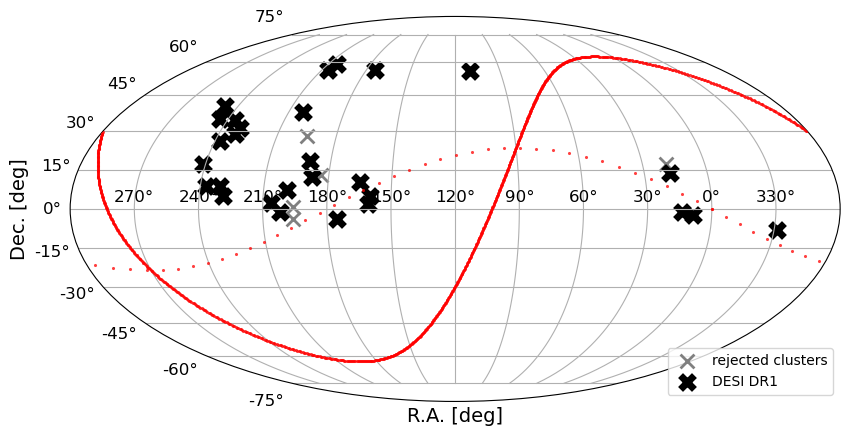

In [48]:
nest_ids = np.asarray(list(sga_clusters.keys()))
good_idx = np.in1d(clusters['Nest'], nest_ids[select])
bad_idx = np.in1d(clusters['Nest'], nest_ids[~select])
good_cluster_coords = SkyCoord(clusters['SGLON'][good_idx], clusters['SGLAT'][good_idx], unit='deg', frame='supergalactic')
bad_cluster_coords = SkyCoord(clusters['SGLON'][bad_idx], clusters['SGLAT'][bad_idx], unit='deg', frame='supergalactic')

ax = init_sky()

ax.scatter(ax.projection_ra(bad_cluster_coords.transform_to('icrs').ra.value), 
           ax.projection_dec(bad_cluster_coords.transform_to('icrs').dec.value), 
           marker='x', 
           s=100,
           linewidth=2,
           color='gray', 
           label='rejected clusters')
ax.scatter(ax.projection_ra(good_cluster_coords.transform_to('icrs').ra.value), 
           ax.projection_dec(good_cluster_coords.transform_to('icrs').dec.value), 
           marker='x', 
           s=100,
           linewidth=5,
           color='black', 
           label='DESI DR1')

ax.xaxis.label.set_size(14)
ax.yaxis.label.set_size(14)

plt.legend(loc='lower right')

plt.tick_params(axis='both', which='major', labelsize=12);

# plt.savefig('../../Figures/Y3/iron_clusters_sky.png', dpi=150, facecolor='none');

In [49]:
for i, (cluster_id, sga_ids) in enumerate(sga_clusters.items()):
    print(f'{i+1:2d} {cluster_id:7d} {len(sga_ids):3d} galaxies  {"Y" if select[i] else "N"}')

 1  100001  20 galaxies  N
 2  100002  34 galaxies  Y
 3  100004  61 galaxies  Y
 4  100007 108 galaxies  Y
 5  100016  24 galaxies  Y
 6  100041  24 galaxies  Y
 7  100046  21 galaxies  Y
 8  100067  30 galaxies  Y
 9  100077  53 galaxies  Y
10  100125  21 galaxies  Y
11  100132  20 galaxies  Y
12  100221  20 galaxies  Y
13  100282  67 galaxies  Y
14  100526  33 galaxies  Y
15  100527  25 galaxies  Y
16  100952  26 galaxies  Y
17  100991  20 galaxies  N
18  101400  26 galaxies  Y
19  101591  22 galaxies  Y
20  101788  24 galaxies  N
21  101823  41 galaxies  Y
22  103172  21 galaxies  Y
23  103175  37 galaxies  Y
24  103182  29 galaxies  Y
25  103203  20 galaxies  Y
26  103206  20 galaxies  N
27  103229  23 galaxies  Y
28  103584  25 galaxies  Y
29  200043  29 galaxies  Y
30  200284  30 galaxies  Y
31  200382  29 galaxies  Y
32  200386  44 galaxies  N
33  200573  22 galaxies  Y


## Plot Galaxy Clusters that Failed the Selection

<SkyCoord (ICRS): (ra, dec) in deg
    (194.75582168, 27.93269246)>
7345.138681571143 +/- 1045 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (183.57780685, 13.09060247)>
21086.281499332887 +/- 1482 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (195.7953898, 0.67439744)>
21877.616239495565 +/- 1599 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (195.74616921, -3.87530193)>
23550.492838960086 +/- 1529 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (18.44359042, 16.98990087)>
19860.949173573757 +/- 2303 km/s


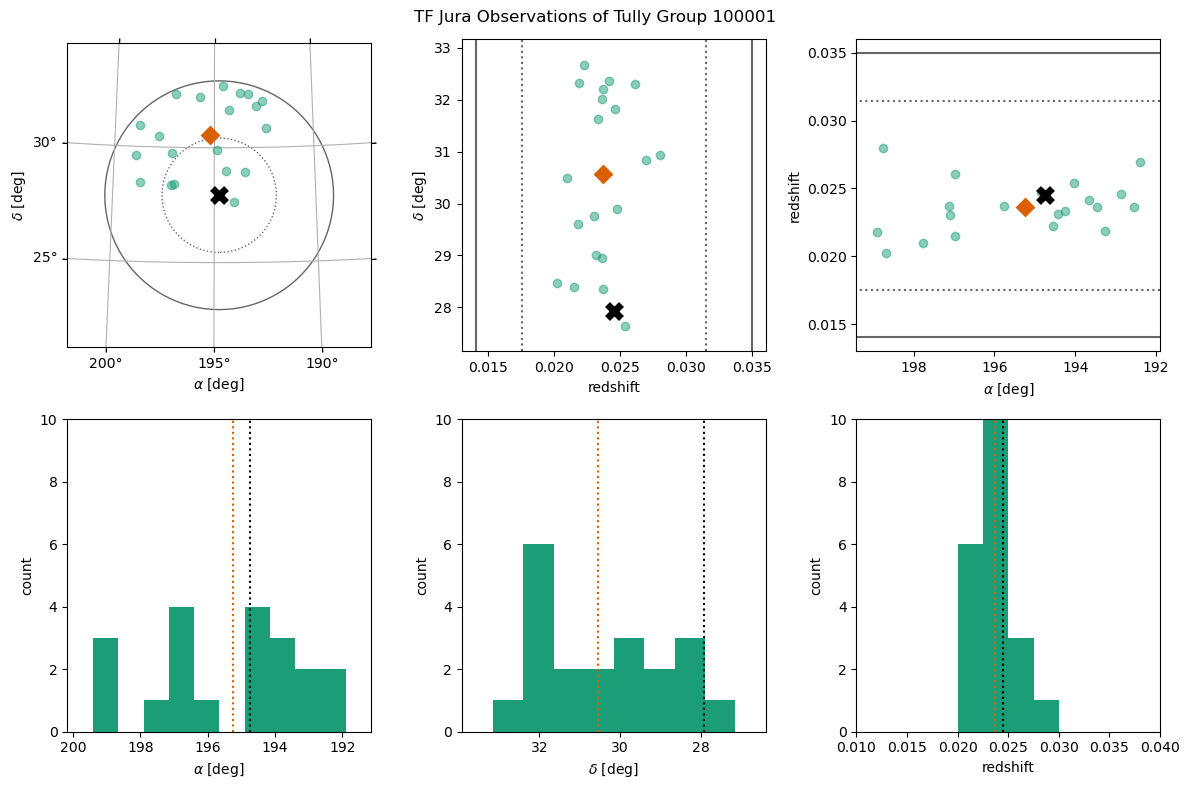

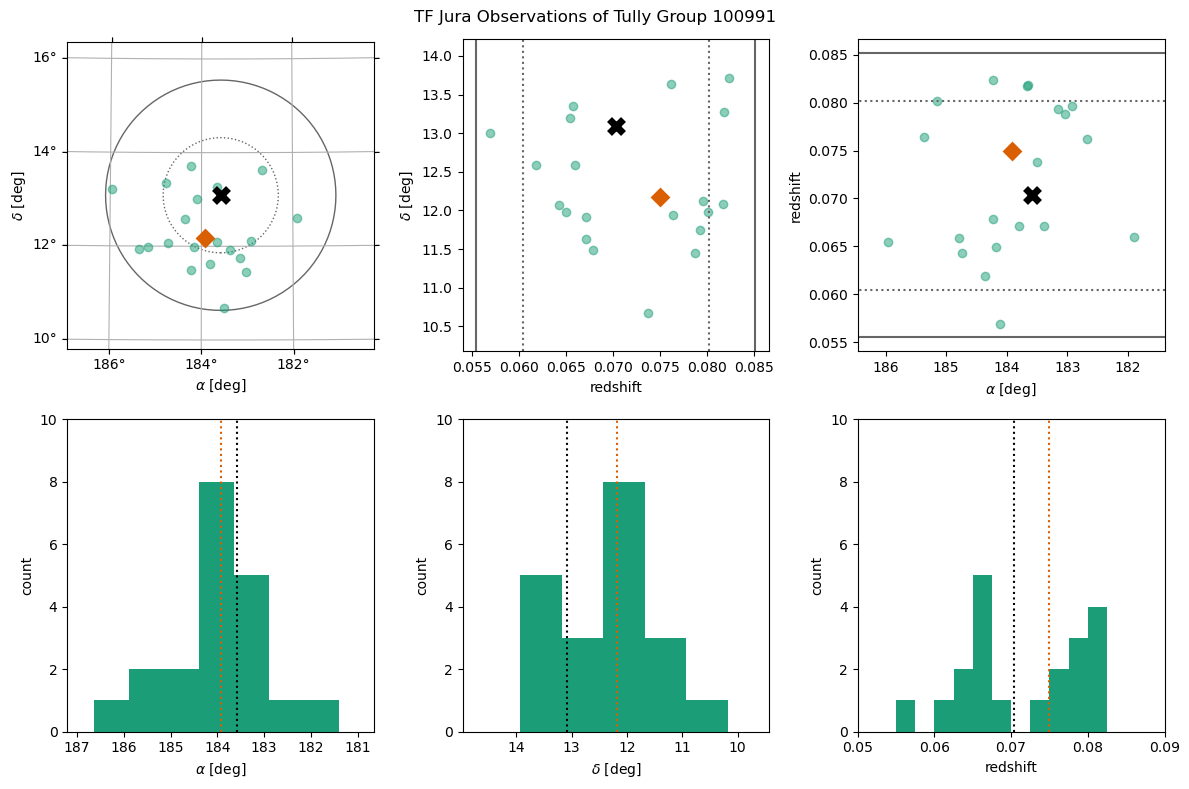

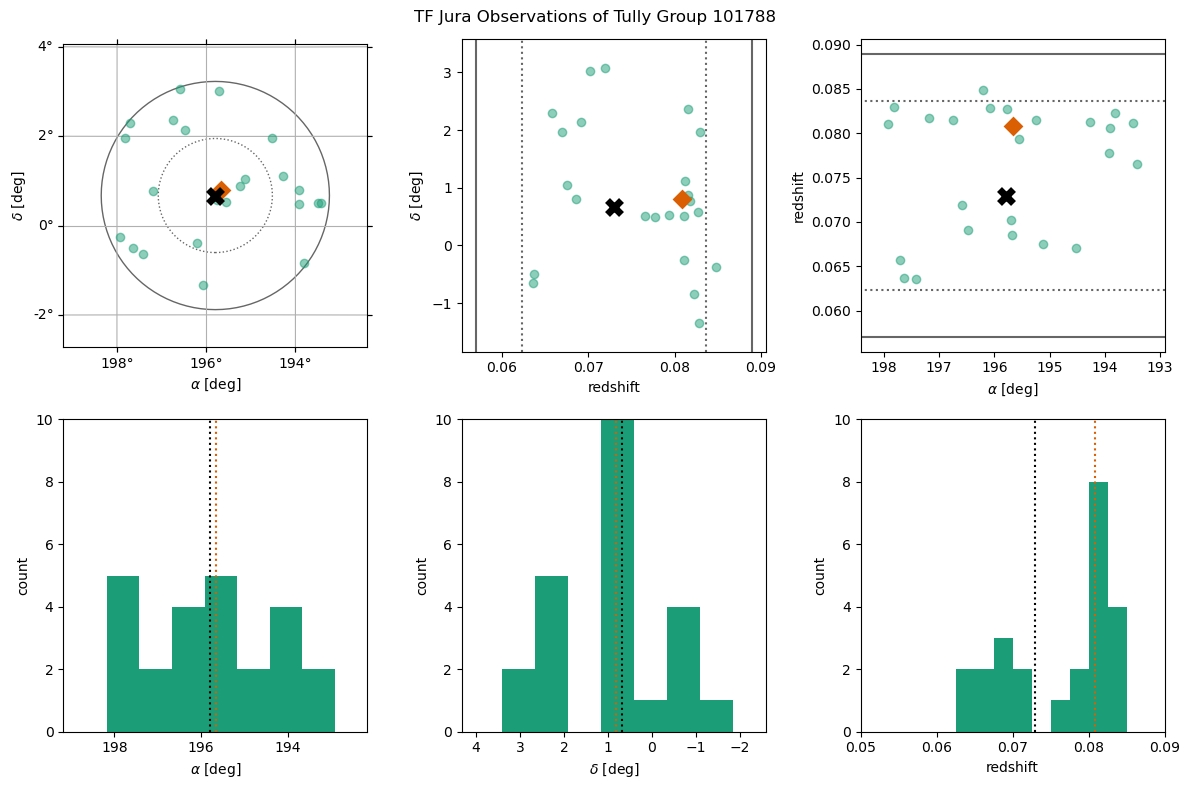

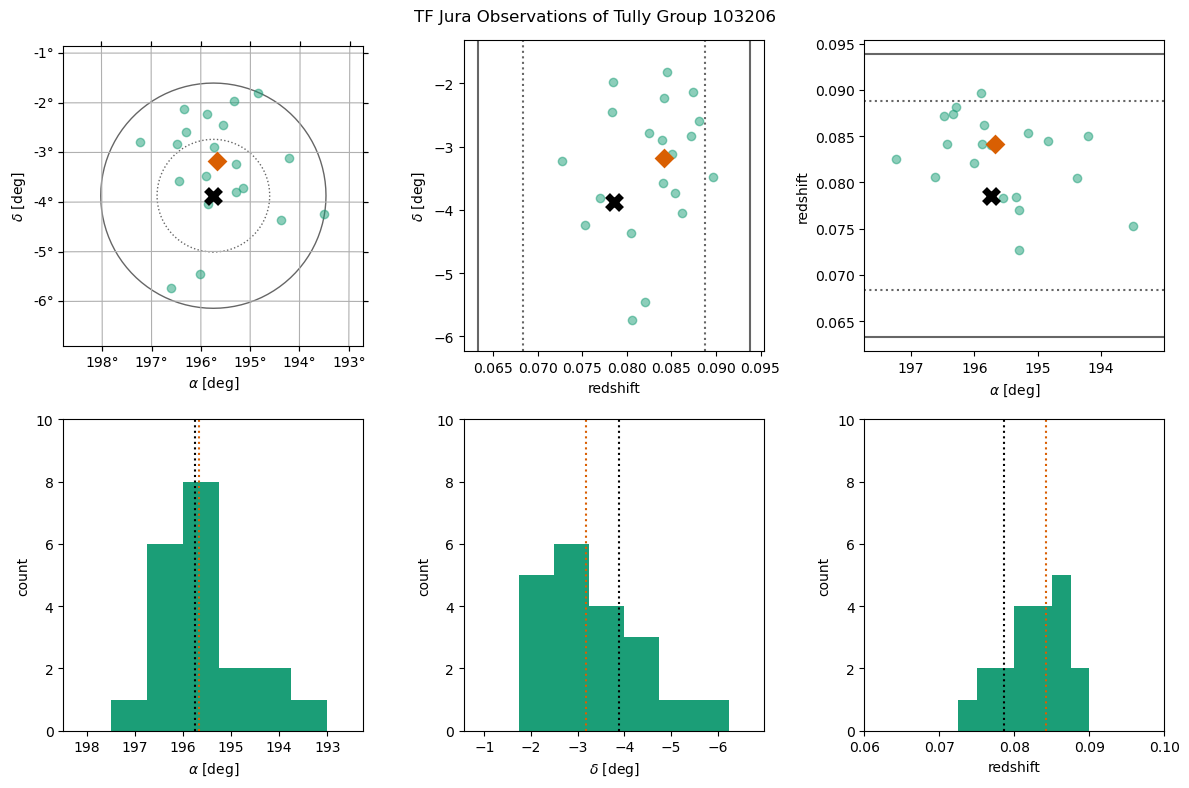

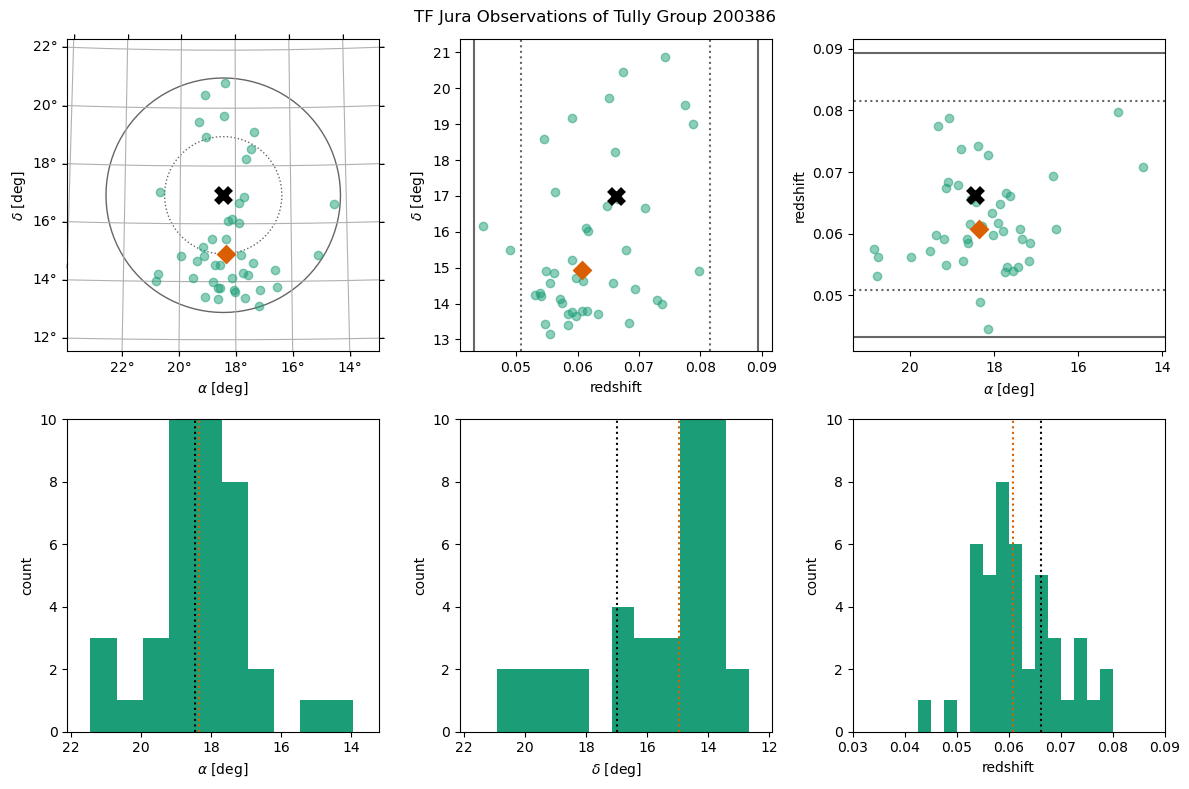

In [50]:
for cluster_id in sga_clusters.keys():
    if cluster_id in cluster_ids[~select]:
        fig = plot_cluster_members(clusters, cluster_id, sgatab_sel, sga_clusters[cluster_id])
        # fig.savefig(f'../../Figures/Y3/TF_Y3_cluster_{cluster_id}_reject.png', dpi=150);

## Plot Galaxy Clusters that Passed the Selection

<SkyCoord (ICRS): (ra, dec) in deg
    (187.76381061, 12.28264393)>
1492.7944095789974 +/- 707 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (246.98584602, 40.22479396)>
9418.895965228417 +/- 1057 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (241.05808519, 16.95441739)>
11587.773561551261 +/- 1385 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (110.17218675, 55.6898024)>
12022.64434617413 +/- 1037 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (244.29362068, 35.02777805)>
9418.895965228417 +/- 627 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (230.75880839, 8.56052159)>
10914.403364487573 +/- 714 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (228.80657754, 4.74840124)>
11587.773561551261 +/- 954 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (174.18925473, 56.12464342)>
18281.002161427445 +/- 1914 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (164.82189669, 10.09092567)>
11066.237839776675 +/- 744 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (199.15794579, 7.32962624)>
15417.004529495585 +/- 1049 km/s
<S

/tmp/ipykernel_1256567/805910609.py:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(12,8), tight_layout=True)


<SkyCoord (ICRS): (ra, dec) in deg
    (201.84149945, -1.00863004)>
23768.402866248827 +/- 1465 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (202.33739481, 37.62288797)>
17782.794100389227 +/- 783 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (14.13239492, -1.08658284)>
13243.415351946644 +/- 1077 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (17.93151711, 13.53834251)>
16904.409316432666 +/- 1285 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (328.77363049, -8.05653143)>
20044.72027365159 +/- 2055 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (8.7960233, -2.15186295)>
17298.163592150995 +/- 1069 km/s


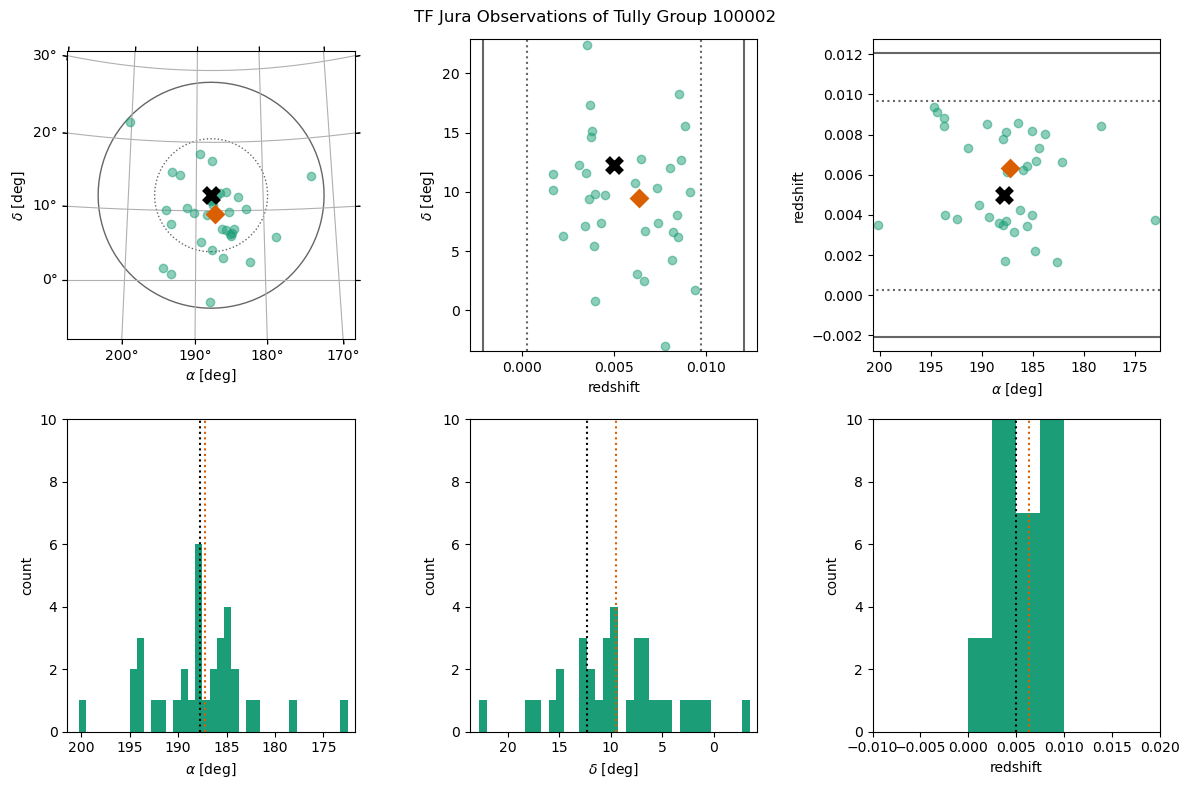

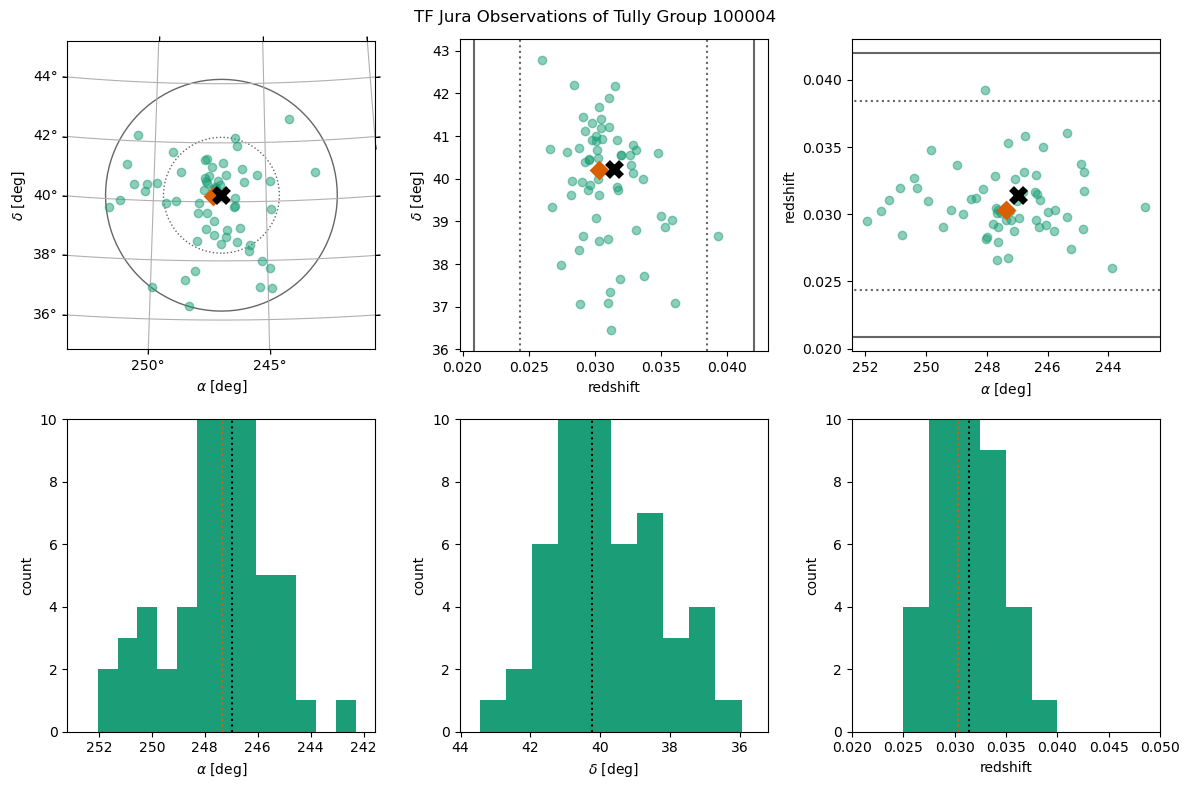

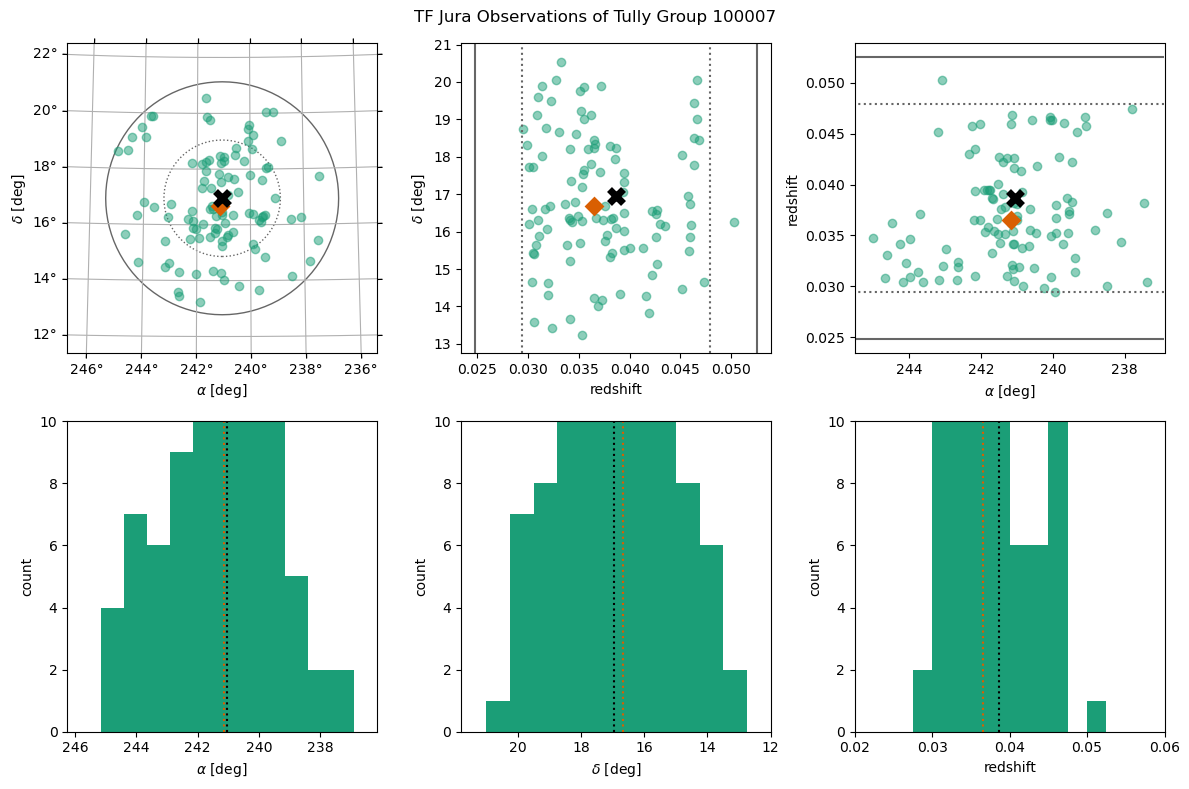

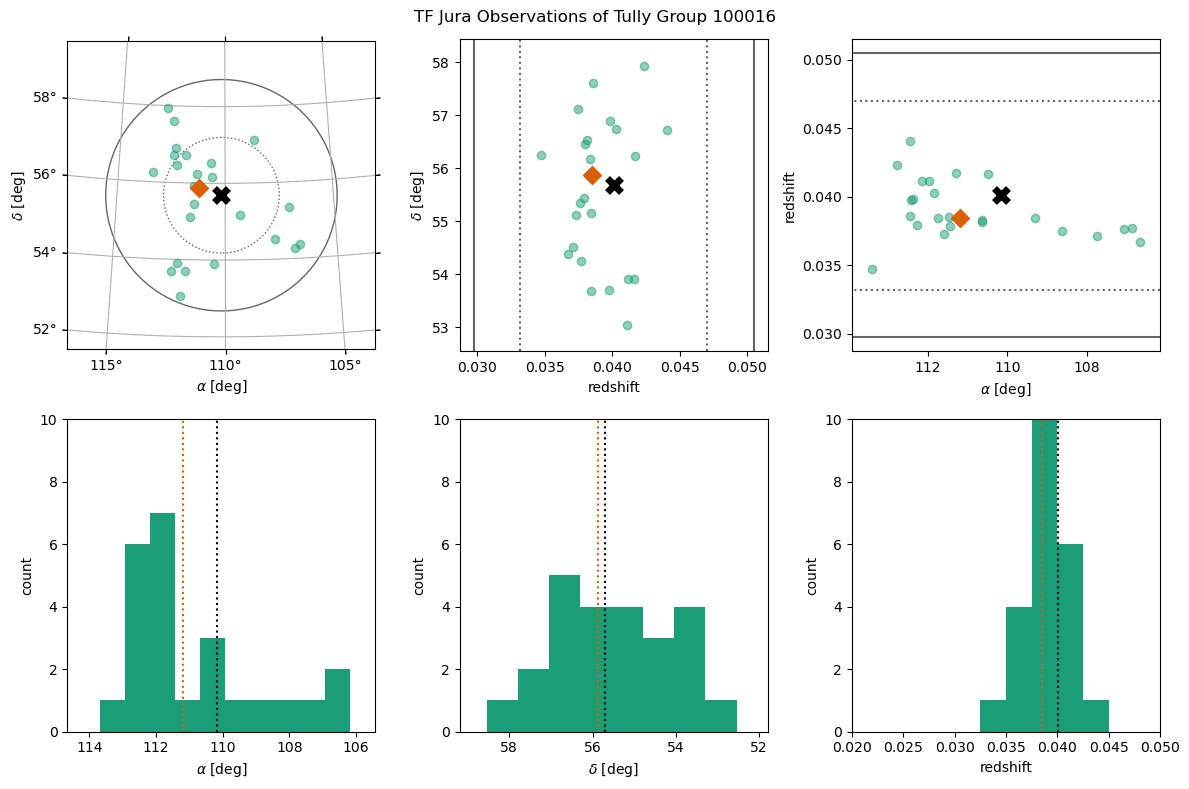

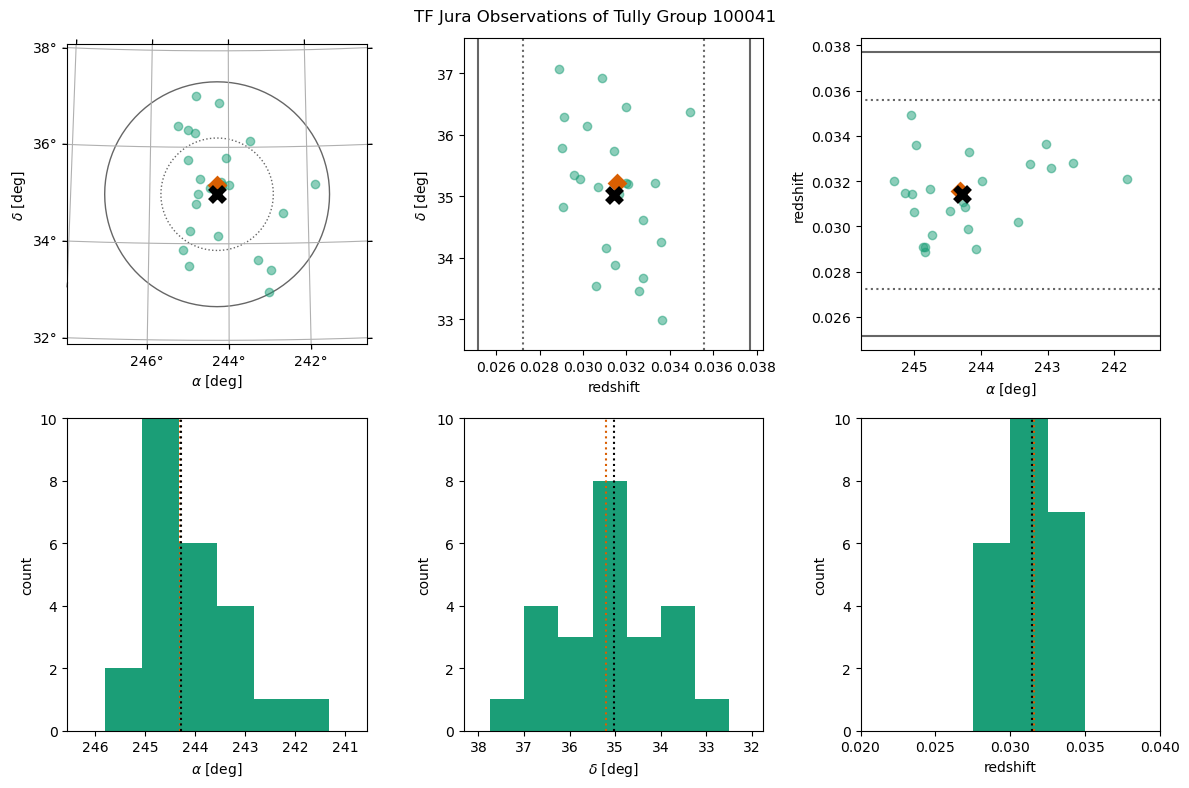

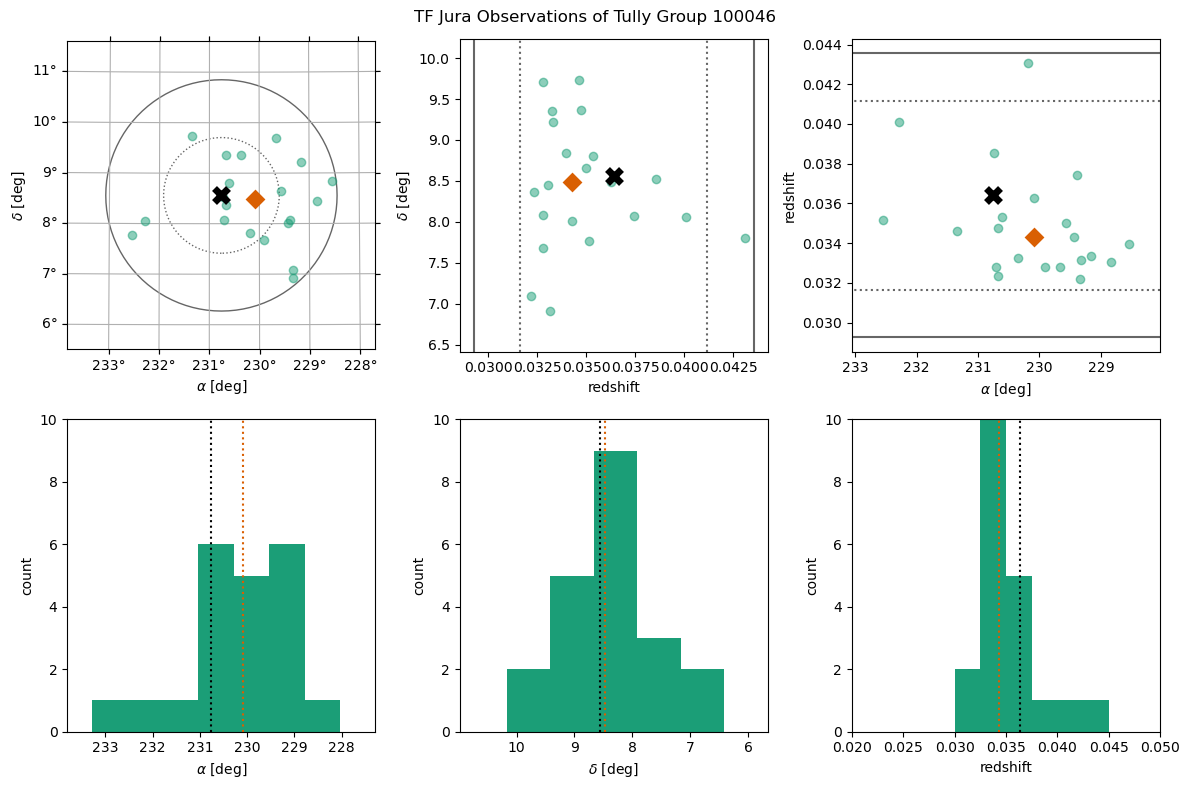

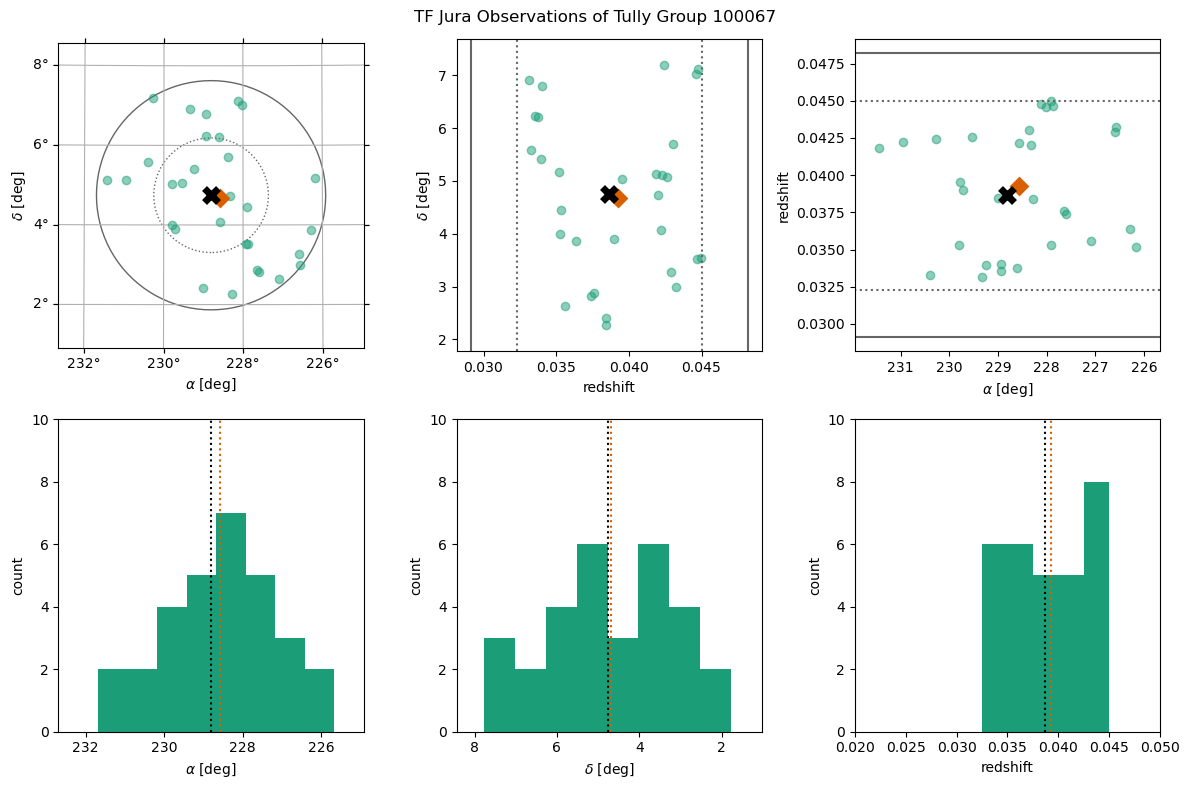

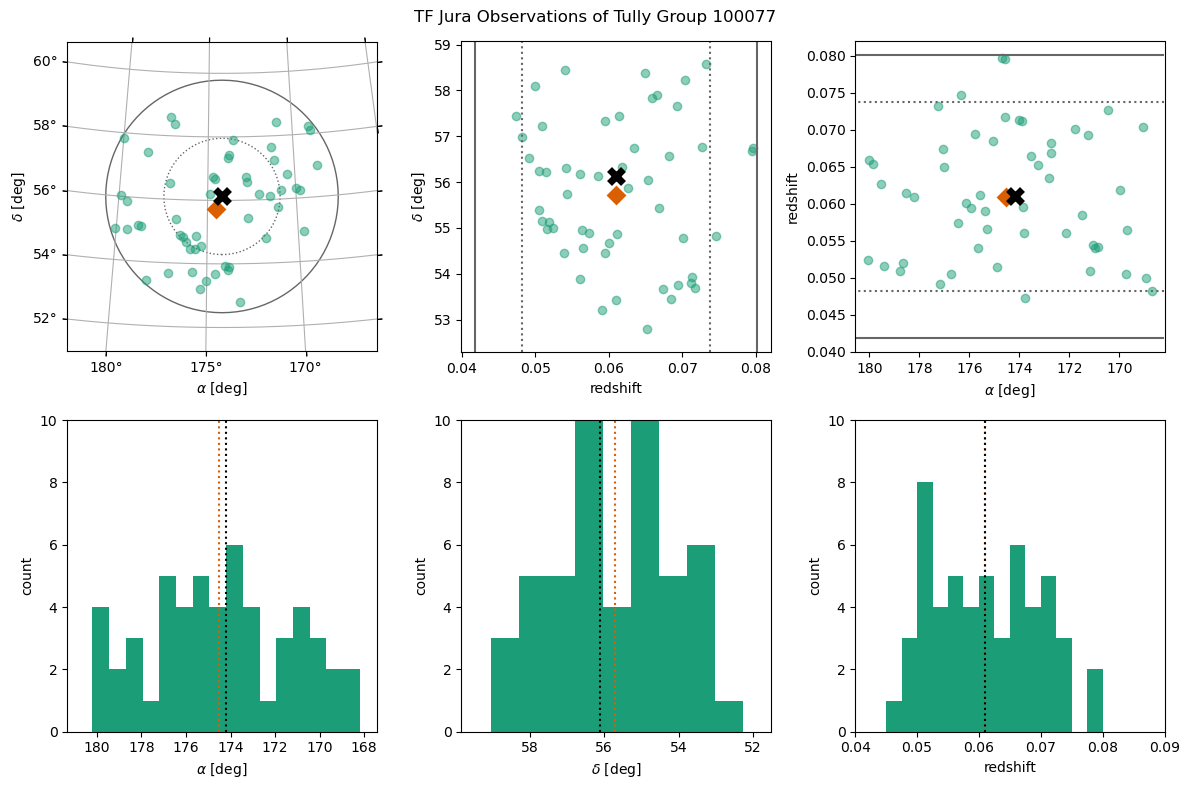

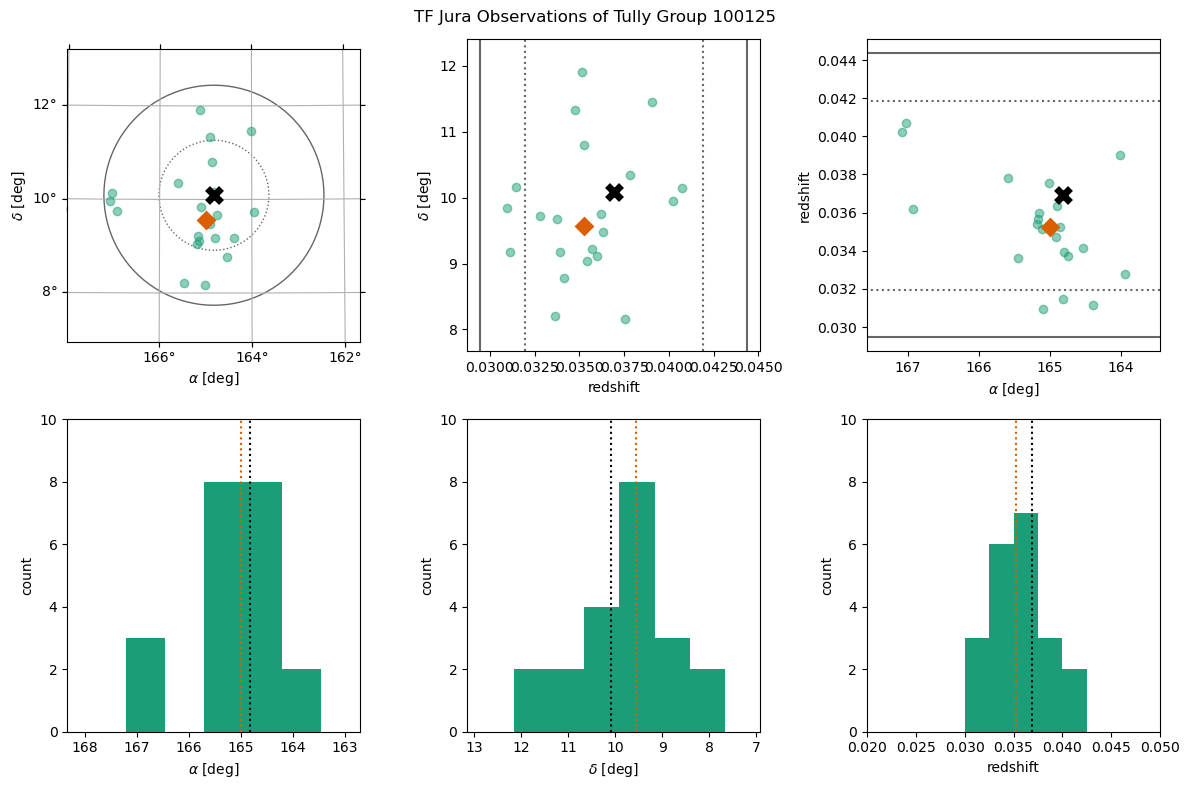

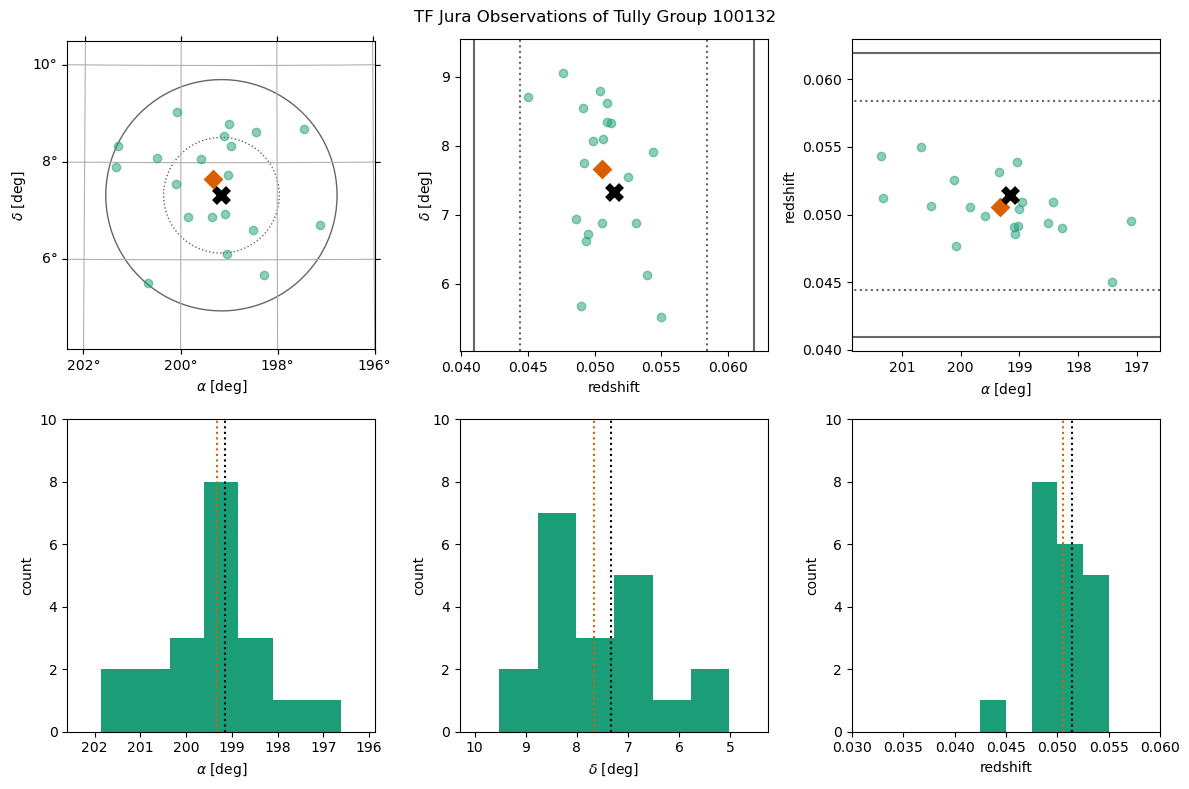

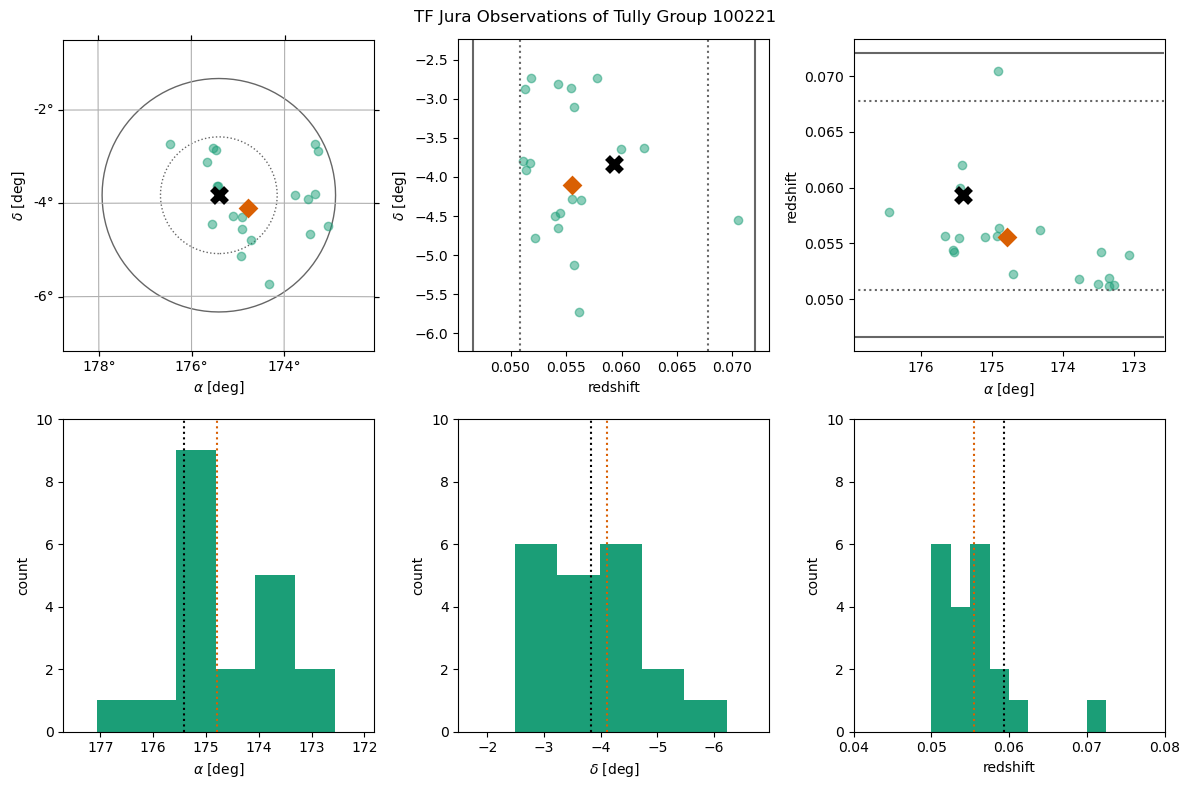

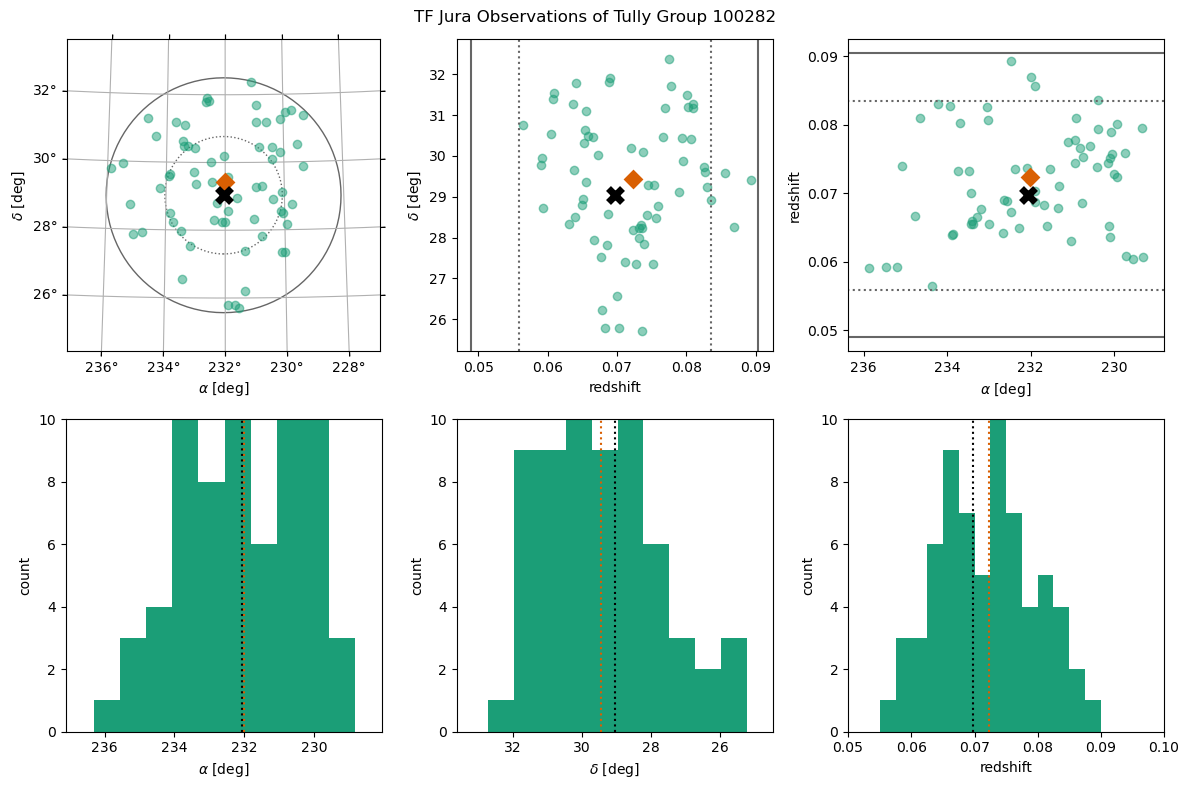

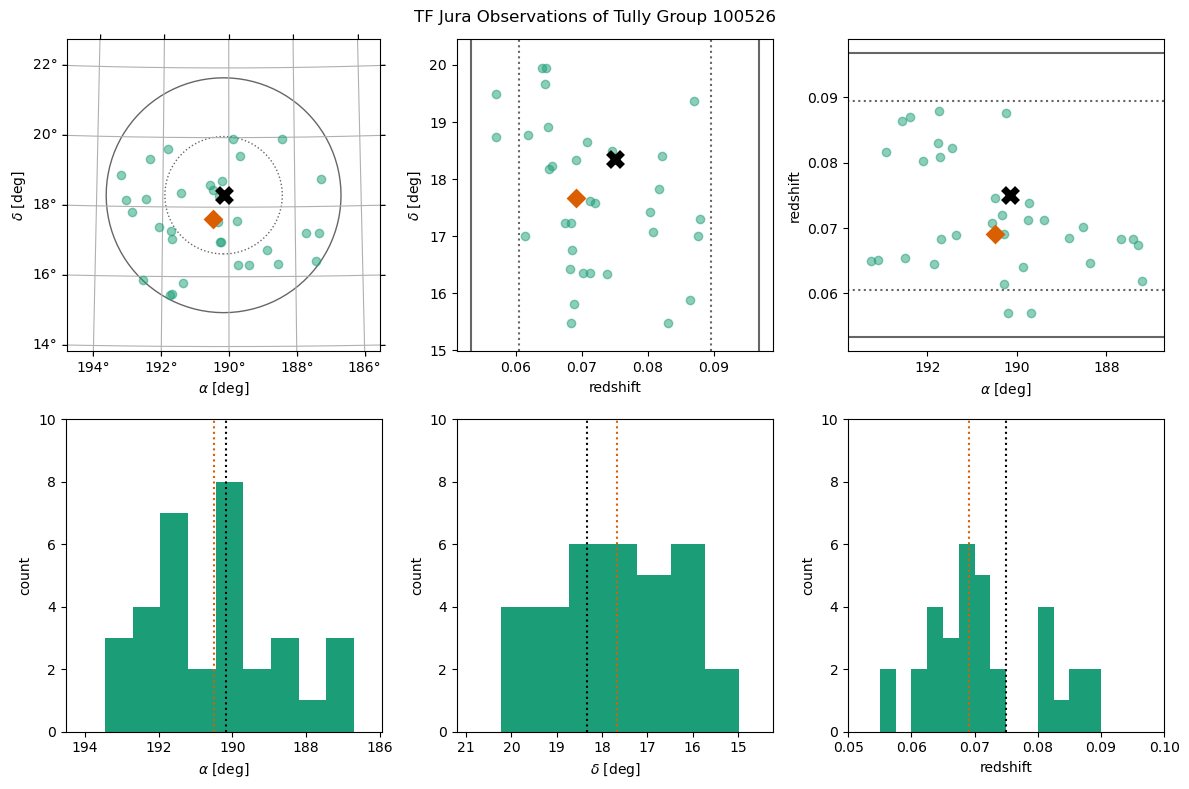

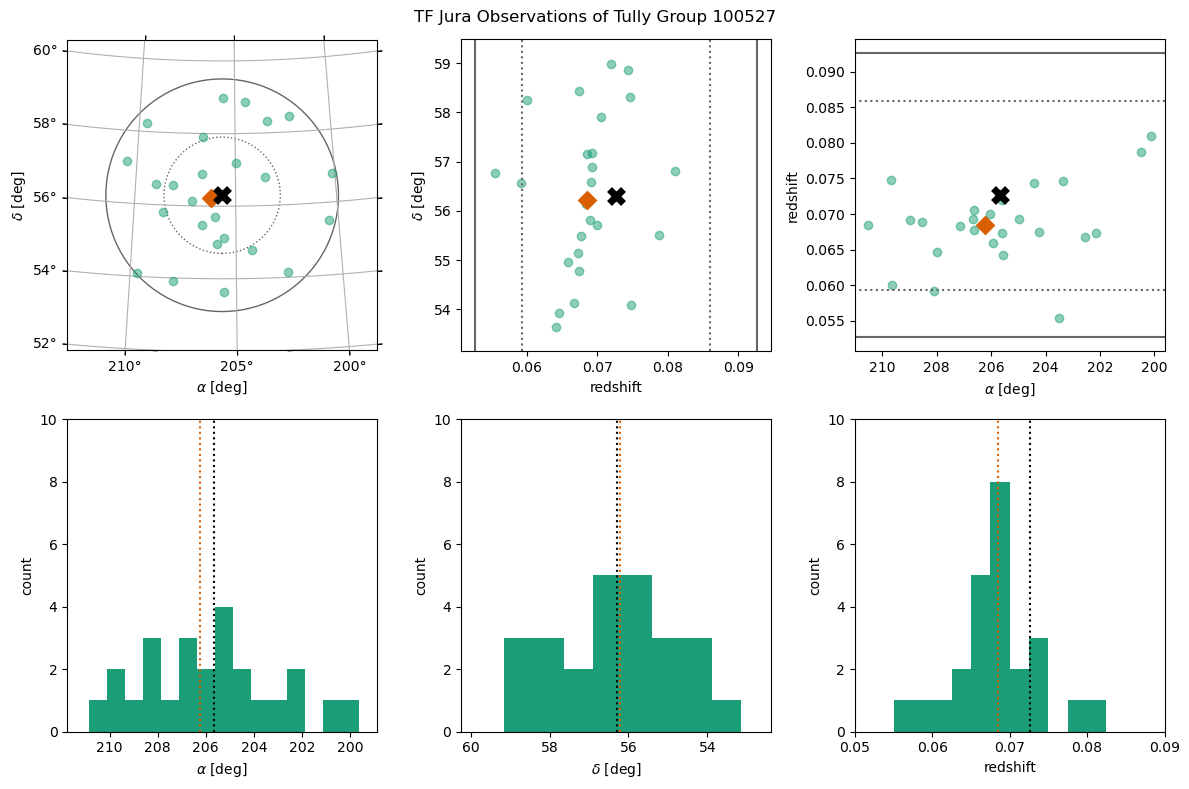

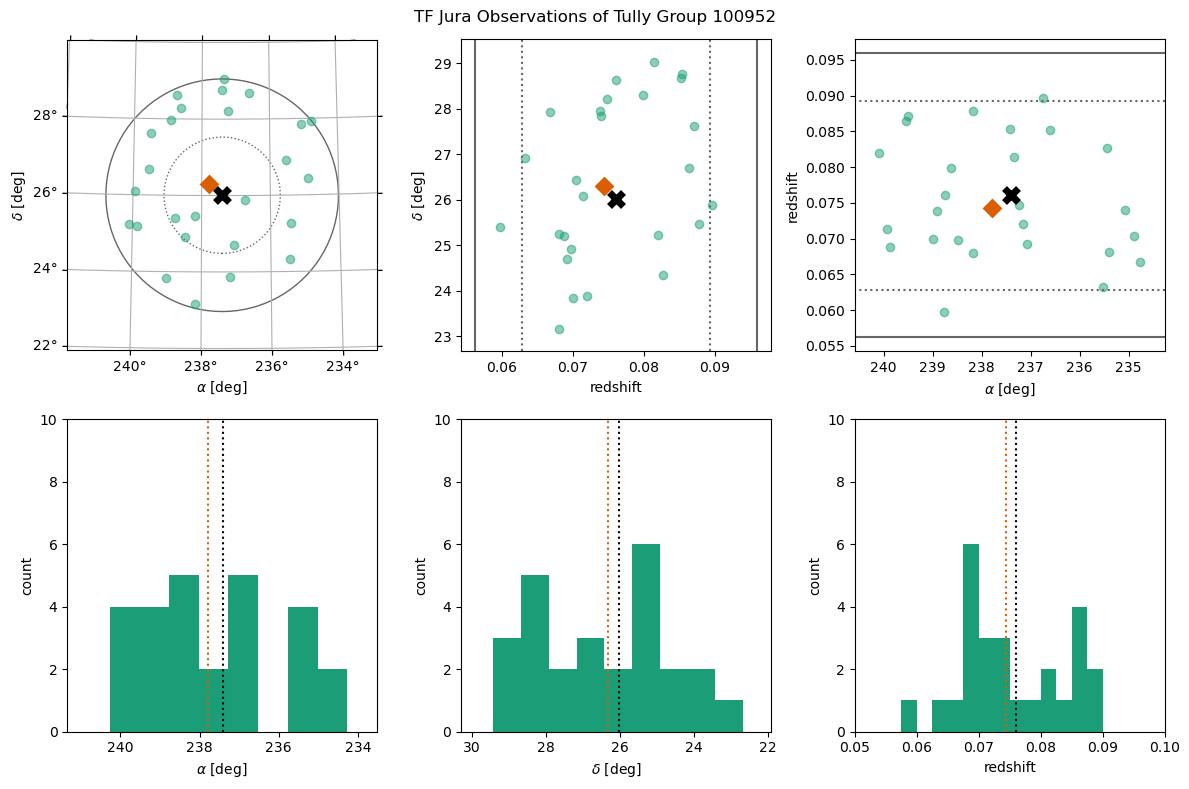

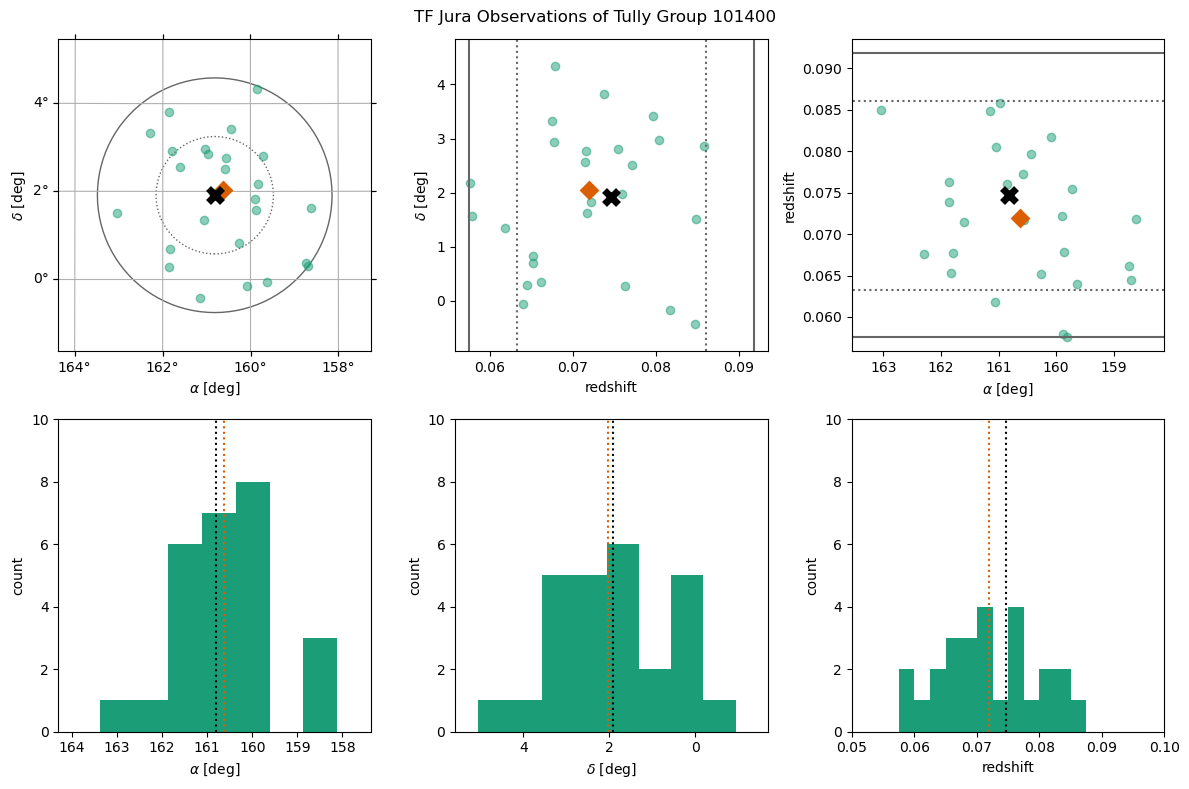

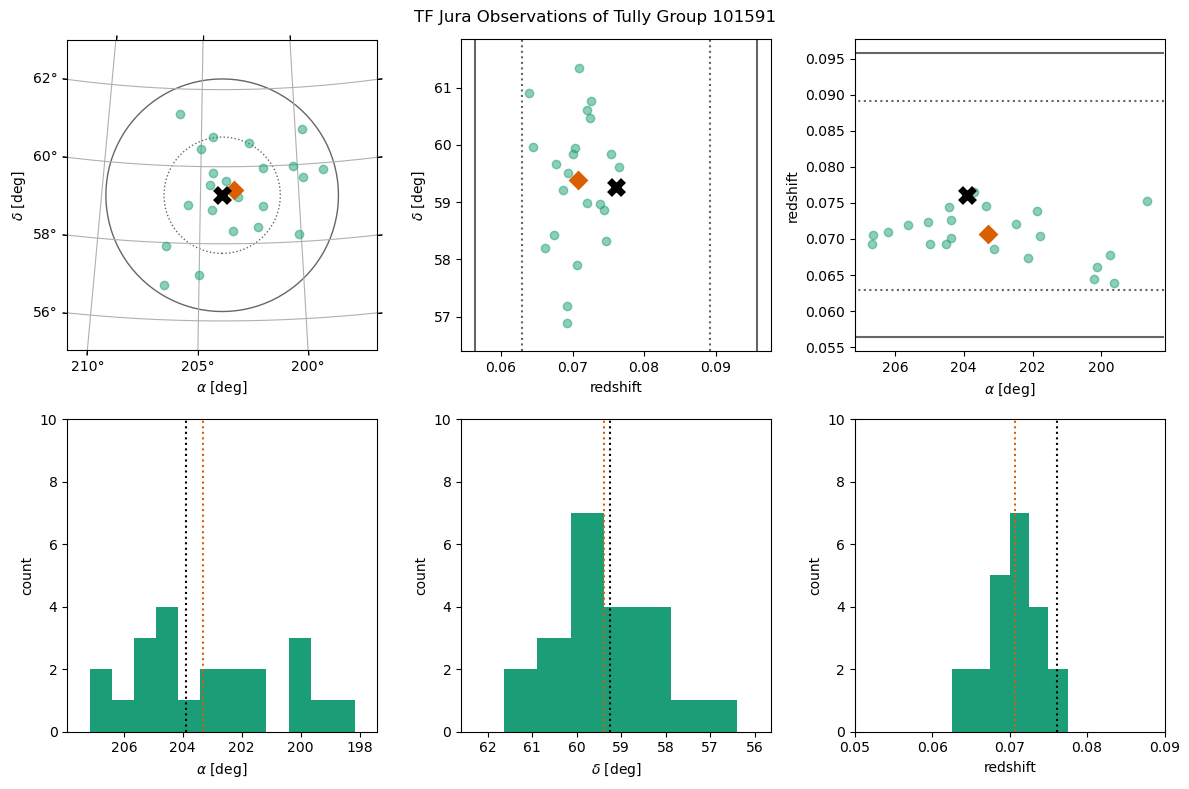

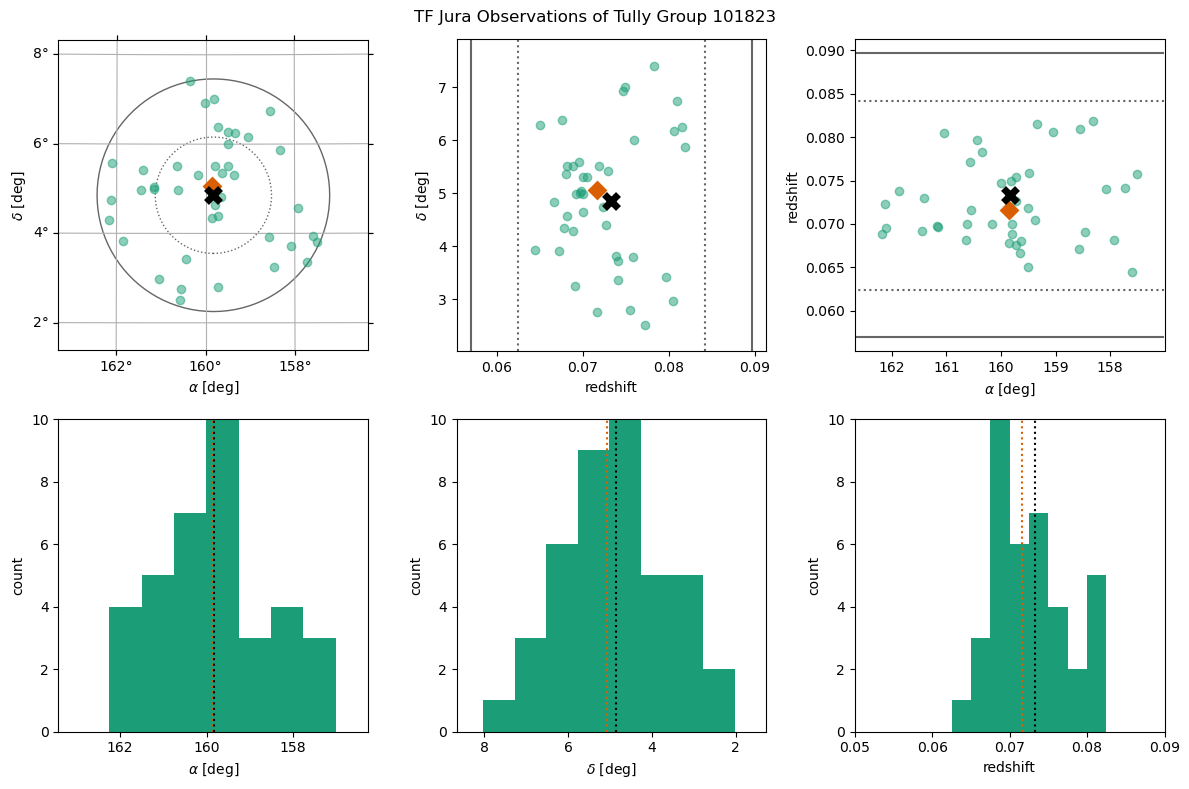

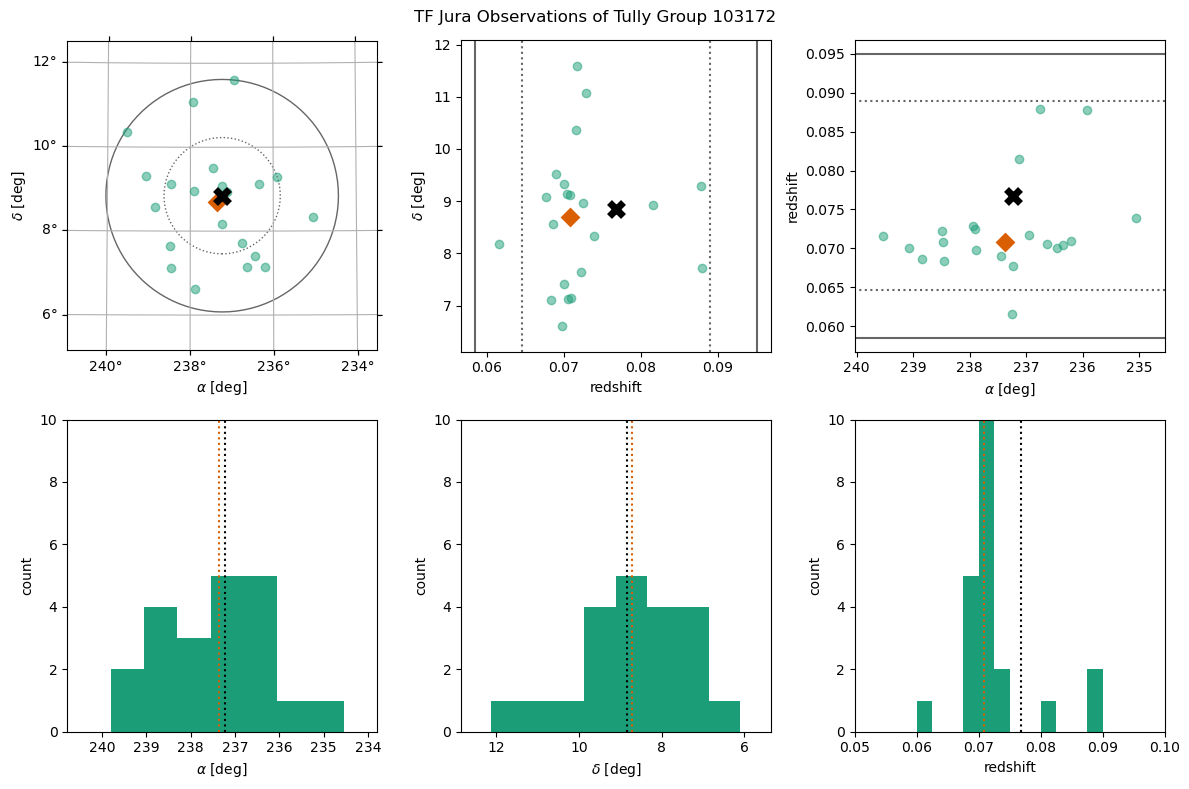

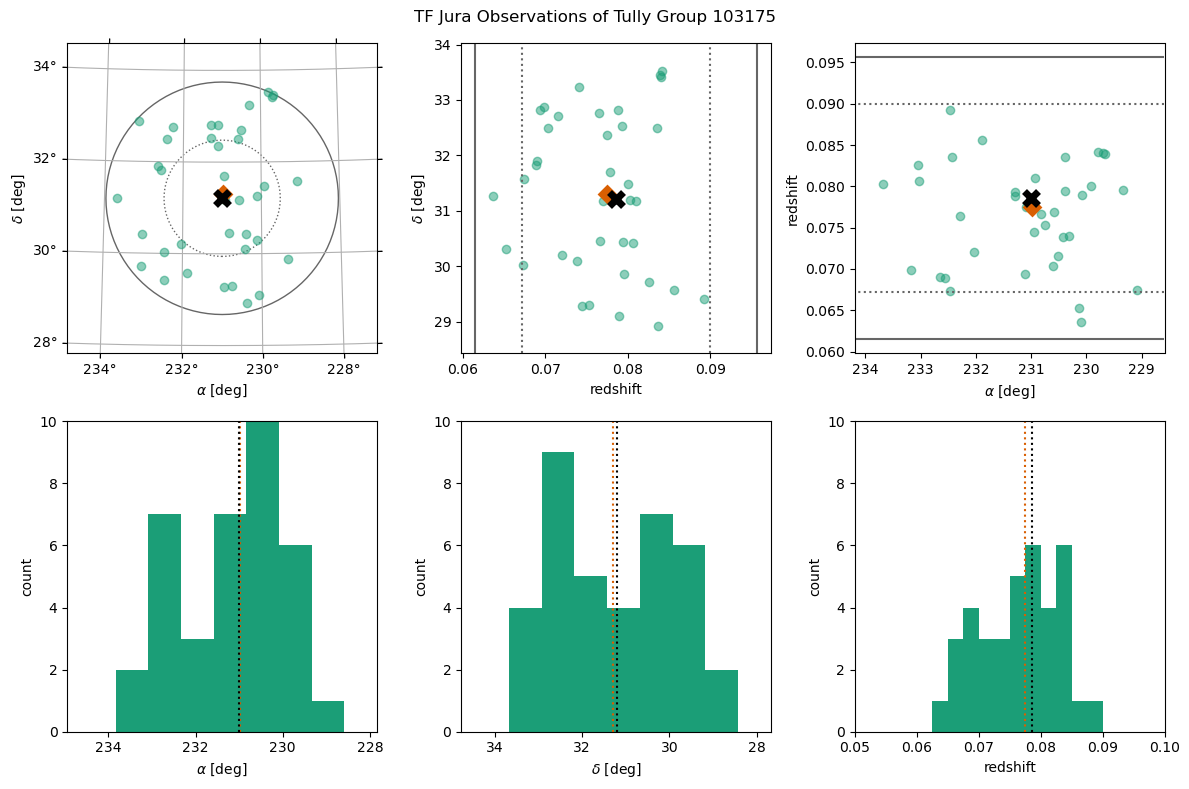

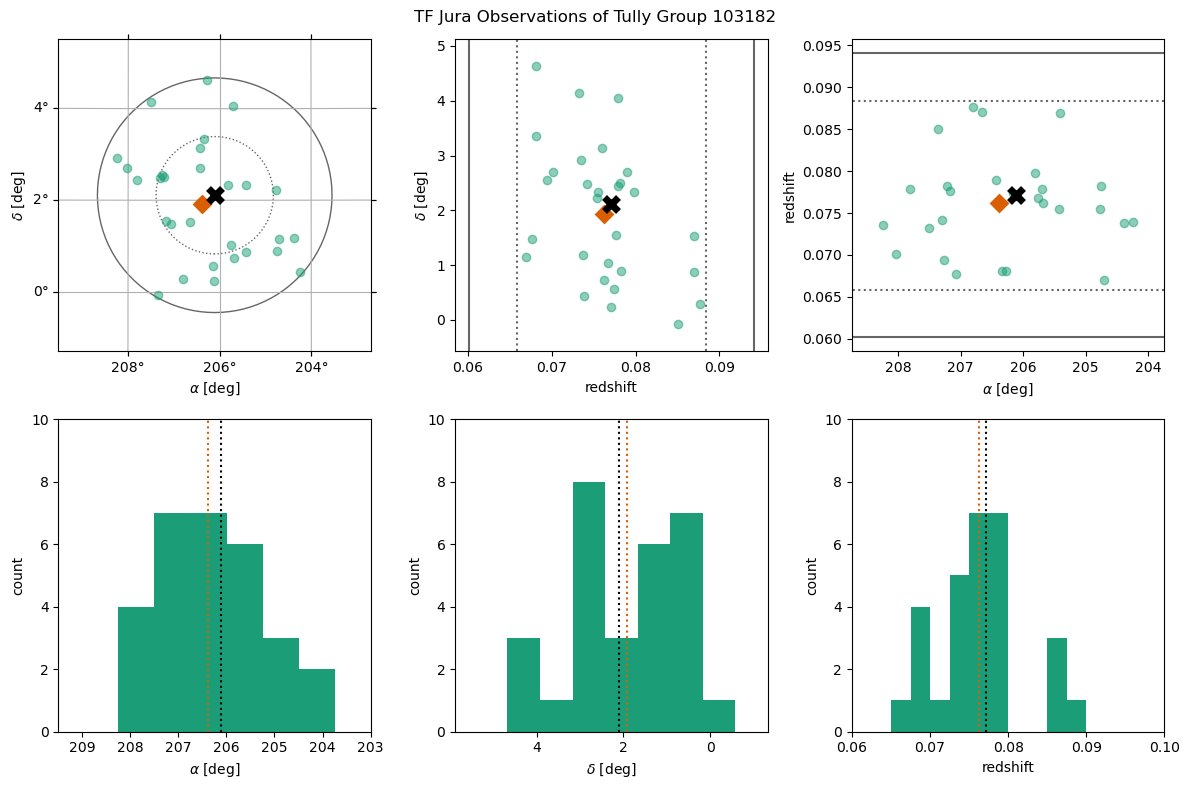

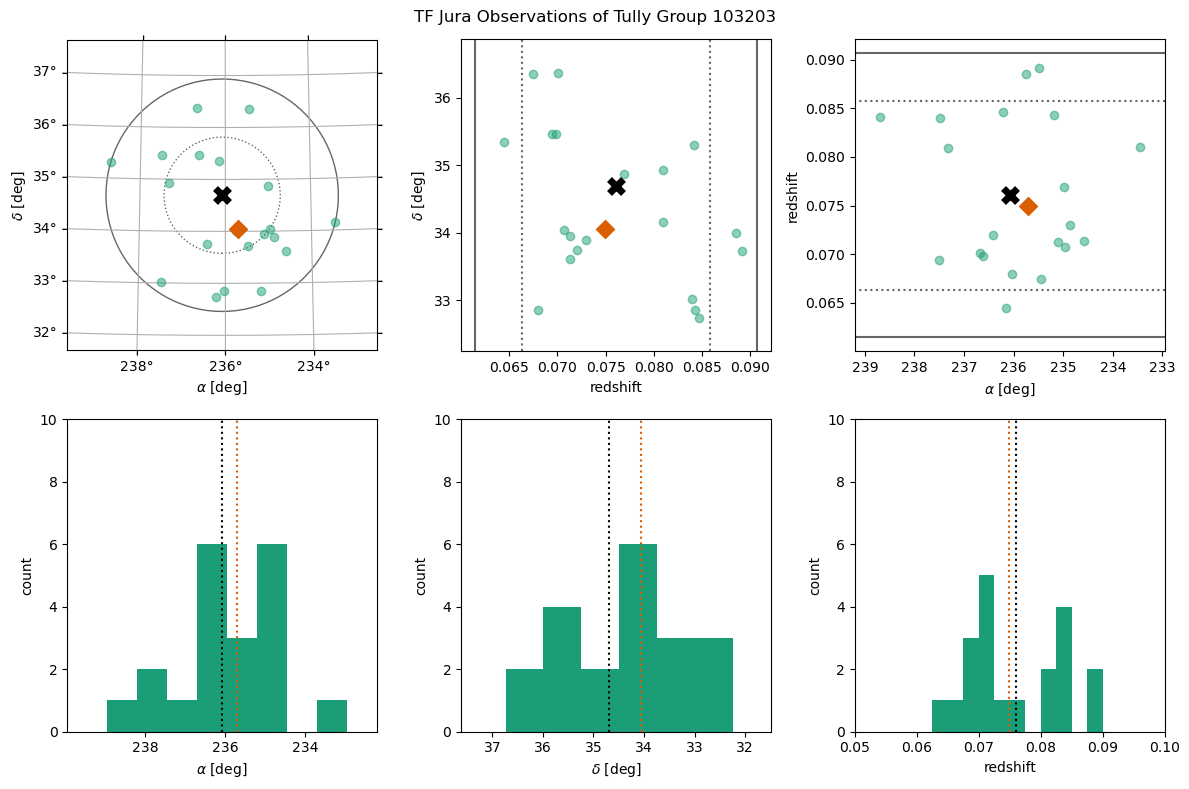

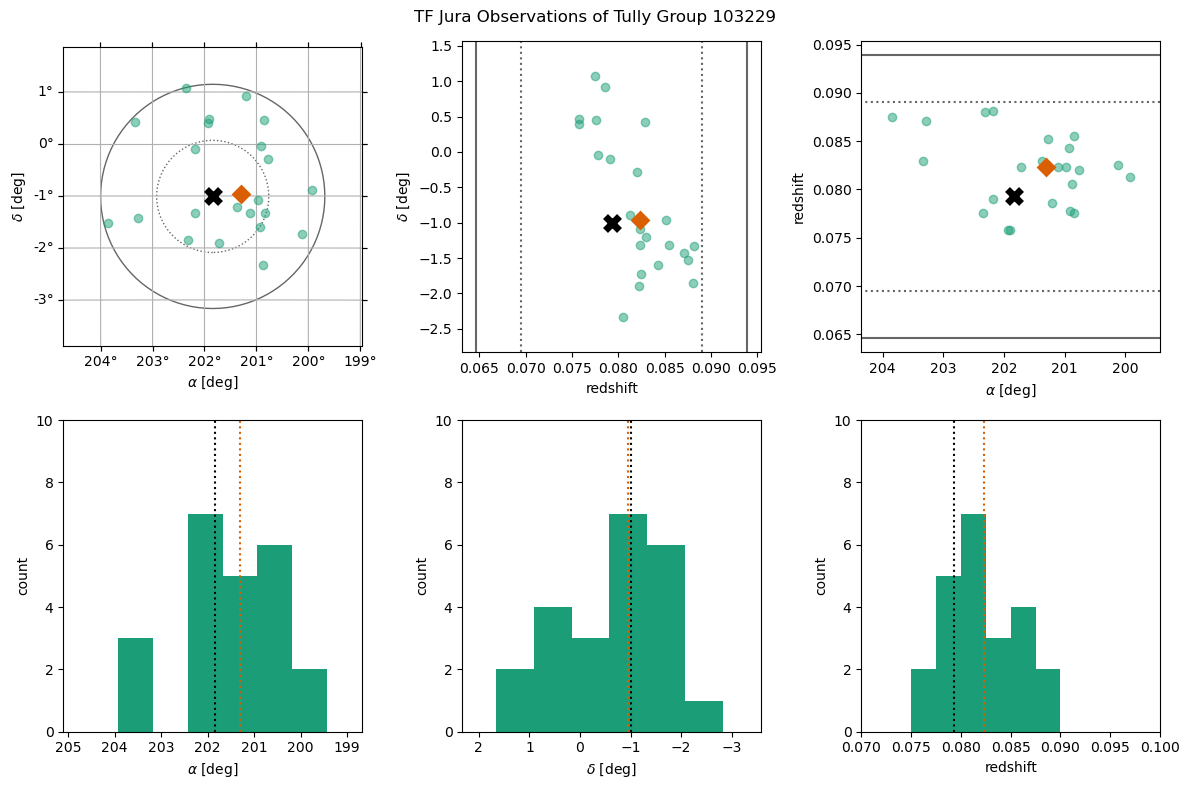

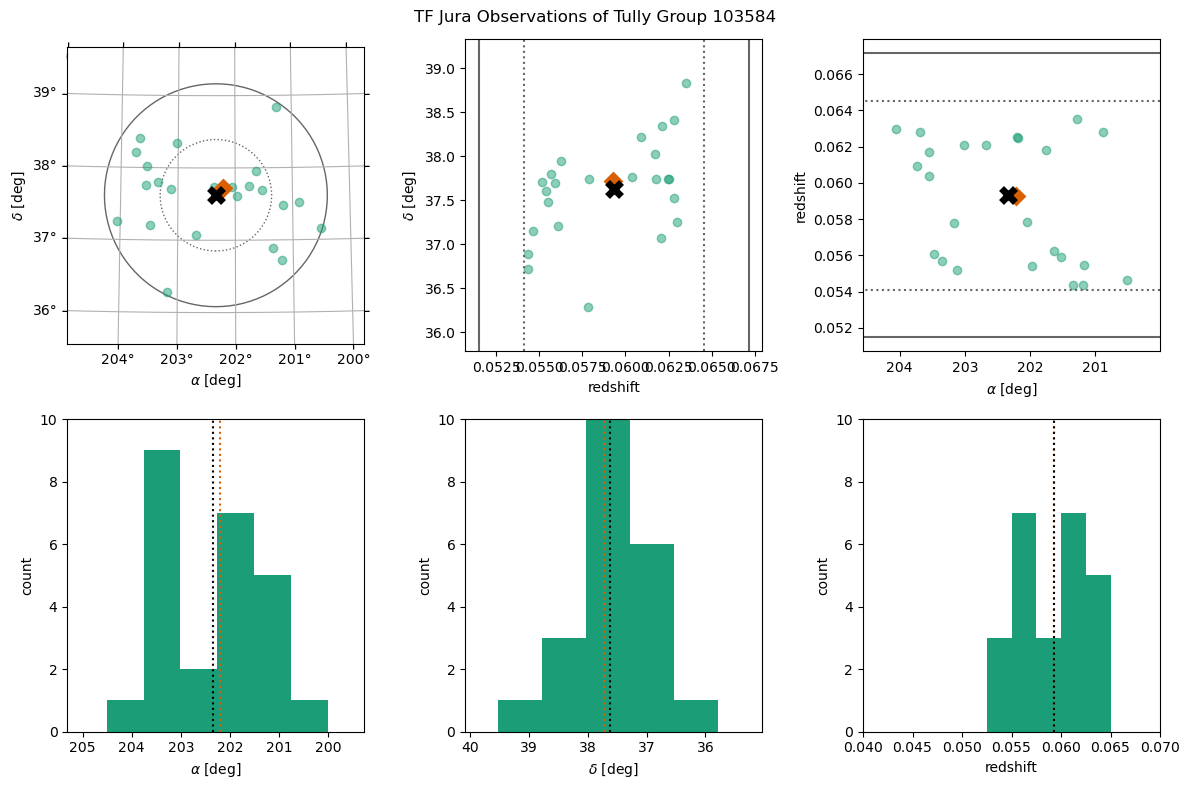

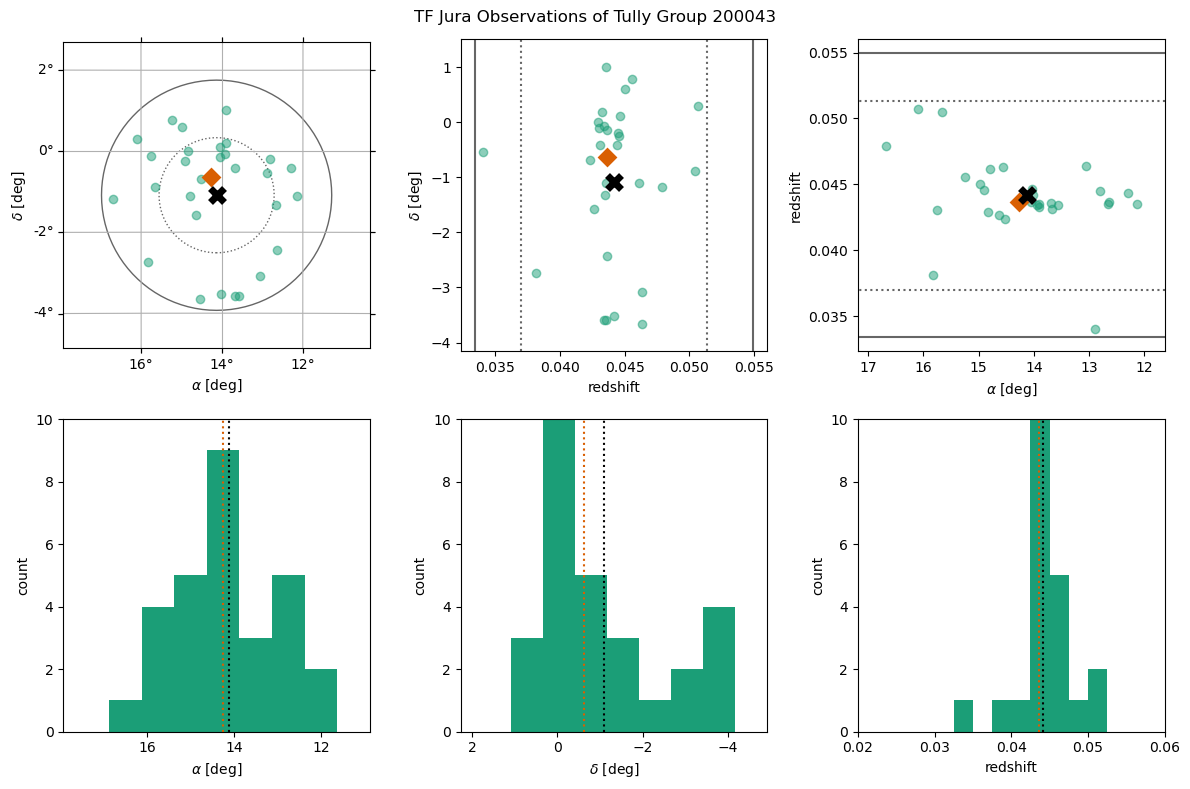

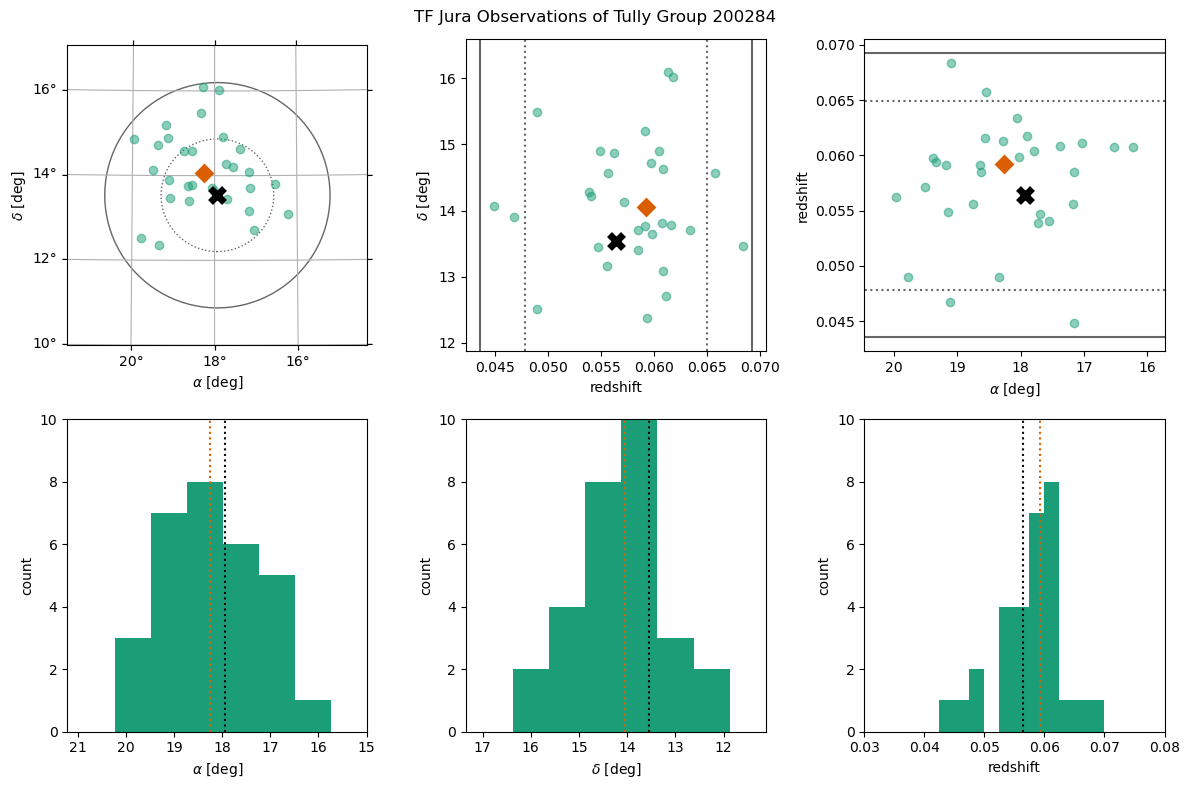

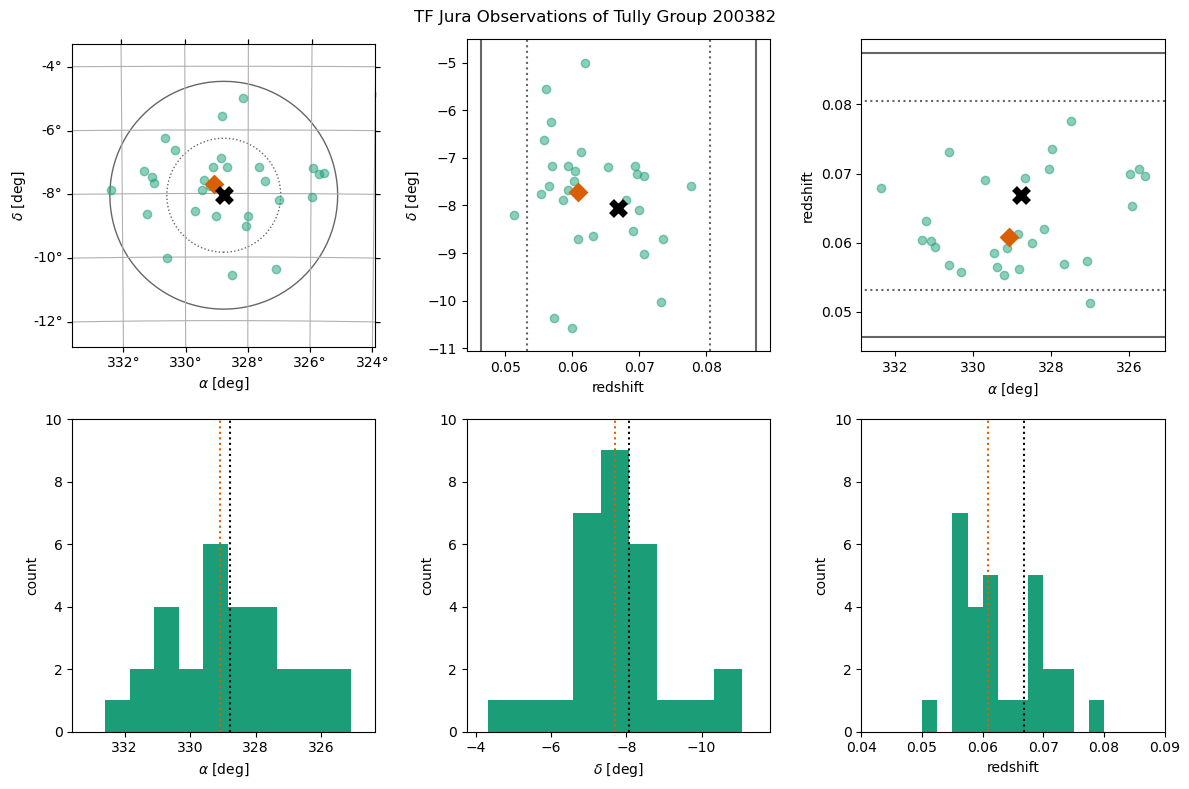

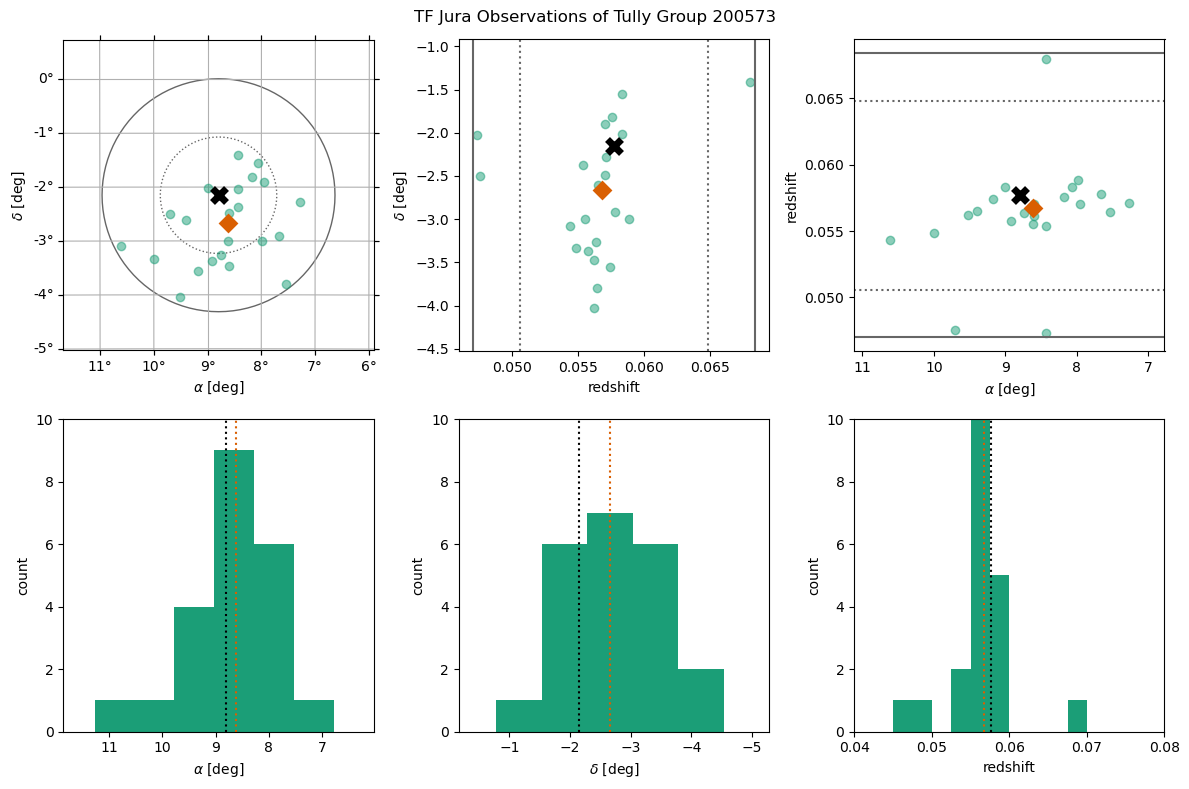

In [51]:
for cluster_id in sga_clusters.keys():
    if cluster_id in cluster_ids[select]:
        fig = plot_cluster_members(clusters, cluster_id, sgatab_sel, sga_clusters[cluster_id])
        # fig.savefig(f'../../Figures/Y3/TF_Y3_cluster_{cluster_id}_accept.png', dpi=150);

# Build the Calibration Table of SGA Galaxies in Clusters

In [52]:
caltab = None    # Table of selected clusters and SGA galaxies
rejtab = None    # Table of clusters failing the selection

for cluster_id, sga_ids in sga_clusters.items():
    if cluster_id in cluster_ids[select]:
        idx = np.in1d(sgatab['SGA_ID'], sga_ids)
        clustertab = sgatab[idx]
        clustertab['CLUSTER_ID'] = cluster_id
        
        caltab = clustertab if caltab is None else vstack([caltab, clustertab])
    else:
        idx = np.in1d(sgatab['SGA_ID'], sga_ids)
        clustertab = sgatab[idx]
        clustertab['CLUSTER_ID'] = cluster_id
        
        rejtab = clustertab if rejtab is None else vstack([rejtab, clustertab])

if caltab is not None: 
    print(len(caltab))
elif caltab is None: 
    print('no groups')
    
caltab.write('SGA-2020_iron_Vrot_cluster_calib_z0p1.fits', overwrite=True)
caltab[['CLUSTER_ID', 'SGA_ID', 'R_MAG_SB26_CORR', 'R_MAG_SB26_ERR_CORR', 'V_0p4R26', 'V_0p4R26_err']]

921


<Table length=921>
CLUSTER_ID   SGA_ID  ...      V_0p4R26         V_0p4R26_err   
  int32     float64  ...      float64            float64      
---------- --------- ... ------------------ ------------------
    100002    2056.0 ...  34.20494444899026 1.0197240309578985
    100002    8508.0 ...  172.8574615813242 2.1302287257704067
    100002  246089.0 ...  52.01023631530545 1.5703008099350524
    100002  272621.0 ...  34.73733152192727 11.748787941066253
    100002  277652.0 ... 37.284043662521526 1.2869518472180153
    100002  278987.0 ...   22.7940568565022 1.0895708890344693
    100002  284683.0 ...  32.97157734069089 15.250674158992112
    100002  351331.0 ...  45.41493612274646 12.353956734169145
    100002  358009.0 ...  42.23435737720398  3.371740355331709
    100002  396108.0 ... 162.49787571322244  16.47847986686709
       ...       ... ...                ...                ...
    200573  856565.0 ... 152.26870983578794  5.465600386413566
    200573  871148.0 ... 103.93667932470717   5.52096120222646
    200573  875881.0 ... 208.19963928319325  2.744312921919281
    200573 1044992.0 ... 159.16699549311045 3.5361768572591132
    200573 1058048.0 ... 160.57971168697452 1.9998460349637552
    200573 1068500.0 ... 158.05324598240335   9.08364494365171
    200573 1163809.0 ... 163.73915262761216 2.5676520571700063
    200573 1299624.0 ...  103.7501954675295    2.5799848047371
    200573 1327094.0 ... 183.65325316514694  3.949186129453711
    200573 1421985.0 ... 198.65854474816106 3.8517049373405463

In [53]:
# Save SGA IDs for each cluster that is part of the calibration (for Alex's Bayesian calibration)
for cluster in np.unique(caltab['CLUSTER_ID']):
    output_filename = 'output_' + str(cluster) + '.txt'
    # SGA_IDs_in_cluster = Table()
    # SGA_IDs_in_cluster['SGA_ID'] = c_4r_in_cluster[i]
    caltab[['SGA_ID']][caltab['CLUSTER_ID'] == cluster].write(output_filename, 
                                                              format='ascii.commented_header', 
                                                              overwrite=True)

In [54]:
if rejtab is None: 
    print('no rejects')
else:
    print(len(rejtab))
    rejtab[:5]

128


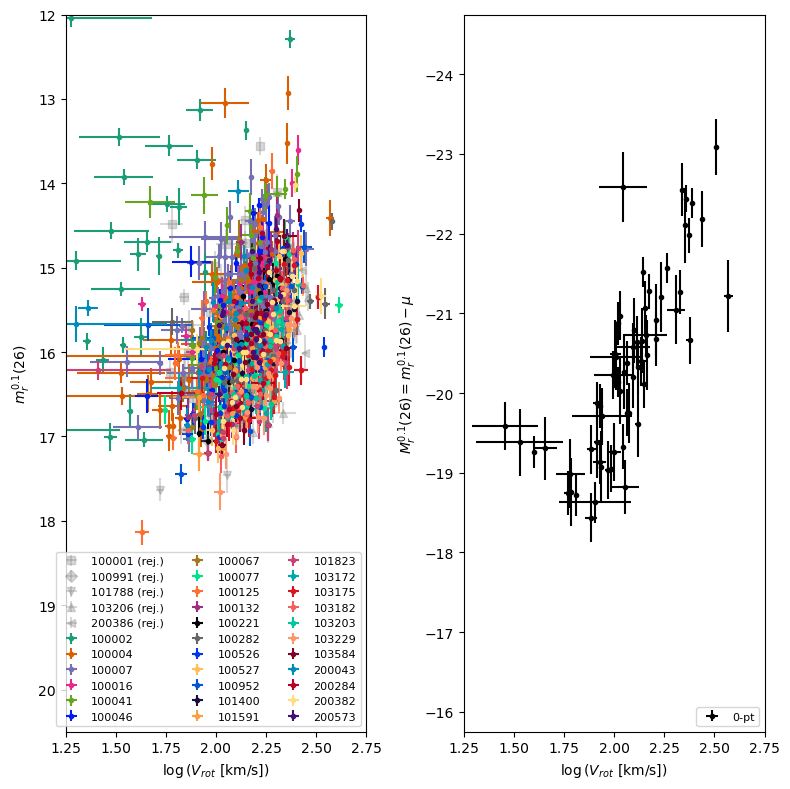

In [55]:
fig, axes = plt.subplots(1, 2, figsize=(8,8), sharex=True, tight_layout=True)

logV0 = 0

ax = axes[0] 

#- Plot galaxies with failed cluster selections.
if rejtab is not None: 
    _cluster_ids = np.unique(rejtab['CLUSTER_ID'])
    markers = 'sDv^<>'
    for j, _cluster_id in enumerate(_cluster_ids):
        select_cluster = np.in1d(rejtab['CLUSTER_ID'], _cluster_id)
    
        #- Store independent variable for each cluster
        logv = np.log10(rejtab['V_0p4R26'][select_cluster].data) - logV0
        logv_err = 0.434*rejtab['V_0p4R26_err'][select_cluster].data / rejtab['V_0p4R26'][select_cluster].data
    
        #- Store dependent variable for each cluster
        mr26 = rejtab['R_MAG_SB26_CORR'][select_cluster].data
        mr26_err = rejtab['R_MAG_SB26_ERR_CORR'][select_cluster].data
        
        ax.errorbar(x=logv, y=mr26, xerr=logv_err, yerr=mr26_err, 
                    fmt=markers[j % 6], markersize=6, color='gray', alpha=0.3, label=f'{_cluster_id} (rej.)')

#- Plot galaxies and clusters passing all selections.
_cluster_ids = np.unique(caltab['CLUSTER_ID'])

for _cluster_id in _cluster_ids:
    select_cluster = np.in1d(caltab['CLUSTER_ID'], _cluster_id)

    #- Store independent variable for each cluster
    logv = np.log10(caltab['V_0p4R26'][select_cluster].data) - logV0
    logv_err = 0.434*caltab['V_0p4R26_err'][select_cluster].data / caltab['V_0p4R26'][select_cluster].data

    #- Store dependent variable for each cluster
    mr26 = caltab['R_MAG_SB26_CORR'][select_cluster].data
    mr26_err = caltab['R_MAG_SB26_ERR_CORR'][select_cluster].data
    
    ax.errorbar(x=logv, y=mr26, xerr=logv_err, yerr=mr26_err, fmt='.', label=f'{_cluster_id}')

ax.set(xlim=[1.25, 2.75],
       xlabel=r'$\log{(V_{rot}~[\mathrm{km/s}]}$)',
       ylim=[20.5, 12],
       ylabel=r'$m_r^{0.1} (26)$')
ax.legend(loc='lower right', fontsize=8, ncol = 3)

#- Plot the 0-pt calibrators
ax = axes[1]

logv = np.log10(zeroptab['V_0p4R26'].data) - logV0
logv_err = 0.434*zeroptab['V_0p4R26_err'].data / zeroptab['V_0p4R26'].data
mr26 = zeroptab['R_ABSMAG_SB26'].data
mr26_err = zeroptab['R_ABSMAG_SB26_err'].data

ax.errorbar(x=logv, y=mr26, xerr=logv_err, yerr=mr26_err, fmt='k.', label='0-pt')
ax.set(xlim=[1.25, 2.75],
       xlabel=r'$\log{(V_{rot}~[\mathrm{km/s}]}$)',
       ylim=[-15.75, -24.75],
       ylabel=r'$M_r^{0.1}(26) = m_r^{0.1}(26) - \mu$')
ax.legend(loc='lower right', fontsize=8);

# fig.savefig('../../Figures/Y3/TF_Y3_cluster_calibration_0pt.png', dpi=150);

# Apply the Joint TFR Fit

In [56]:
#- Extract successful clusters
_cluster_ids = np.unique(caltab['CLUSTER_ID'])
m = len(_cluster_ids)

#- Pack the results into arrays data and cov.
logV, logV_err = [], []
mag, mag_err = [], []

# logV0 = 2.25
logV0 = np.median(np.concatenate([np.log10(caltab['V_0p4R26']), 
                                  np.log10(zeroptab['V_0p4R26'])]))
print('logV0 =', logV0)

# Start with the zero-point calibrators
logV.append(np.log10(zeroptab['V_0p4R26']) - logV0)
logV_err.append(0.434*zeroptab['V_0p4R26_err'] / zeroptab['V_0p4R26'])
mag.append(zeroptab['R_ABSMAG_SB26'])
mag_err.append(zeroptab['R_ABSMAG_SB26_err'])

#- Loop over the SGA clusters
for k, _cluster_id in enumerate(_cluster_ids):
    select_cluster = np.in1d(caltab['CLUSTER_ID'], _cluster_id)
    logV.append(np.log10(caltab['V_0p4R26'][select_cluster]) - logV0)
    logV_err.append(0.434*caltab['V_0p4R26_err'][select_cluster] / caltab['V_0p4R26'][select_cluster])
    mag.append(caltab['R_MAG_SB26_CORR'][select_cluster])
    mag_err.append(caltab['R_MAG_SB26_ERR_CORR'][select_cluster])

logV0 = 2.1577427545157697


## Multiline Fit using HyperFit

In [50]:
bounds = [[-20, 0]]                    # Bounds on a (slope)
bounds += [(-40,0)] + m*[(-20, 20)]    # Bounds on b (intercepts: 0-pt + clusters)
bounds += [(0,5)]                      # Bounds on sigma

results = hyperfit_line_multi(logV, mag, logV_err, mag_err, bounds, scatter=1)

a, b, sig_tfr, cov_tfr, tfr_mcmc_samples, hf_tfr = results

     fun: -74978.98730330322
     jac: array([-0.00582077, -0.02619345, -0.28376232, -0.0334694 , -0.34051479,
        0.03783498,  0.18189893, -0.05675246, -0.14406395, -0.16152625,
       -0.22264428, -0.04365574,  0.03201421, -0.08294591,  0.09458744,
        0.17462297,  0.03492459, -0.01455191,  0.13096723, -0.00291038,
        0.07712514, -0.13824318,  0.02328306,  0.10040821,  0.11496012,
       -0.10622897, -0.11932569, -0.03201421,  0.08585629,  0.02473825,
        0.068394  ])
 message: 'Optimization terminated successfully.'
    nfev: 171135
     nit: 366
 success: True
       x: array([ -6.64151591, -20.86273796,  12.02250081,  14.71702781,
        15.02524205,  14.99530736,  14.6511458 ,  14.86628978,
        15.11683098,  16.15695441,  14.7343631 ,  15.597192  ,
        15.90689847,  16.34968641,  16.10365328,  16.24770762,
        16.26363064,  16.51161283,  16.33522171,  16.42259105,
        16.43338785,  16.65949845,  16.39082094,  16.57250085,
        16.80077567,  16

100%|██████████| 1000/1000 [03:13<00:00,  5.16it/s]


Niterations/Max Iterations:  1000 / 100000
Integrated ACT/Min Convergence Iterations:  [94.5432201  92.13523205 85.70045079 92.92645198 86.23063416 85.13653021
 93.58333623 92.4414627  91.83097081 89.90581315 84.51767067 88.70368837
 90.44038671 89.55492761 92.11235568 86.83659474 91.00956091 91.72147221
 89.60870483 87.74914293 90.76832456 93.52631052 90.32577211 93.96952115
 84.91773426 86.28898546 89.29881997 90.50762584 97.09871188 85.81758076
 91.69967408] / 4854.935594118587


100%|██████████| 1000/1000 [03:15<00:00,  5.11it/s]


Niterations/Max Iterations:  2000 / 100000
Integrated ACT/Min Convergence Iterations:  [132.97559866 117.34017956 126.42394364 117.65174369 113.35373997
 130.85836635 119.96870178 121.53800387 123.60838035 119.01384802
 120.35161905 136.24786539 119.43510422 119.40855863 117.73076678
 122.67265385 123.44406589 125.56609325 127.40512007 117.12760835
 125.73154535 121.06866718 117.54823158 123.99407075 122.85459502
 122.33547017 128.23578821 125.07483327 124.58126192 125.06012373
 131.9823056 ] / 6812.393269724314


100%|██████████| 1000/1000 [03:20<00:00,  5.00it/s]


Niterations/Max Iterations:  3000 / 100000
Integrated ACT/Min Convergence Iterations:  [139.72242589 142.2811416  145.43994391 134.89102208 129.35676082
 154.82539557 147.642117   147.09512731 152.5954317  154.14699854
 156.40590236 147.27927691 151.19319894 142.85413802 141.78601236
 141.72788614 156.79852296 134.52558035 143.85407371 138.83013784
 152.52039657 132.96535357 144.69014389 154.33795351 148.77190945
 154.00808781 153.34523641 146.19507124 141.35373996 159.49480362
 138.35285391] / 7974.740181214226


100%|██████████| 1000/1000 [03:24<00:00,  4.90it/s]


Niterations/Max Iterations:  4000 / 100000
Integrated ACT/Min Convergence Iterations:  [169.234239   153.71373276 159.41456156 152.82384069 137.88096519
 166.2462554  181.69165074 163.53979961 153.2991184  146.37384743
 167.93730386 149.37562993 168.1518798  153.58921521 164.49422802
 170.65655787 164.79760438 162.08481368 176.24847522 151.04738596
 160.83070659 152.50262751 150.38107192 174.98653371 153.09920254
 153.80041383 165.04532111 172.51773192 163.8929571  169.28032053
 167.06325853] / 9084.582537076825


100%|██████████| 1000/1000 [03:27<00:00,  4.81it/s]


Niterations/Max Iterations:  5000 / 100000
Integrated ACT/Min Convergence Iterations:  [194.22754617 171.09342392 187.41476432 186.50852127 151.18258115
 187.38820815 190.30296788 199.80929139 178.97135463 179.85339676
 198.20517416 179.38337964 187.28964074 173.08116347 190.11677753
 187.37421327 193.50722151 172.2890891  189.66201099 187.57172612
 191.35081395 185.75948118 164.06367485 192.27597055 170.65561227
 175.62780953 179.16316456 181.65782841 176.70022278 190.10999037
 179.29786921] / 9990.464569544203


100%|██████████| 1000/1000 [03:33<00:00,  4.68it/s]


Niterations/Max Iterations:  6000 / 100000
Integrated ACT/Min Convergence Iterations:  [207.14264459 174.53596231 188.35726105 207.63741602 165.14323362
 187.33996672 192.70551639 205.95749039 192.557247   189.52777522
 202.33363827 204.28823491 189.76386668 196.11569894 189.94580005
 183.25868778 194.92366139 179.39228409 189.47660832 186.29954127
 205.74519636 193.57629871 175.77606787 182.71587345 197.40759082
 193.34944798 199.13500922 201.58797906 169.97109691 198.46506764
 184.16634344] / 10381.87080114976


100%|██████████| 1000/1000 [03:34<00:00,  4.65it/s]


Niterations/Max Iterations:  7000 / 100000
Integrated ACT/Min Convergence Iterations:  [209.33144799 193.84787091 201.86987776 215.9550825  188.80048056
 215.58028946 204.85064617 213.54235279 213.93489238 213.30081872
 208.12871815 217.63990387 204.58669765 213.12219451 210.34693755
 220.35937936 207.51551938 195.58457414 216.70199478 190.99585956
 213.43067732 205.35708395 209.92126317 211.0070106  201.79202742
 200.79927425 211.3577942  214.17273946 191.7259801  235.01242345
 197.55432377] / 11750.621172424508


100%|██████████| 1000/1000 [03:37<00:00,  4.60it/s]


Niterations/Max Iterations:  8000 / 100000
Integrated ACT/Min Convergence Iterations:  [215.96296196 186.51067633 210.52148102 212.66991152 210.18627738
 231.5270039  208.60581214 219.33587872 212.82550372 213.39013564
 211.3620934  216.37686243 230.13807078 215.56139848 209.53597391
 234.36136817 215.38302321 198.1739327  219.32364555 197.54094438
 212.78119846 236.85025264 215.6485485  221.8051661  207.54681262
 217.05070279 210.25687907 210.78865254 201.57202778 239.8868528
 200.45135971] / 11994.342639829107


100%|██████████| 1000/1000 [03:34<00:00,  4.66it/s]


Niterations/Max Iterations:  9000 / 100000
Integrated ACT/Min Convergence Iterations:  [220.83544852 211.35125708 224.19978338 229.99628881 215.449762
 252.61029469 243.81903545 231.45305857 223.14679106 232.26674965
 215.34111319 226.46285907 233.42278545 221.98886479 221.35465127
 240.17674585 220.36431054 217.75911921 243.67614569 207.97351689
 231.14946868 248.2389749  231.16814063 225.77909949 222.96762955
 225.94136161 230.2741561  203.87933851 220.5835833  236.48787939
 223.85873022] / 12630.514734637794


100%|██████████| 1000/1000 [03:36<00:00,  4.63it/s]


Niterations/Max Iterations:  10000 / 100000
Integrated ACT/Min Convergence Iterations:  [231.28687657 218.61257612 234.30766695 238.10716682 213.31774015
 252.12643417 251.54520769 232.80172577 237.36025888 227.98009781
 213.05748986 229.826269   232.62998928 220.49414025 227.89138847
 236.33578022 231.15768604 235.5319477  235.52682983 211.27834982
 234.99384636 243.03001476 238.98648665 232.36880815 226.8454131
 232.62159749 233.33691013 213.57415726 233.83550745 224.37261108
 238.76534534] / 12606.321708329002


100%|██████████| 1000/1000 [03:29<00:00,  4.77it/s]


Niterations/Max Iterations:  11000 / 100000
Integrated ACT/Min Convergence Iterations:  [239.93674477 242.5192214  240.15711502 251.41289782 217.78956116
 269.7408253  259.98160208 234.66861691 248.88850424 240.28107885
 226.35273    243.00207085 247.09808477 226.360667   248.13272129
 247.76364023 223.89067943 253.33766649 246.25729815 228.11518199
 255.63057084 237.91312471 245.78163664 235.90268481 244.93841844
 246.4928576  240.34911226 225.99502783 246.44366735 230.5575374
 244.18058384] / 13487.041265167692


100%|██████████| 1000/1000 [03:42<00:00,  4.49it/s]


Niterations/Max Iterations:  12000 / 100000
Integrated ACT/Min Convergence Iterations:  [251.10935942 236.37349236 245.9457411  249.13865827 231.14832043
 263.68370555 262.2940012  236.61219553 250.25790513 243.4455722
 246.78049583 249.30439627 255.01608498 224.8705611  243.15295798
 263.3514525  230.86773084 246.45665978 247.27197412 238.76959721
 263.38335038 233.93863035 250.3283779  242.36560731 251.35130907
 248.86884869 242.22876936 225.12262589 256.19648604 235.35169959
 254.51093381] / 13184.185277627183


100%|██████████| 1000/1000 [03:13<00:00,  5.16it/s]


Niterations/Max Iterations:  13000 / 100000
Integrated ACT/Min Convergence Iterations:  [264.12591835 244.62899257 253.3427228  260.0307036  235.92838056
 274.76639788 277.46291119 257.91596911 261.5465266  250.31350567
 269.6031826  267.5406599  262.04567837 231.71231048 249.12463381
 260.91984847 257.78625561 236.15837496 259.40085486 256.0841145
 277.80165681 248.14008461 257.54247161 262.05688115 262.88448331
 253.09698007 256.866623   235.0513427  270.00884511 244.98471449
 262.47074232] / 13890.082840383058


100%|██████████| 1000/1000 [03:07<00:00,  5.34it/s]


Niterations/Max Iterations:  14000 / 100000
Integrated ACT/Min Convergence Iterations:  [262.51829434 239.91751846 253.89216107 261.42282442 231.86632851
 275.72215114 275.96001791 258.37677683 263.12687131 243.98172281
 266.94164115 266.87341119 257.6565002  237.20044873 262.69410015
 261.58276492 261.7262101  241.32399245 260.33071631 260.78799945
 284.51338355 251.71175342 251.66151457 262.77172816 266.36010401
 258.6011046  267.35389693 242.01489459 275.62922784 249.56058371
 263.36170086] / 14225.669177678941


100%|██████████| 1000/1000 [03:07<00:00,  5.32it/s]


Niterations/Max Iterations:  15000 / 100000
Integrated ACT/Min Convergence Iterations:  [268.10259806 247.46324593 256.72799384 269.59133716 235.59824894
 262.7429254  284.44915843 272.53464451 271.63199114 253.76790871
 266.32822404 274.9296898  258.53748098 253.9731146  256.96802979
 252.02438375 265.48946359 244.07371166 264.1690359  263.58873163
 288.59440412 253.00903066 265.53945564 277.9502794  280.75721427
 274.32175871 273.91376021 248.95765203 272.12709524 260.36283959
 269.8850284 ] / 14429.7202060638


100%|██████████| 1000/1000 [03:24<00:00,  4.88it/s]


Niterations/Max Iterations:  16000 / 100000
Integrated ACT/Min Convergence Iterations:  [261.9910112  255.43070765 256.7796702  270.75231355 242.13945525
 264.00299766 274.11656731 274.55930369 271.90264165 257.53166063
 275.89934739 278.2278433  256.21643585 262.74499372 263.58108353
 252.53759751 270.06430575 249.96046942 265.98793192 268.16210568
 285.06218751 254.30351287 268.53933165 281.01336934 291.31947582
 283.99663959 273.58228476 261.32072222 272.4708591  274.16485598
 271.57238263] / 14565.973791063974


100%|██████████| 1000/1000 [03:12<00:00,  5.20it/s]


Niterations/Max Iterations:  17000 / 100000
Integrated ACT/Min Convergence Iterations:  [270.27101786 260.26669074 263.15897609 279.9353829  252.18760382
 276.97557318 270.66974535 288.54763742 284.41500704 268.47383715
 287.48725339 282.43818298 269.2834675  266.02837199 275.66676675
 256.54893408 269.69152392 259.93846275 269.19781127 272.17476477
 293.14881639 265.52560844 274.34717428 290.21270911 299.60439204
 287.66257485 277.68308388 270.1485549  289.99325013 271.55295946
 272.25966426] / 14980.219601835151


100%|██████████| 1000/1000 [03:03<00:00,  5.46it/s]


Niterations/Max Iterations:  18000 / 100000
Integrated ACT/Min Convergence Iterations:  [270.99216449 262.29725863 265.16451085 279.00485604 252.82521727
 266.50306271 273.34263147 284.14016346 283.14284538 268.87440131
 286.53561198 283.31763345 264.73121039 267.36157345 281.1595147
 258.5205659  265.7883418  277.97644384 274.57545436 274.11242628
 298.70445912 265.38450599 269.78333799 291.06178207 300.51366065
 280.27192765 276.94625225 273.6083852  289.89958199 274.98131467
 277.3995218 ] / 15025.683032286806


100%|██████████| 1000/1000 [03:08<00:00,  5.29it/s]


Niterations/Max Iterations:  19000 / 100000
Integrated ACT/Min Convergence Iterations:  [277.45142249 266.89989669 262.33562348 279.13819894 254.32175274
 272.04332889 280.81281406 287.65669422 292.82942419 263.23419181
 293.45670703 277.25928933 268.17993046 274.38181227 290.7105076
 269.90163573 269.17451926 284.76284403 290.30464371 280.59064769
 307.42854415 267.39313957 275.71882424 292.32496021 306.15833402
 287.73408412 278.60941204 276.52442645 297.7988356  281.31451009
 287.10780711] / 15371.4272074499


 56%|█████▌    | 562/1000 [01:58<02:04,  3.53it/s]

Niterations/Max Iterations:  20000 / 100000
Integrated ACT/Min Convergence Iterations:  [280.16913998 269.18430159 271.54520964 281.38195386 252.3337885
 276.76031612 282.6549402  287.48628499 281.1544157  267.51732871
 287.55396639 280.20337191 271.67897113 271.39710631 286.74956891
 265.11480443 266.14713034 284.90962008 298.22206429 280.53952261
 304.04177343 269.95901992 276.27936667 288.66121367 308.42345183
 282.76863884 278.9703105  271.11381104 301.8326347  281.82542981
 294.14697462] / 15421.172591257604


In [57]:
'''temp_outfile = open('cov_ab_jura_jointTFR_varyV0-perpdwarfs0_z0p1_tully.pickle', 'wb')
pickle.dump((cov_tfr, tfr_mcmc_samples, logV0), temp_outfile)
temp_outfile.close()'''

temp_infile = open('cov_ab_jura_jointTFR_varyV0-perpdwarfs0_z0p1_tully.pickle', 'rb')
cov_tfr, tfr_mcmc_samples, logV0 = pickle.load(temp_infile)
temp_infile.close()

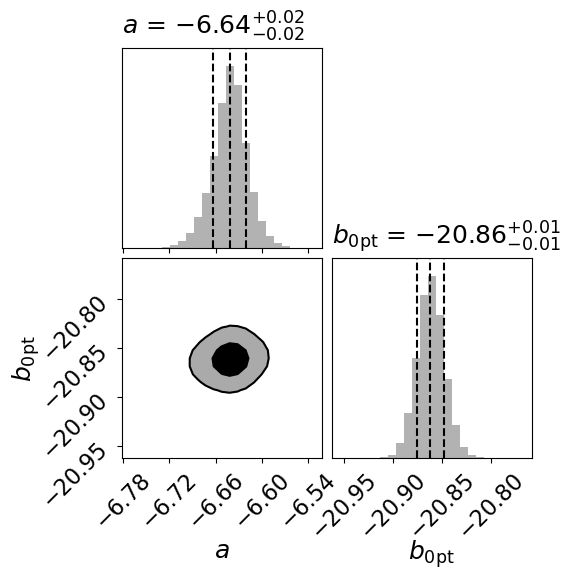

In [58]:
labels  = ['$a$']
labels += ['$b_{0\mathrm{pt}}$'] + [f'$b_{{ {k+1} }}$' for k in np.arange(m)]
labels += [r'$\sigma$'] #+ [rf'$\sigma_{k}$' for k in np.arange(m)]

fig = corner(tfr_mcmc_samples[0:2].T, bins=25, smooth=1,
#              range=[[1.9, 2.4], [0.75, 1.1], [0.1, 0.3]],   # Range for a, b, sigma. Adjust as needed.
             labels=labels,
             label_kwargs={'fontsize':18},
             labelpad=0.1,
             levels=(1-np.exp(-0.5), 1-np.exp(-2)),
             quantiles=[0.16, 0.5, 0.84],
             hist_kwargs={'histtype':'stepfilled', 'alpha':0.3},
             plot_datapoints=False,
             fill_contours=True,
             show_titles=True,
             title_kwargs={"fontsize": 18, 'loc':'left', 'pad':10});

for ax in fig.get_axes():
    ax.tick_params(axis='both', which='major', labelsize=16)

# fig.savefig('../../Figures/Y3/TF_Y3_cluster_calibration.png', dpi=150,facecolor='none');

### Plot the HyperFit Results

In [59]:
sigma_mcmc = np.percentile(tfr_mcmc_samples[-1], [16., 50., 84.])
a_mcmc = np.percentile(tfr_mcmc_samples[0], [16., 50., 84])
b_mcmc = []
for k in range(1, m+2):
    b_mcmc.append(np.percentile(tfr_mcmc_samples[k], [16., 50., 84.]))
b_mcmc = np.asarray(b_mcmc)

-6.641044850284957


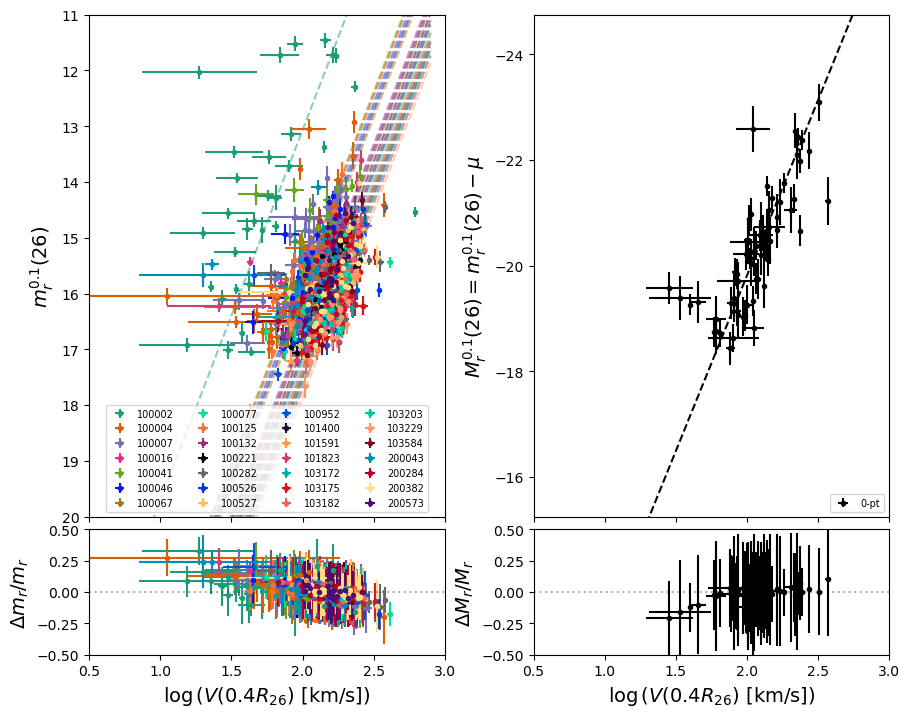

In [66]:
fig, axes = plt.subplots(2,2, figsize=(10,8), sharex=True,
                         gridspec_kw={'height_ratios':[4,1], 'hspace':0.04, 'wspace':0.25})

a_   = a_mcmc[1]
b0pt = b_mcmc[0,1]
b_   = b_mcmc[:,1][1:]

#- Plot clusters
ax = axes[0,0]

_logv = np.arange(0, 3, 0.1) - logV0
for k in range(m):
    eb = ax.errorbar(x=logV[k+1] + logV0, y=mag[k+1], xerr=logV_err[k+1], yerr=mag_err[k+1],
                     fmt='.', label=f'{_cluster_ids[k]}')

    ax.plot(_logv + logV0, a_*_logv + b_[k], color=eb[0].get_color(), ls='--', alpha=0.5)#, label='fit')

ax.set(xlim=[.5, 3],
       ylim=[20, 11]
      )
ax.set_ylabel(r'$m_r^{0.1} (26)$', fontsize=14)
ax.legend(loc='lower center', fontsize=7, ncol = 4);

#- Plot calibrators
ax = axes[0,1]
eb = ax.errorbar(x=logV[0] + logV0, y=mag[0], xerr=logV_err[0], yerr=mag_err[0],
                 fmt='k.', label=f'0-pt')

ax.plot(_logv + logV0, a_*_logv + b0pt, color=eb[0].get_color(), ls='--')#, label='fit')
ax.set(xlim=[.5, 3],
       ylim=[-15.25, -24.75]
      )
ax.set_ylabel(r'$M_r^{0.1}(26) = m_r^{0.1}(26) - \mu$', fontsize=14)
ax.legend(loc='lower right', fontsize=7)

#- Plot residuals: clusters
ax = axes[1,0]

for k in range(m):
    logv_obs = logV[k+1]
    m_obs = mag[k+1]
    m_exp = (a_*logv_obs + b_[k])
    eb = ax.errorbar(x=logv_obs + logV0, y=(m_exp-m_obs)/m_exp, xerr=logV_err[k+1], yerr=mag_err[k+1],
                     fmt='.', label=f'{_cluster_ids[k]}')

ax.axhline(0, ls=':', color='k', alpha=0.3)

ax.set(xlim=[.5, 3],
       ylim=[-0.5, 0.5])
ax.set_xlabel(r'$\log{(V(0.4R_{26})~[\mathrm{km/s}]}$)', fontsize=14)
ax.set_ylabel(r'$\Delta m_r/m_r$', fontsize=14)

#- Plot residuals: calibrators
ax = axes[1,1]

logv_obs = logV[0]
m_obs = mag[0]
m_exp = (a_*logv_obs + b0pt)

b = ax.errorbar(x=logv_obs + logV0, y=(m_exp-m_obs)/m_exp, xerr=logV_err[0], yerr=mag_err[0],
                     fmt='k.', label=f'0-pt')
ax.axhline(0, ls=':', color='k', alpha=0.3)

ax.set(xlim=[.5, 3],
       ylim=[-0.5, 0.5])
ax.set_xlabel(r'$\log{(V(0.4R_{26})~[\mathrm{km/s}]}$)', fontsize=14)
ax.set_ylabel(r'$\Delta M_r/M_r$', fontsize=14)

fig.subplots_adjust(left=0.1, bottom=0.1, top=0.9, right=0.9);
# fig.savefig('../../Figures/Y3/TF_Y3_cluster_calibration.png', dpi=150, facecolor='none')
print(a_)

33


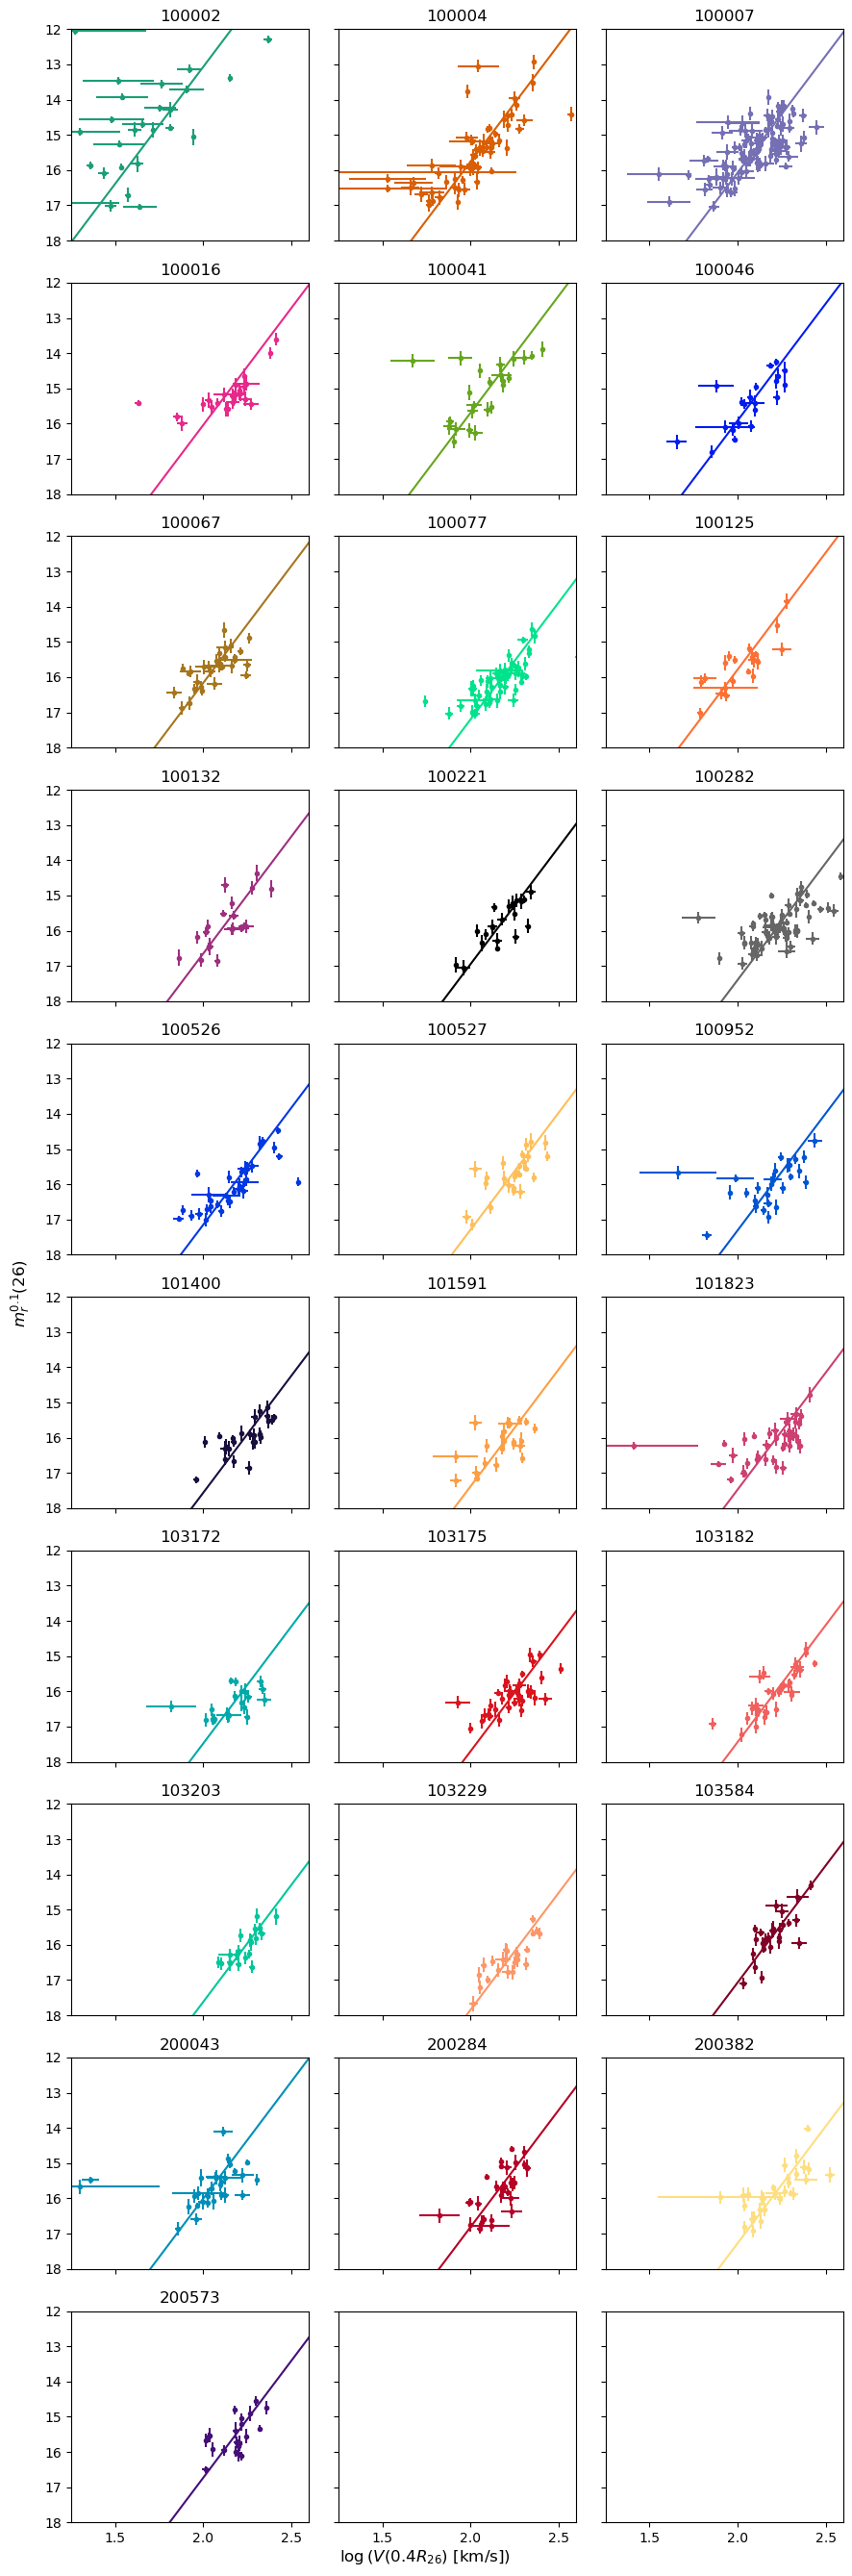

In [61]:
fig, axs = plt.subplots(nrows=10, ncols=3, sharex=True, sharey=True, figsize=(9,27), tight_layout=True)

print(len(tfcolor))
for i in range(len(_cluster_ids)):
    c = tfcolor[i]
    
    row = int(i/3)
    col = i%3
    
    eb = axs[row,col].errorbar(logV[i+1] + logV0, mag[i+1], xerr=logV_err[i+1], yerr=mag_err[i+1], fmt='.', color=c)
    axs[row,col].plot(_logv + logV0, a_*_logv + b_[i], color=c)
    
    axs[row,col].set(xlim=[1.25, 2.6], ylim=[18, 12], title=f'{_cluster_ids[i]}')
    
fig.supxlabel(r'$\log{(V(0.4R_{26})~[\mathrm{km/s}]}$)')
fig.supylabel(r'$m_r^{0.1} (26)$');

### Does this calibration result in any dwarf galaxies?

Dwarf galaxies are defined as those below the line perpendicular to the calibration where $M_r > -17$.

#### Define the line perpendicular to the calibration

In [62]:
logV_n17 = (-17 - b0pt)/a_ + logV0
# b_perp = -17 + (logV_n17 - logV0)/a_
# b_perp

mr_n17 = a_*(logV_n17 - logV0) + b_
b_perp = mr_n17 + (logV_n17 - logV0)/a_

print(10**logV_n17, 'km/s')

37.688281827498635 km/s


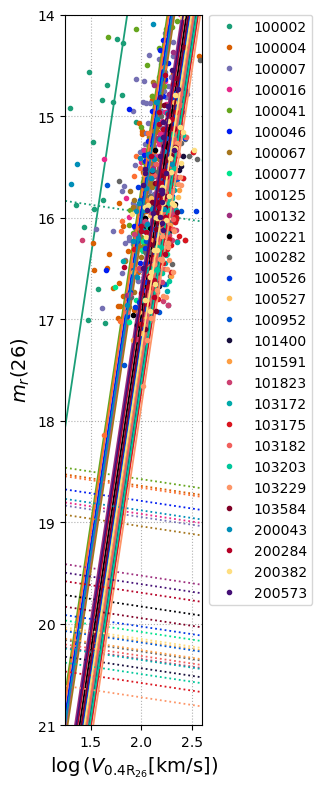

In [63]:
plt.figure(figsize=(4,8), tight_layout=True)

ax = plt.gca()

plt.grid(ls=':')

for k in range(m):
    eb = plt.plot(logV[k+1] + logV0, mag[k+1], '.', label=f'{_cluster_ids[k]}')
    plt.plot(_logv + logV0, a_*_logv + b_[k], color=eb[0].get_color(), marker='None', ls='-', lw=1.3)
    plt.plot(_logv + logV0, -_logv/a_ + b_perp[k], color=eb[0].get_color(), marker='None', ls=':', lw=1.3)
    # plt.hlines(m_dwarf_clusters[_cluster_ids[k]], 1.25, 2.75, colors=eb[0].get_color(), linestyles='dashed')
    
plt.xlabel(r'$\log{(V_\mathrm{0.4R_{26}} [\mathrm{km/s}])}$', fontsize=14)
plt.ylabel(r'$m_r (26)$', fontsize=14)

plt.legend(bbox_to_anchor=(1.05,1), loc='upper left', borderaxespad=0)

plt.xlim(1.25, 2.6)
plt.ylim(21, 14)

plt.gca().set_aspect('equal');

#### Filter out the dwarf galaxies

Those below the line
\begin{equation}
  m_r = -(\log(V(0.4R_{26})) - V_0)/a + b_{\rm cluster \perp}
\end{equation}

In [64]:
dwarfs = np.zeros(len(caltab), dtype=bool)

for i in range(m):
    # Retrieve this cluster's nest ID
    nestid = _cluster_ids[i]
    
    # Find all galaxies in this cluster
    cluster_gal_idx = caltab['CLUSTER_ID'] == nestid
    
    # Find which of these cluster galaxies are dwarfs
    cluster_dwarfs = (caltab['R_MAG_SB26_CORR'][cluster_gal_idx] - caltab['R_MAG_SB26_ERR_CORR'][cluster_gal_idx]) > (-(np.log10(caltab['V_0p4R26'][cluster_gal_idx]) - logV0)/a_ + b_perp[k])
    
    # Set the boolean correctly
    dwarfs[cluster_gal_idx] = cluster_dwarfs
    
caltab_bright = caltab[~dwarfs]

print(np.sum(dwarfs))

0
